# CNN + MaxPool
Run this model on all lncRNA cell lines using some theshold. This notebook tests 'ZERO'.

* zero
* RCI threshold set by GMM(2).
* Antilog threshold set by GMM(2).

Show pretty pictures.

10-fold cross-validation.

Compute the sample standard deviation.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-02-07 15:27:37.998407
Python 3.8.10
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=10      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'
CACHING = False   # have not worked out how to cache multiple cell lines

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1,7]   # use these though they are clearly different

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_str = fields[cell_line]
                    if rci_str != "nan":
                        rci_val = float(rci_str)
                        gene_to_rci[gene_id] = rci_val
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-02-07 15:28:04.892019
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        
    def set_sequences(self, allids, allseq):
        # It is critical to keep IDs and sequences in same order!
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order!
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def get_X_y(self, gene_index):
        cnt = len(self.all_ids)
        subsetX=[]
        subsetY=[]
        next_index = 0
        for i in range(cnt):
            if next_index==len(gene_index):
                break
            if i==gene_index[next_index]:
                gene_id,tran_id = self.all_ids[i]
                oneX = self.all_seqs[i]
                oneY = self.rci_map[gene_id]
                subsetX.append(oneX)
                subsetY.append(oneY)
                next_index += 1
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def rcis_to_labels(self, array_of_rci, rci_threshold):
        IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
        return np.array(list(map(IS_CYTO, array_of_rci)))
    
    def place_discriminant(self,minRCI,maxRCI,mean1,var1,wgt1,mean2,var2,wgt2):
        bests = []
        left = None
        middle = None
        std1 = np.sqrt(var1)
        std2 = np.sqrt(var2)
        zmin = max(mean1-2*std1,mean2-2*std2)
        zmax = min(mean1+2*std1,mean2+2*std2)
        zrange = (zmax-zmin)
        for i in range(101):
            if left is None:
                x = zrange * (i-1)/100.0 + zmin
                p1 = ss.norm(mean1,var1).pdf(x)*wgt1
                p2 = ss.norm(mean2,var2).pdf(x)*wgt2
                left = p1-p2
            if middle is None:
                x = zrange * (i)/100.0 + zmin 
                p1 = ss.norm(mean1,var1).pdf(x)*wgt1
                p2 = ss.norm(mean2,var2).pdf(x)*wgt2
                middle = p1-p2
            x = zrange * (i+1)/100.0 + zmin 
            p1 = ss.norm(mean1,var1).pdf(x)*wgt1
            p2 = ss.norm(mean2,var2).pdf(x)*wgt2
            right = p1-p2
            if left * right < 0.0:
                bests.append(x)
            left = middle
            middle = right
        if len(bests)==0:
            return None
        print('Bests',bests)
        return np.mean(bests)

    def choose_rci_threshold(self, rci_values):
        discrim = 0
        if RCI_THRESHOLD_MECHANISM == 'RCI_GMM':
            gmm2 = GaussianMixture(n_components=2, verbose=0, 
                covariance_type='spherical', n_init=10) # best of 10
            gmm2.fit(rci_values)
            discrim = self.place_discriminant(
                min(rci_values),max(rci_values),
                gmm2.means_[0],gmm2.covariances_[0],gmm2.weights_[0],
                gmm2.means_[1],gmm2.covariances_[1],gmm2.weights_[1])
            if discrim is None:
                discrim = np.mean(rci_values)
                print('WARNING: discrim not found, using mean!')
        elif RCI_THRESHOLD_MECHANISM == 'THE_MEAN':
            discrim = np.mean(rci_values)
        return discrim
        
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        cv_auprc=[]
        cv_auroc=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        splits = splitter.split(self.all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            X_train,y_train = self.get_X_y(train_index)
            train_based_rci_threshold = self.choose_rci_threshold(y_train)
            train_based_rci_mean = np.mean(y_train)
            y_train = self.rcis_to_labels(y_train,train_based_rci_threshold)
            X_valid,y_valid = self.get_X_y(valid_index)
            y_valid = self.rcis_to_labels(y_valid,train_based_rci_threshold) # yes, train_based
            print('RCI mean derived from training set:',train_based_rci_mean)
            print('RCI threshold derived from training set:',train_based_rci_threshold)

            #print('Training example')
            #print(X_train[0])
            #print("BUILD MODEL")
            model=build_model()
            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
              epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none
              validation_data=(X_valid,y_valid) )
            print("PREDICT")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0)             
            yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            # PRC
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            auroc = roc_auc_score(y_valid, yhat_pred)*100.

            if PRETTY_PICTURES:
                pd.DataFrame(history.history).plot(figsize=(8,5))
                plt.grid(True)
                plt.gca().set_ylim(0,1)
                plt.show()

                print('Train set ones/size',
                      np.count_nonzero(y_train),'/',len(y_train))
                print("Compute valiation accuracy")
                print('Valid sizes',X_valid.shape,y_valid.shape)
                print('Valid set ones/size',
                      np.count_nonzero(y_valid),'/',len(y_valid))
                print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
                print('Score threshold',self.score_threshold)
                print('Prediction set ones/size',
                      np.count_nonzero(yhat_classes),'/',len(yhat_classes))
            
                count_ones= len(y_valid[y_valid==1])
                count_zeros= len(y_valid[y_valid==0])
                guess = max(count_ones,count_zeros) / len(y_valid)
                plt.plot(prc_X, prc_Y, marker='.')
                plt.plot([0, 1], [guess,guess], linestyle='--')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.show()
                # ROC
                fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
                plt.plot(fpr, tpr, marker='.')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.show()
            
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% AUPRC: %.2f%% AUROC: %.2f%%' % (f1,auprc,auroc)) 
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            cv_auprc.append(auprc)
            cv_auroc.append(auroc)
            
            print(datetime.now())
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break

            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            X_valid = None
            y_valid = None
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc

2023-02-07 15:28:08.327223
Start cell Line 0 A549
Number of RCI values loaded 1447
Num RCI: 1447
Load sequence...
Cross validation...
2023-02-07 15:28:23.018201
splitting
Fold 1
RCI mean derived from training set: -0.07263865964057306
RCI threshold derived from training set: 0
FIT
2023-02-07 15:28:25.295229
PREDICT
2023-02-07 15:28:41.097004


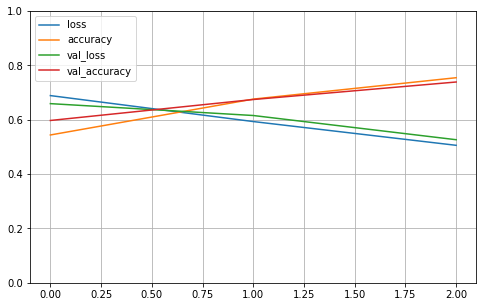

Train set ones/size 4062 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 434 / 869
Range of scores: 0.0051698964 to 0.9853019
Score threshold 0.5
Prediction set ones/size 421 / 869


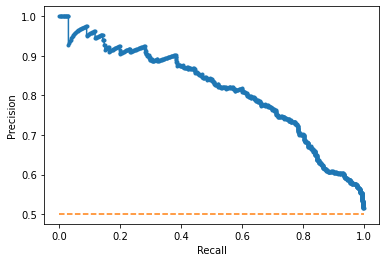

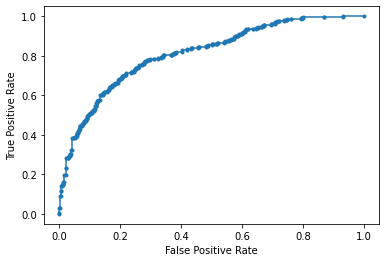

Accuracy: 73.88% Precision: 74.58% Recall: 72.35%
F1: 73.45% AUPRC: 81.37% AUROC: 81.23%
2023-02-07 15:28:41.836471
Fold 2
RCI mean derived from training set: -0.08890415963673573
RCI threshold derived from training set: 0
FIT
2023-02-07 15:28:46.299638
PREDICT
2023-02-07 15:28:54.459110


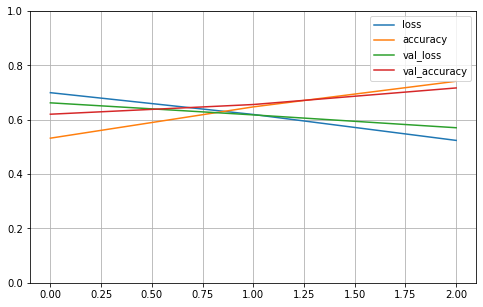

Train set ones/size 4017 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 479 / 869
Range of scores: 0.004396557 to 0.97621584
Score threshold 0.5
Prediction set ones/size 387 / 869


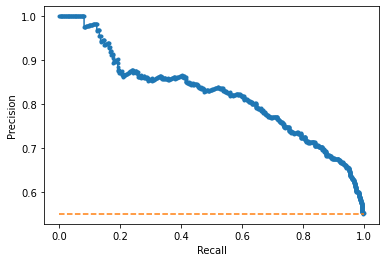

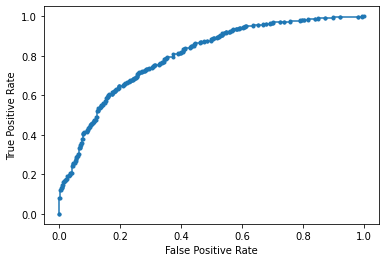

Accuracy: 71.69% Precision: 80.10% Recall: 64.72%
F1: 71.59% AUPRC: 82.16% AUROC: 79.91%
2023-02-07 15:28:55.064318
Fold 3
RCI mean derived from training set: -0.08061058532361218
RCI threshold derived from training set: 0
FIT
2023-02-07 15:28:59.330413
PREDICT
2023-02-07 15:29:07.577112


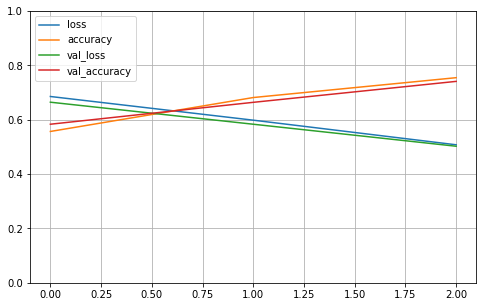

Train set ones/size 4043 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 453 / 869
Range of scores: 0.00907445 to 0.98649096
Score threshold 0.5
Prediction set ones/size 398 / 869


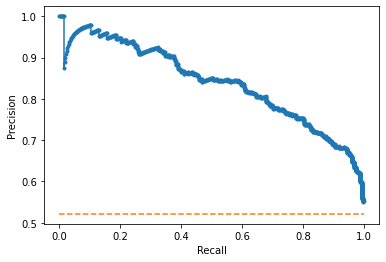

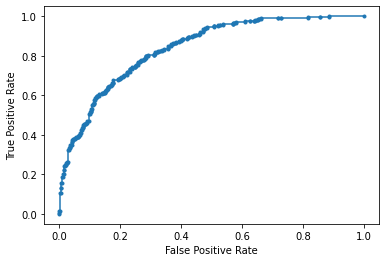

Accuracy: 74.11% Precision: 78.64% Recall: 69.09%
F1: 73.56% AUPRC: 83.95% AUROC: 83.94%
2023-02-07 15:29:08.411060
Fold 4
RCI mean derived from training set: -0.07163159574827323
RCI threshold derived from training set: 0
FIT
2023-02-07 15:29:12.375564
PREDICT
2023-02-07 15:29:20.536382


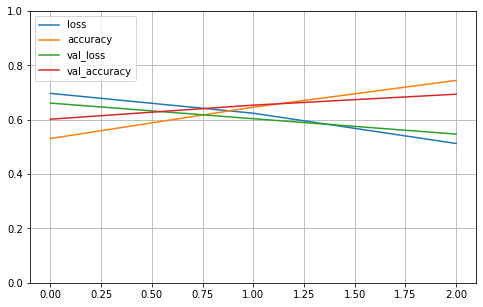

Train set ones/size 4070 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 426 / 869
Range of scores: 0.01531603 to 0.9934157
Score threshold 0.5
Prediction set ones/size 536 / 869


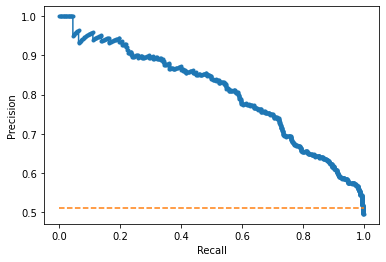

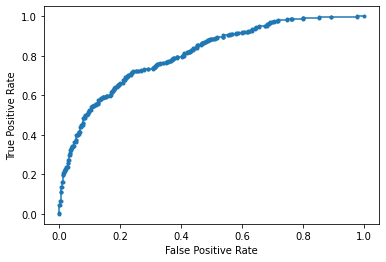

Accuracy: 69.39% Precision: 64.93% Recall: 81.69%
F1: 72.35% AUPRC: 80.54% AUROC: 80.81%
2023-02-07 15:29:21.418191
Fold 5
RCI mean derived from training set: -0.07909441939498593
RCI threshold derived from training set: 0
FIT
2023-02-07 15:29:25.359242
PREDICT
2023-02-07 15:29:36.645194


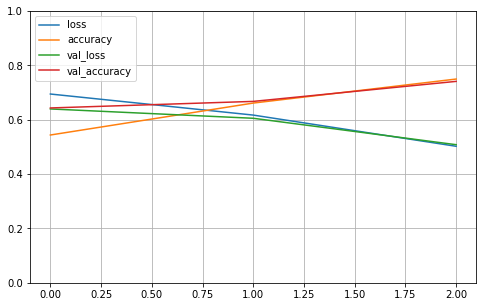

Train set ones/size 4033 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 463 / 869
Range of scores: 0.00820159 to 0.9889669
Score threshold 0.5
Prediction set ones/size 468 / 869


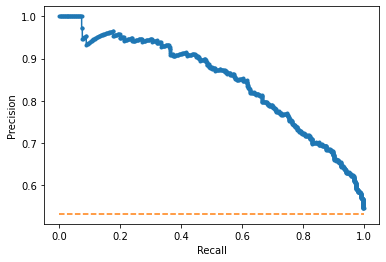

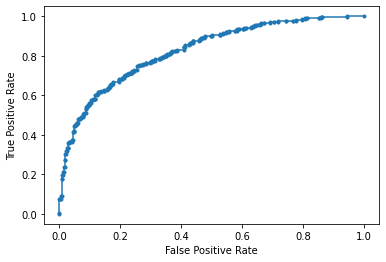

Accuracy: 74.11% Precision: 75.43% Recall: 76.24%
F1: 75.83% AUPRC: 84.76% AUROC: 82.67%
2023-02-07 15:29:37.281267
Fold 6
RCI mean derived from training set: -0.08340265725249423
RCI threshold derived from training set: 0
FIT
2023-02-07 15:29:40.850025
PREDICT
2023-02-07 15:29:49.639946


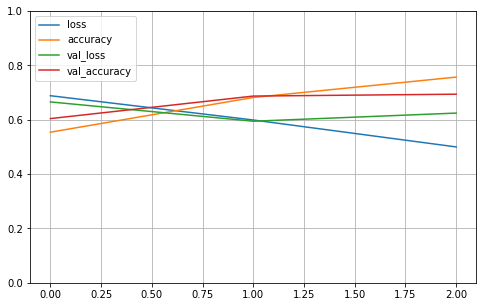

Train set ones/size 4060 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 436 / 869
Range of scores: 0.015751224 to 0.9976446
Score threshold 0.5
Prediction set ones/size 590 / 869


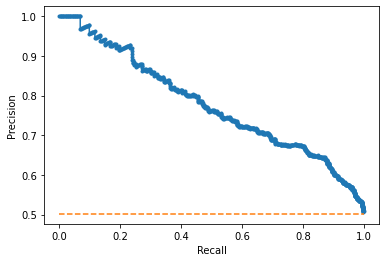

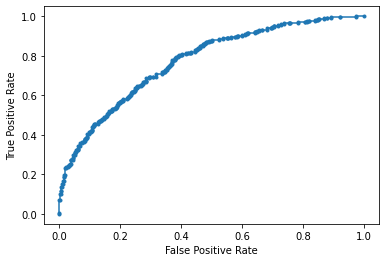

Accuracy: 69.39% Precision: 64.41% Recall: 87.16%
F1: 74.07% AUPRC: 77.88% AUROC: 77.36%
2023-02-07 15:29:50.296767
Fold 7
RCI mean derived from training set: -0.07222989336019443
RCI threshold derived from training set: 0
FIT
2023-02-07 15:29:54.770584
PREDICT
2023-02-07 15:30:06.048325


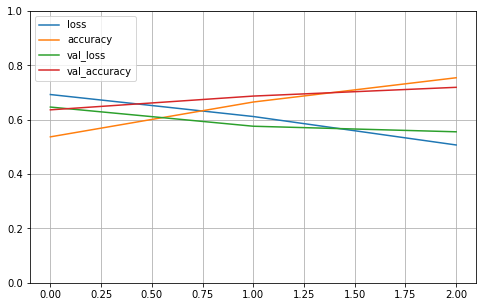

Train set ones/size 4034 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 462 / 869
Range of scores: 0.007279357 to 0.9883978
Score threshold 0.5
Prediction set ones/size 480 / 869


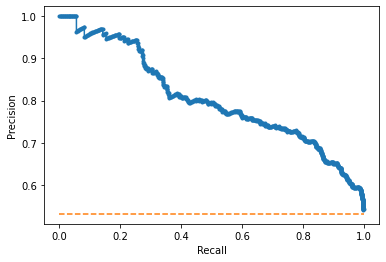

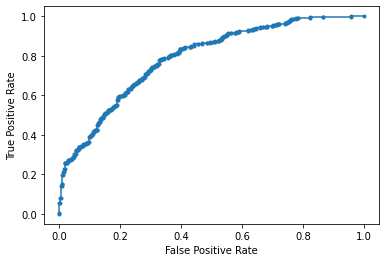

Accuracy: 71.92% Precision: 72.71% Recall: 75.54%
F1: 74.10% AUPRC: 80.56% AUROC: 78.82%
2023-02-07 15:30:06.683784
Fold 8
RCI mean derived from training set: -0.07443658561580764
RCI threshold derived from training set: 0
FIT
2023-02-07 15:30:10.215617
PREDICT
2023-02-07 15:30:18.842876


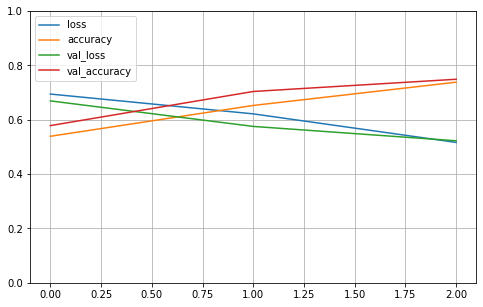

Train set ones/size 4053 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 443 / 868
Range of scores: 0.011737125 to 0.9934314
Score threshold 0.5
Prediction set ones/size 459 / 868


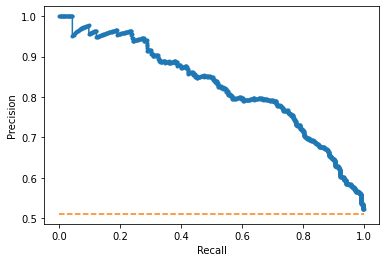

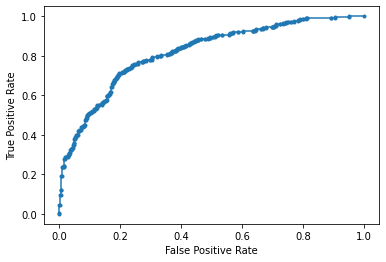

Accuracy: 74.88% Precision: 74.51% Recall: 77.20%
F1: 75.83% AUPRC: 82.71% AUROC: 81.79%
2023-02-07 15:30:19.502746
Fold 9
RCI mean derived from training set: -0.08124539040798057
RCI threshold derived from training set: 0
FIT
2023-02-07 15:30:23.056008
PREDICT
2023-02-07 15:30:31.660224


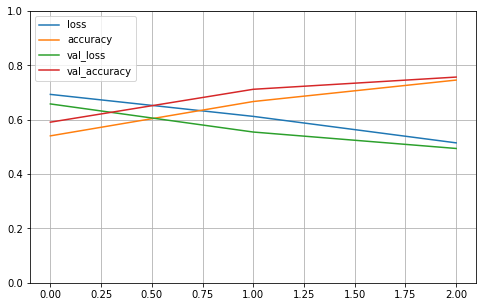

Train set ones/size 4042 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 454 / 868
Range of scores: 0.002880085 to 0.9898302
Score threshold 0.5
Prediction set ones/size 497 / 868


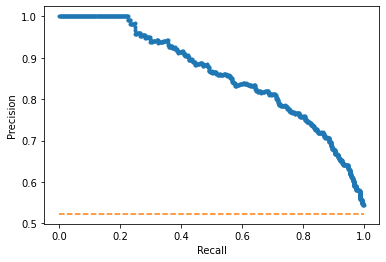

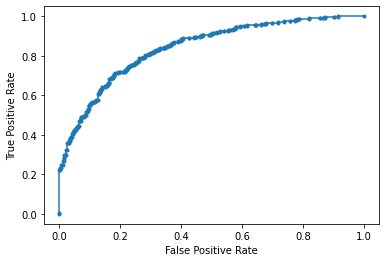

Accuracy: 75.69% Precision: 74.45% Recall: 81.50%
F1: 77.81% AUPRC: 85.96% AUROC: 84.06%
2023-02-07 15:30:32.328473
Fold 10
RCI mean derived from training set: -0.07852757553011895
RCI threshold derived from training set: 0
FIT
2023-02-07 15:30:35.887953
PREDICT
2023-02-07 15:30:47.133328


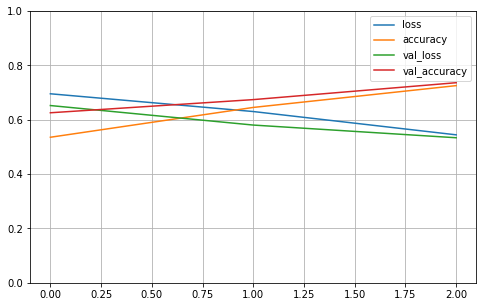

Train set ones/size 4050 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 446 / 868
Range of scores: 0.0199735 to 0.98230714
Score threshold 0.5
Prediction set ones/size 379 / 868


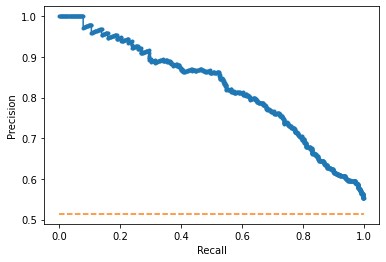

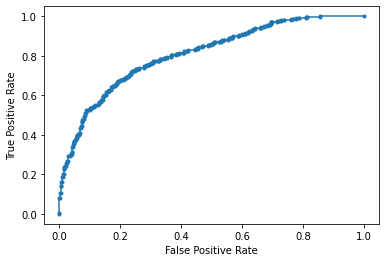

Accuracy: 73.62% Precision: 78.63% Recall: 66.82%
F1: 72.24% AUPRC: 82.38% AUROC: 80.99%
2023-02-07 15:30:47.762383

Completed cross validation 10 folds 3 epochs
 accuracy mean 72.87% +/- 2.19
 precision mean 73.84% +/- 5.36
 recall mean 75.23% +/- 7.11
 F1 mean 74.08% +/- 1.92
 AUPRC mean 82.23% +/- 2.33
 AUROC mean 81.16% +/- 2.12
Finished cell Line 0 A549

2023-02-07 15:30:49.134365
Start cell Line 1 H1.hESC
Number of RCI values loaded 3327
Num RCI: 3327
Load sequence...
Cross validation...
2023-02-07 15:31:14.958189
splitting
Fold 1
RCI mean derived from training set: -0.2860503863035882
RCI threshold derived from training set: 0
FIT
2023-02-07 15:31:19.458666
PREDICT
2023-02-07 15:31:41.810310


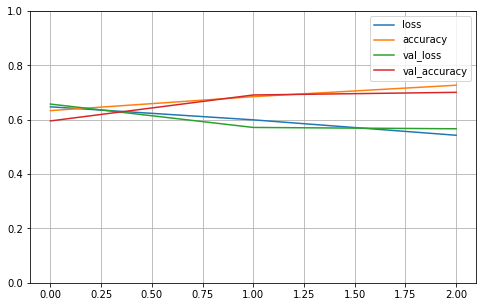

Train set ones/size 5595 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 607 / 1654
Range of scores: 0.018416842 to 0.98866373
Score threshold 0.5
Prediction set ones/size 750 / 1654


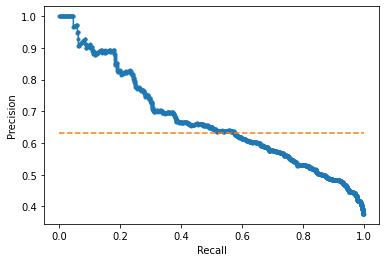

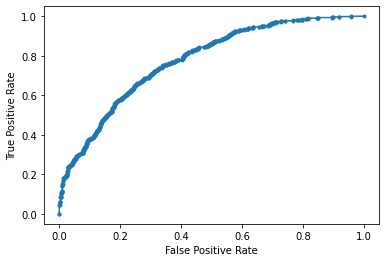

Accuracy: 70.07% Precision: 57.47% Recall: 71.00%
F1: 63.52% AUPRC: 67.28% AUROC: 77.72%
2023-02-07 15:31:42.686762
Fold 2
RCI mean derived from training set: -0.2767828940834565
RCI threshold derived from training set: 0
FIT
2023-02-07 15:31:50.036178
PREDICT
2023-02-07 15:32:05.292265


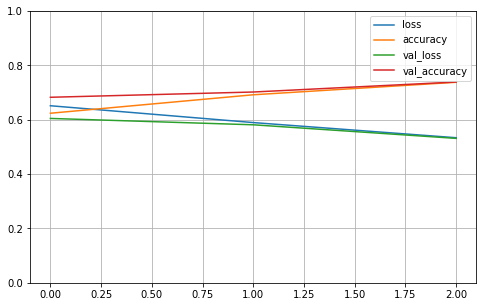

Train set ones/size 5613 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 589 / 1654
Range of scores: 0.002738447 to 0.955136
Score threshold 0.5
Prediction set ones/size 327 / 1654


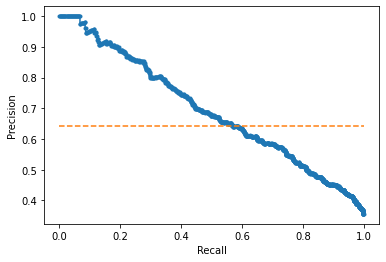

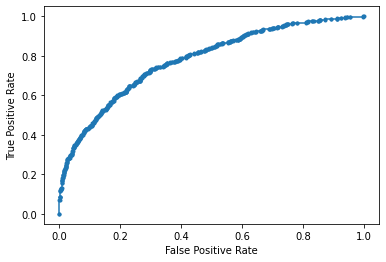

Accuracy: 73.88% Precision: 74.01% Recall: 41.09%
F1: 52.84% AUPRC: 69.51% AUROC: 78.00%
2023-02-07 15:32:06.179066
Fold 3
RCI mean derived from training set: -0.2846416293146083
RCI threshold derived from training set: 0
FIT
2023-02-07 15:32:11.813478
PREDICT
2023-02-07 15:32:34.135478


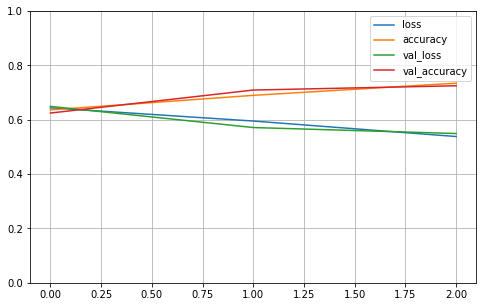

Train set ones/size 5568 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 634 / 1654
Range of scores: 0.0033424143 to 0.9894498
Score threshold 0.5
Prediction set ones/size 505 / 1654


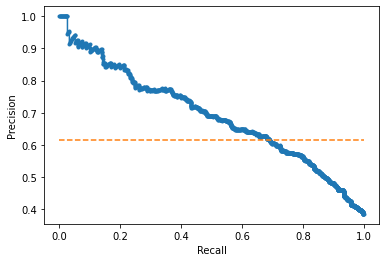

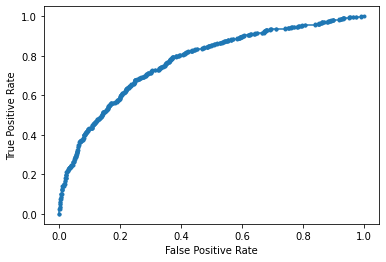

Accuracy: 72.49% Precision: 67.72% Recall: 53.94%
F1: 60.05% AUPRC: 69.24% AUROC: 77.41%
2023-02-07 15:32:34.921179
Fold 4
RCI mean derived from training set: -0.2841060262625991
RCI threshold derived from training set: 0
FIT
2023-02-07 15:32:42.068912
PREDICT
2023-02-07 15:33:04.032431


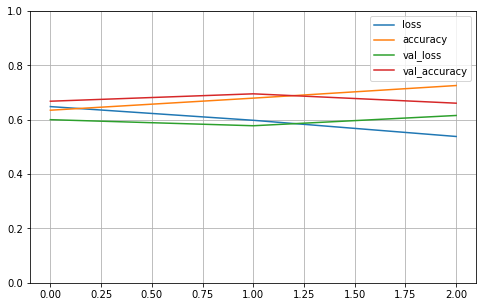

Train set ones/size 5583 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 619 / 1654
Range of scores: 0.017769592 to 0.99564373
Score threshold 0.5
Prediction set ones/size 990 / 1654


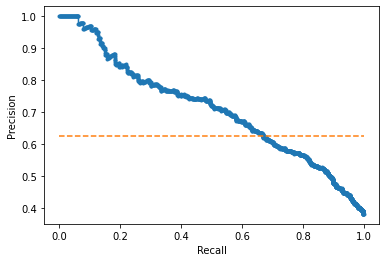

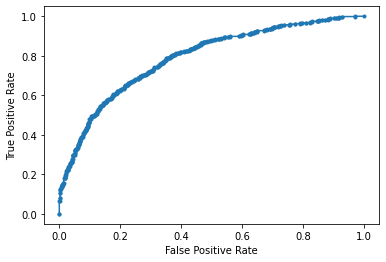

Accuracy: 66.08% Precision: 52.93% Recall: 84.65%
F1: 65.13% AUPRC: 70.98% AUROC: 79.02%
2023-02-07 15:33:04.915931
Fold 5
RCI mean derived from training set: -0.2888123344866282
RCI threshold derived from training set: 0
FIT
2023-02-07 15:33:11.142909
PREDICT
2023-02-07 15:33:33.072884


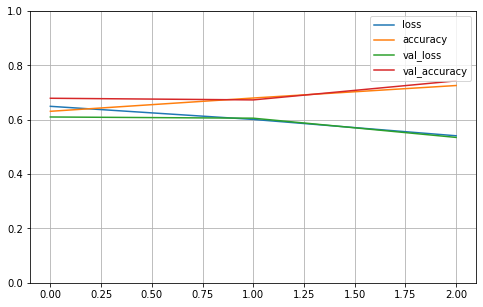

Train set ones/size 5540 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 662 / 1654
Range of scores: 0.008096593 to 0.99203146
Score threshold 0.5
Prediction set ones/size 593 / 1654


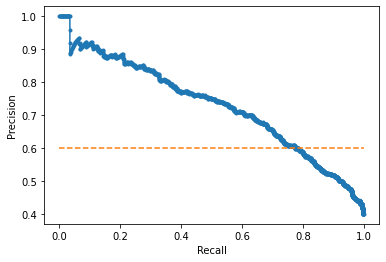

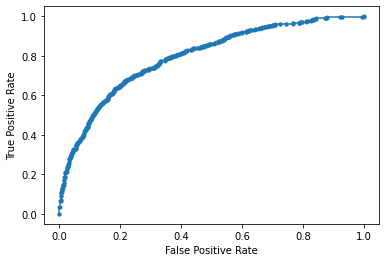

Accuracy: 74.30% Precision: 69.98% Recall: 62.69%
F1: 66.14% AUPRC: 72.96% AUROC: 79.59%
2023-02-07 15:33:33.860078
Fold 6
RCI mean derived from training set: -0.2858548136823007
RCI threshold derived from training set: 0
FIT
2023-02-07 15:33:39.504652
PREDICT
2023-02-07 15:34:01.463348


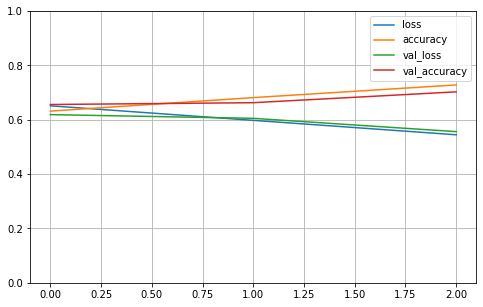

Train set ones/size 5560 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 642 / 1654
Range of scores: 0.024385711 to 0.9523585
Score threshold 0.5
Prediction set ones/size 520 / 1654


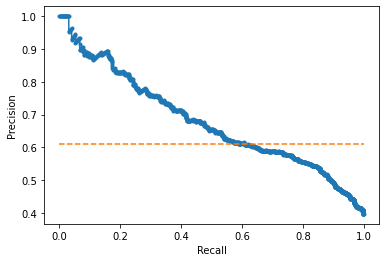

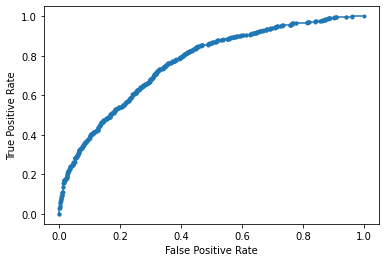

Accuracy: 70.25% Precision: 64.42% Recall: 52.18%
F1: 57.66% AUPRC: 68.02% AUROC: 76.64%
2023-02-07 15:34:02.338701
Fold 7
RCI mean derived from training set: -0.28354508167439363
RCI threshold derived from training set: 0
FIT
2023-02-07 15:34:07.918932
PREDICT
2023-02-07 15:34:23.605819


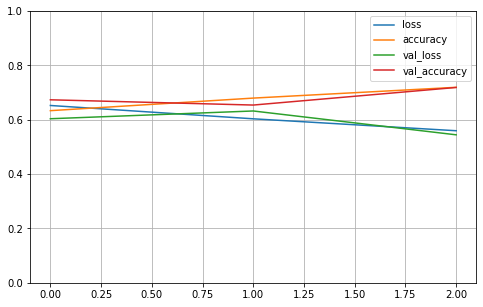

Train set ones/size 5587 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 615 / 1653
Range of scores: 0.009517387 to 0.9820055
Score threshold 0.5
Prediction set ones/size 332 / 1653


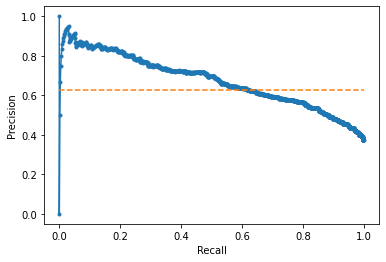

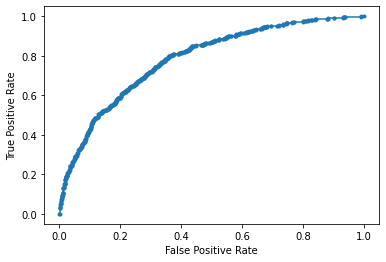

Accuracy: 71.87% Precision: 72.59% Recall: 39.19%
F1: 50.90% AUPRC: 67.50% AUROC: 78.36%
2023-02-07 15:34:24.600545
Fold 8
RCI mean derived from training set: -0.27972968674662363
RCI threshold derived from training set: 0
FIT
2023-02-07 15:34:30.281110
PREDICT
2023-02-07 15:34:45.772104


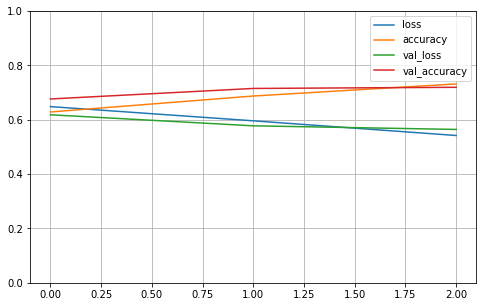

Train set ones/size 5607 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 595 / 1653
Range of scores: 0.014638804 to 0.9990527
Score threshold 0.5
Prediction set ones/size 737 / 1653


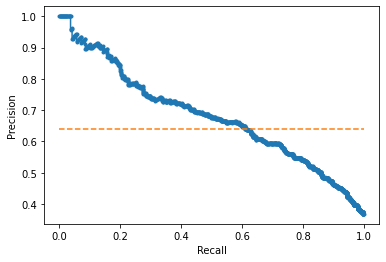

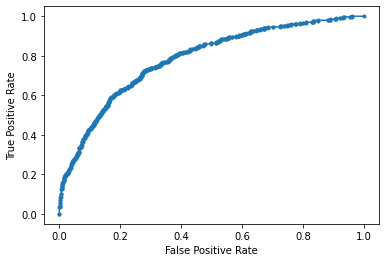

Accuracy: 71.93% Precision: 58.89% Recall: 72.94%
F1: 65.17% AUPRC: 68.18% AUROC: 78.38%
2023-02-07 15:34:46.641844
Fold 9
RCI mean derived from training set: -0.2802676957286837
RCI threshold derived from training set: 0
FIT
2023-02-07 15:34:53.323813
PREDICT
2023-02-07 15:35:15.258202


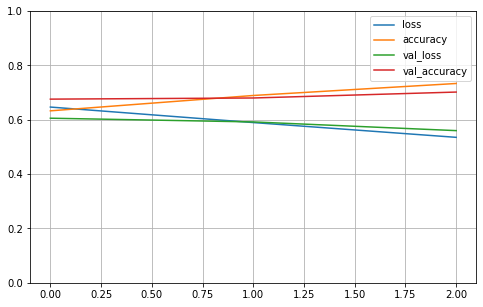

Train set ones/size 5598 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 604 / 1653
Range of scores: 0.0146507565 to 0.9924205
Score threshold 0.5
Prediction set ones/size 653 / 1653


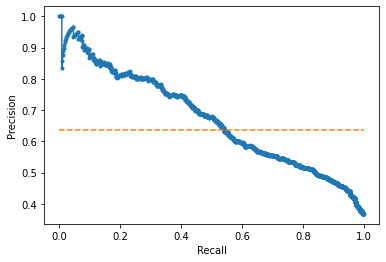

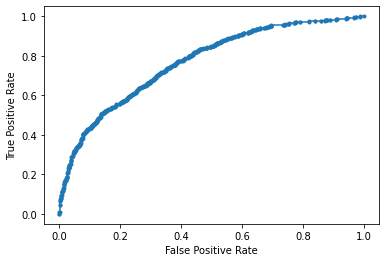

Accuracy: 70.18% Precision: 58.50% Recall: 63.25%
F1: 60.78% AUPRC: 67.12% AUROC: 76.95%
2023-02-07 15:35:16.193754
Fold 10
RCI mean derived from training set: -0.28432212661761747
RCI threshold derived from training set: 0
FIT
2023-02-07 15:35:21.859812
PREDICT
2023-02-07 15:35:43.797142


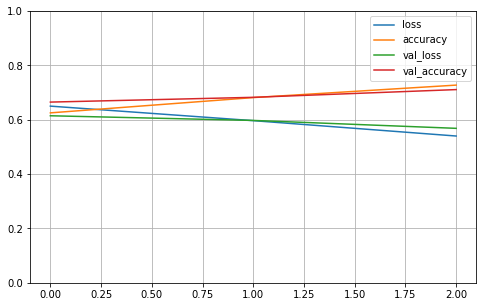

Train set ones/size 5567 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 635 / 1653
Range of scores: 0.0057755187 to 0.96761036
Score threshold 0.5
Prediction set ones/size 395 / 1653


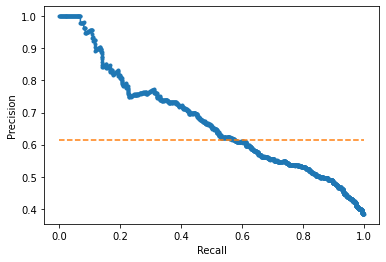

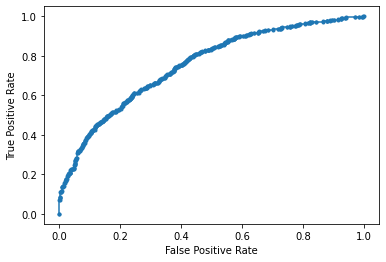

Accuracy: 71.08% Precision: 69.87% Recall: 43.46%
F1: 53.59% AUPRC: 67.39% AUROC: 75.38%
2023-02-07 15:35:44.577631

Completed cross validation 10 folds 3 epochs
 accuracy mean 71.21% +/- 2.33
 precision mean 64.64% +/- 7.27
 recall mean 58.44% +/- 15.10
 F1 mean 59.58% +/- 5.60
 AUPRC mean 68.82% +/- 1.90
 AUROC mean 77.74% +/- 1.22
Finished cell Line 1 H1.hESC

2023-02-07 15:35:46.127981
Start cell Line 2 HeLa.S3
Number of RCI values loaded 919
Num RCI: 919
Load sequence...
Cross validation...
2023-02-07 15:35:55.879473
splitting
Fold 1
RCI mean derived from training set: -1.283539943874046
RCI threshold derived from training set: 0
FIT
2023-02-07 15:35:57.558823
PREDICT
2023-02-07 15:36:03.405848


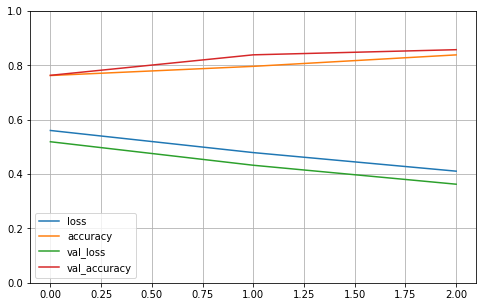

Train set ones/size 1208 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 138 / 583
Range of scores: 0.0034468265 to 0.96014476
Score threshold 0.5
Prediction set ones/size 67 / 583


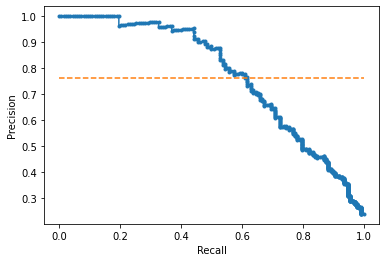

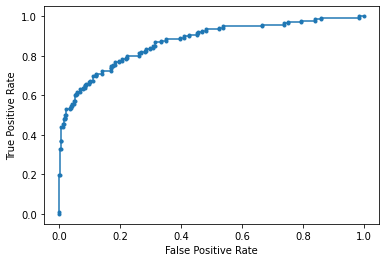

Accuracy: 85.76% Precision: 91.04% Recall: 44.20%
F1: 59.51% AUPRC: 77.23% AUROC: 87.15%
2023-02-07 15:36:04.028635
Fold 2
RCI mean derived from training set: -1.2804343327099237
RCI threshold derived from training set: 0
FIT
2023-02-07 15:36:07.789166
PREDICT
2023-02-07 15:36:13.663905


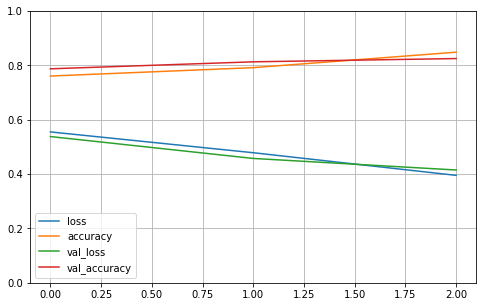

Train set ones/size 1215 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 131 / 583
Range of scores: 0.002292535 to 0.9839113
Score threshold 0.5
Prediction set ones/size 55 / 583


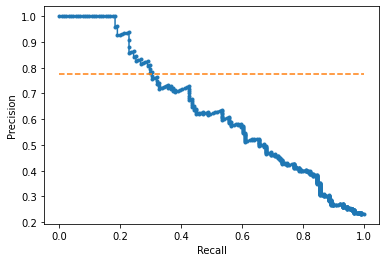

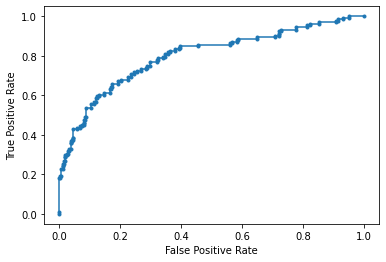

Accuracy: 82.50% Precision: 76.36% Recall: 32.06%
F1: 45.16% AUPRC: 63.74% AUROC: 79.94%
2023-02-07 15:36:14.283779
Fold 3
RCI mean derived from training set: -1.2776195288549619
RCI threshold derived from training set: 0
FIT
2023-02-07 15:36:17.015852
PREDICT
2023-02-07 15:36:28.130296


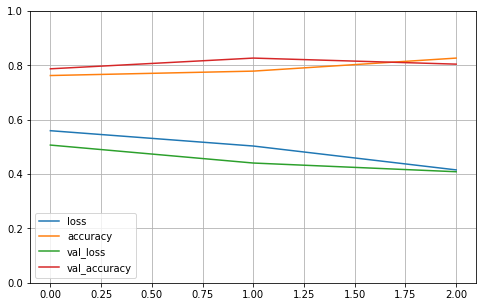

Train set ones/size 1222 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 124 / 583
Range of scores: 0.0006777882 to 0.8721052
Score threshold 0.5
Prediction set ones/size 14 / 583


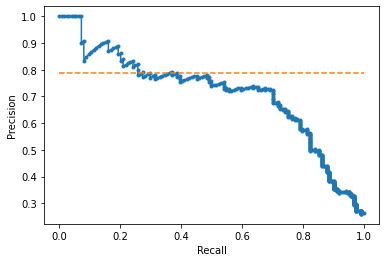

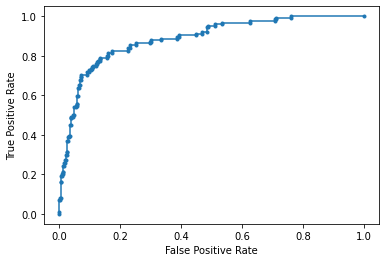

Accuracy: 80.45% Precision: 85.71% Recall: 9.68%
F1: 17.39% AUPRC: 71.04% AUROC: 88.67%
2023-02-07 15:36:28.705834
Fold 4
RCI mean derived from training set: -1.2759836982064492
RCI threshold derived from training set: 0
FIT
2023-02-07 15:36:31.945582
PREDICT
2023-02-07 15:36:38.132295


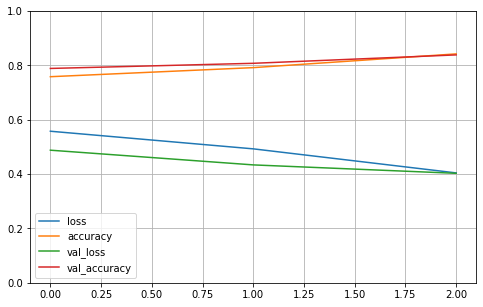

Train set ones/size 1223 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 123 / 582
Range of scores: 0.0057120407 to 0.99494135
Score threshold 0.5
Prediction set ones/size 123 / 582


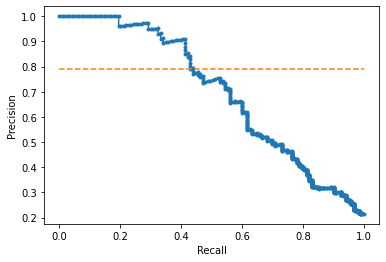

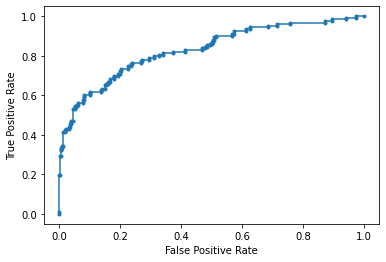

Accuracy: 83.85% Precision: 61.79% Recall: 61.79%
F1: 61.79% AUPRC: 69.84% AUROC: 83.18%
2023-02-07 15:36:38.788630
Fold 5
RCI mean derived from training set: -1.2879645047891624
RCI threshold derived from training set: 0
FIT
2023-02-07 15:36:41.560292
PREDICT
2023-02-07 15:36:52.553408


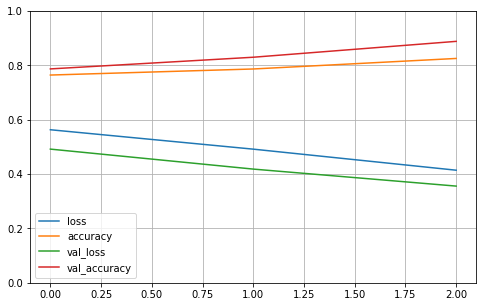

Train set ones/size 1222 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 124 / 582
Range of scores: 0.0030249145 to 0.9759629
Score threshold 0.5
Prediction set ones/size 93 / 582


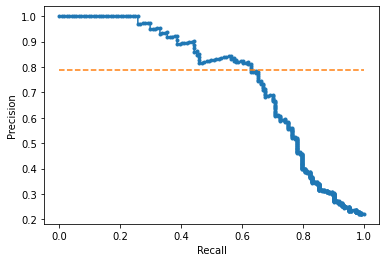

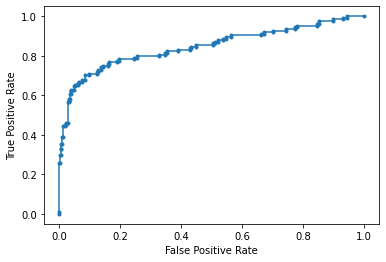

Accuracy: 88.83% Precision: 81.72% Recall: 61.29%
F1: 70.05% AUPRC: 75.11% AUROC: 84.65%
2023-02-07 15:36:53.193457
Fold 6
RCI mean derived from training set: -1.285638432093112
RCI threshold derived from training set: 0
FIT
2023-02-07 15:36:55.968434
PREDICT
2023-02-07 15:37:06.955174


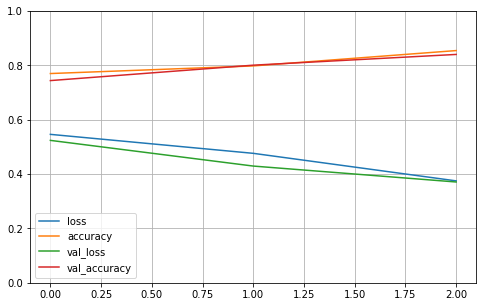

Train set ones/size 1197 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 149 / 582
Range of scores: 0.0009898806 to 0.9743774
Score threshold 0.5
Prediction set ones/size 64 / 582


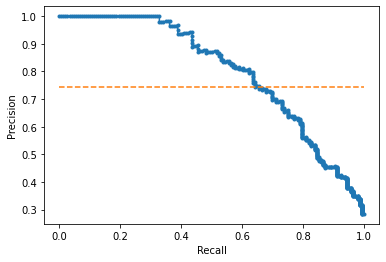

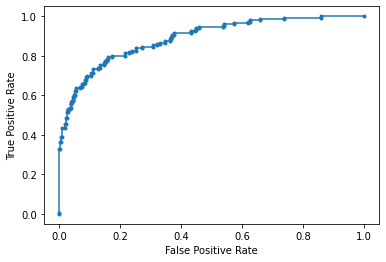

Accuracy: 84.02% Precision: 93.75% Recall: 40.27%
F1: 56.34% AUPRC: 80.18% AUROC: 88.93%
2023-02-07 15:37:07.563541
Fold 7
RCI mean derived from training set: -1.3007761754245373
RCI threshold derived from training set: 0
FIT
2023-02-07 15:37:10.323415
PREDICT
2023-02-07 15:37:16.672710


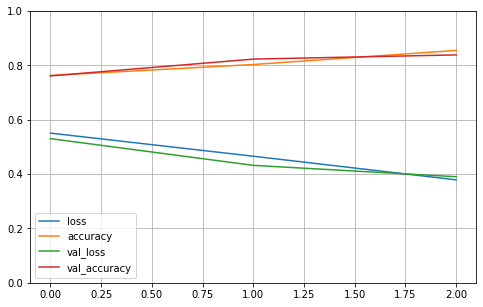

Train set ones/size 1207 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 139 / 582
Range of scores: 0.0006655859 to 0.9632942
Score threshold 0.5
Prediction set ones/size 65 / 582


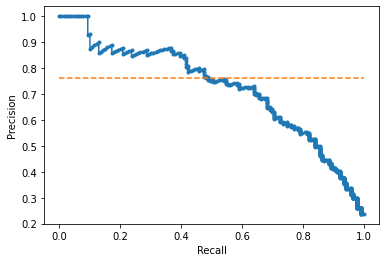

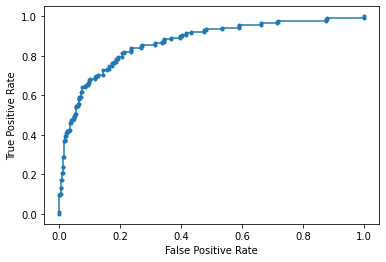

Accuracy: 83.85% Precision: 84.62% Recall: 39.57%
F1: 53.92% AUPRC: 72.37% AUROC: 86.94%
2023-02-07 15:37:17.257019
Fold 8
RCI mean derived from training set: -1.278800849303568
RCI threshold derived from training set: 0
FIT
2023-02-07 15:37:20.028854
PREDICT
2023-02-07 15:37:31.011997


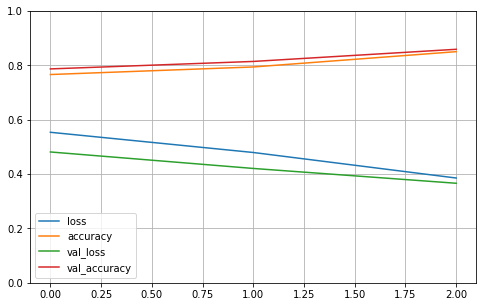

Train set ones/size 1222 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 124 / 582
Range of scores: 0.0002403134 to 0.9532592
Score threshold 0.5
Prediction set ones/size 52 / 582


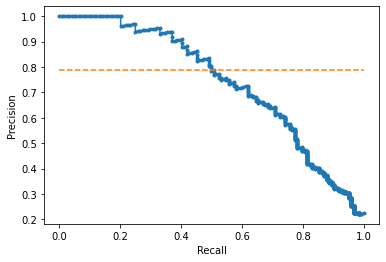

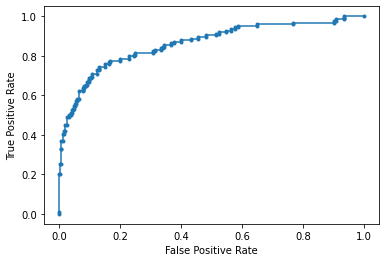

Accuracy: 85.91% Precision: 90.38% Recall: 37.90%
F1: 53.41% AUPRC: 74.01% AUROC: 86.23%
2023-02-07 15:37:31.643811
Fold 9
RCI mean derived from training set: -1.2968693947910706
RCI threshold derived from training set: 0
FIT
2023-02-07 15:37:34.398784
PREDICT
2023-02-07 15:37:40.476323


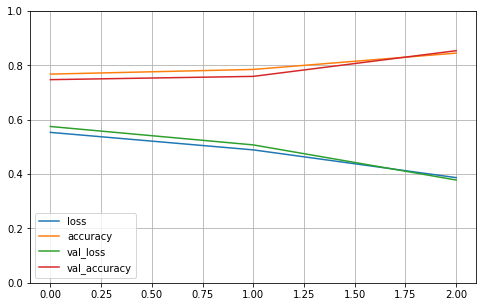

Train set ones/size 1199 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 147 / 582
Range of scores: 0.0030620208 to 0.9824646
Score threshold 0.5
Prediction set ones/size 126 / 582


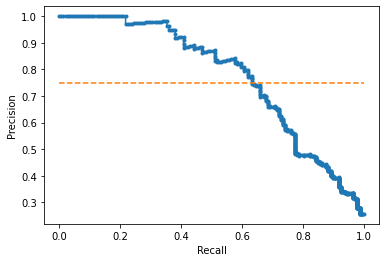

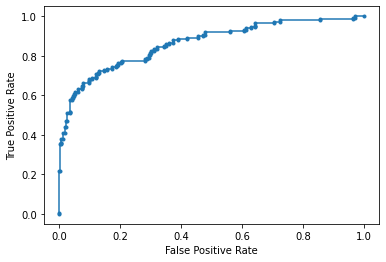

Accuracy: 85.40% Precision: 74.60% Recall: 63.95%
F1: 68.86% AUPRC: 77.46% AUROC: 86.36%
2023-02-07 15:37:41.107166
Fold 10
RCI mean derived from training set: -1.2907133534439992
RCI threshold derived from training set: 0
FIT
2023-02-07 15:37:43.865925
PREDICT
2023-02-07 15:37:49.580092


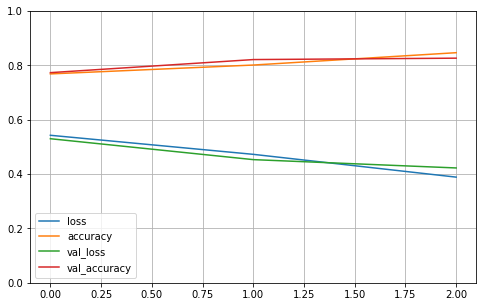

Train set ones/size 1199 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 147 / 582
Range of scores: 0.0029409581 to 0.9589533
Score threshold 0.5
Prediction set ones/size 60 / 582


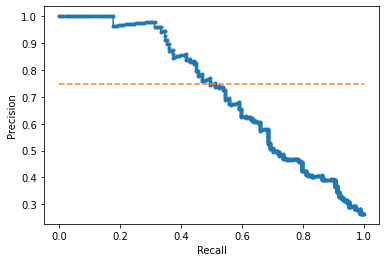

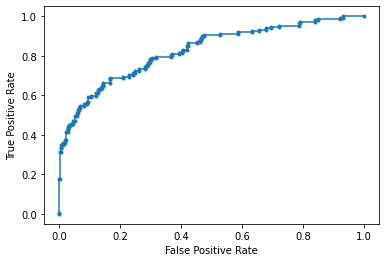

Accuracy: 82.65% Precision: 88.33% Recall: 36.05%
F1: 51.21% AUPRC: 71.64% AUROC: 82.74%
2023-02-07 15:37:50.445573

Completed cross validation 10 folds 3 epochs
 accuracy mean 84.32% +/- 2.30
 precision mean 82.83% +/- 9.66
 recall mean 42.68% +/- 16.50
 F1 mean 53.76% +/- 14.91
 AUPRC mean 73.26% +/- 4.66
 AUROC mean 85.48% +/- 2.84
Finished cell Line 2 HeLa.S3

2023-02-07 15:37:51.886595
Start cell Line 3 HepG2
Number of RCI values loaded 1362
Num RCI: 1362
Load sequence...
Cross validation...
2023-02-07 15:38:04.556600
splitting
Fold 1
RCI mean derived from training set: -1.0839654720302832
RCI threshold derived from training set: 0
FIT
2023-02-07 15:38:07.345011
PREDICT
2023-02-07 15:38:15.326307


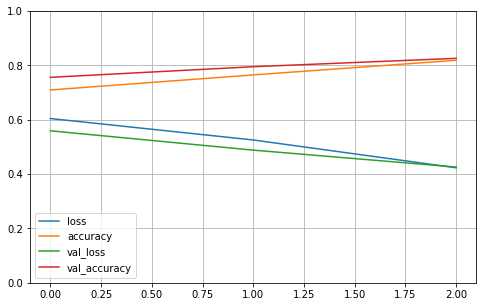

Train set ones/size 2149 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 237 / 844
Range of scores: 0.0033413502 to 0.98751706
Score threshold 0.5
Prediction set ones/size 148 / 844


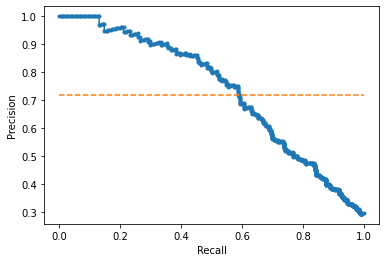

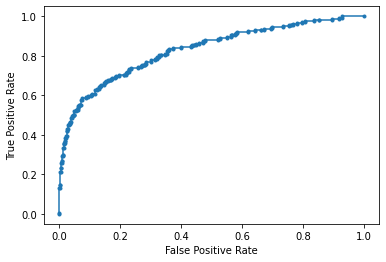

Accuracy: 82.58% Precision: 80.41% Recall: 50.21%
F1: 61.82% AUPRC: 73.45% AUROC: 82.94%
2023-02-07 15:38:15.965970
Fold 2
RCI mean derived from training set: -1.0801516686556945
RCI threshold derived from training set: 0
FIT
2023-02-07 15:38:20.165606
PREDICT
2023-02-07 15:38:31.430188


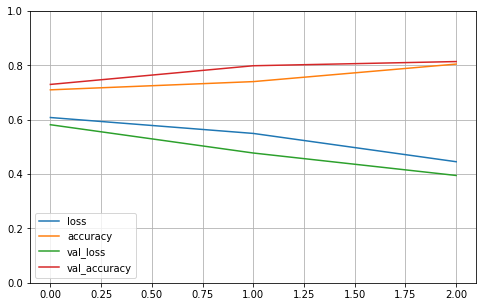

Train set ones/size 2155 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 231 / 844
Range of scores: 0.006362962 to 0.97332686
Score threshold 0.5
Prediction set ones/size 112 / 844


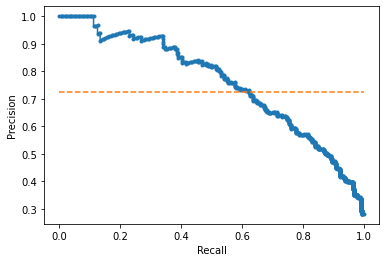

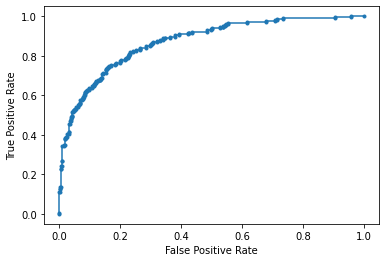

Accuracy: 81.40% Precision: 83.04% Recall: 40.26%
F1: 54.23% AUPRC: 75.96% AUROC: 87.20%
2023-02-07 15:38:32.067783
Fold 3
RCI mean derived from training set: -1.0755342854325212
RCI threshold derived from training set: 0
FIT
2023-02-07 15:38:35.547275
PREDICT
2023-02-07 15:38:43.897887


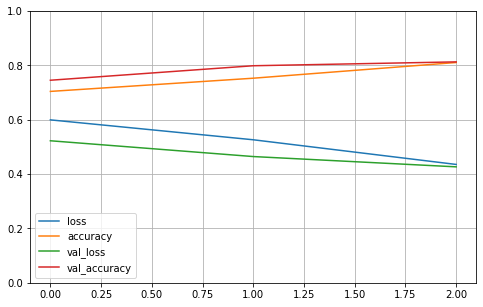

Train set ones/size 2160 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 226 / 844
Range of scores: 0.0034482004 to 0.9866985
Score threshold 0.5
Prediction set ones/size 148 / 844


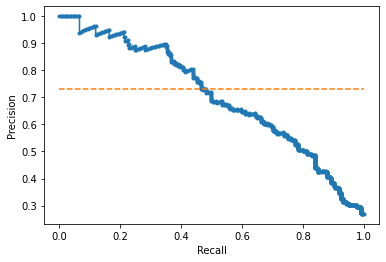

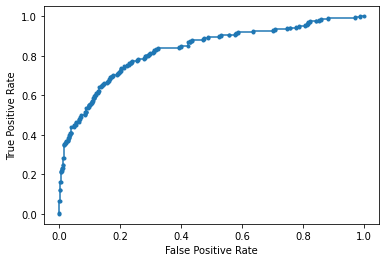

Accuracy: 81.28% Precision: 72.97% Recall: 47.79%
F1: 57.75% AUPRC: 70.56% AUROC: 82.91%
2023-02-07 15:38:44.512702
Fold 4
RCI mean derived from training set: -1.07985061436208
RCI threshold derived from training set: 0
FIT
2023-02-07 15:38:48.010934
PREDICT
2023-02-07 15:38:56.290954


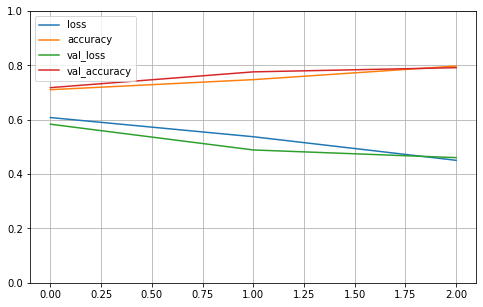

Train set ones/size 2149 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 237 / 844
Range of scores: 0.010499653 to 0.9884878
Score threshold 0.5
Prediction set ones/size 237 / 844


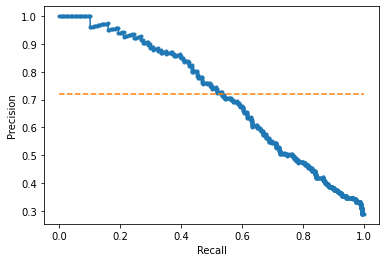

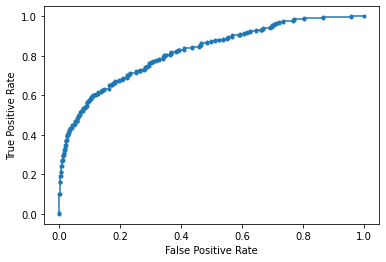

Accuracy: 79.15% Precision: 62.87% Recall: 62.87%
F1: 62.87% AUPRC: 71.41% AUROC: 82.18%
2023-02-07 15:38:57.170223
Fold 5
RCI mean derived from training set: -1.0818529347004608
RCI threshold derived from training set: 0
FIT
2023-02-07 15:39:00.749506
PREDICT
2023-02-07 15:39:12.014754


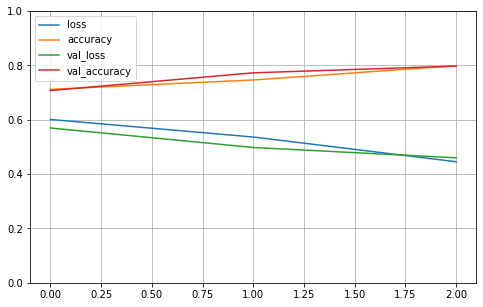

Train set ones/size 2139 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 247 / 844
Range of scores: 0.0023864077 to 0.9535664
Score threshold 0.5
Prediction set ones/size 98 / 844


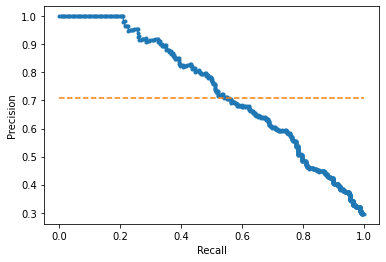

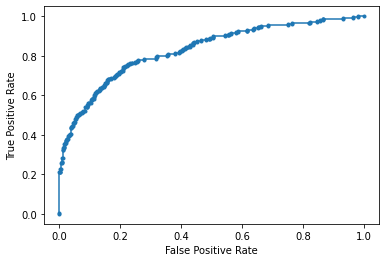

Accuracy: 79.74% Precision: 88.78% Recall: 35.22%
F1: 50.43% AUPRC: 73.73% AUROC: 82.97%
2023-02-07 15:39:12.655936
Fold 6
RCI mean derived from training set: -1.0809142119407504
RCI threshold derived from training set: 0
FIT
2023-02-07 15:39:16.114852
PREDICT
2023-02-07 15:39:27.369808


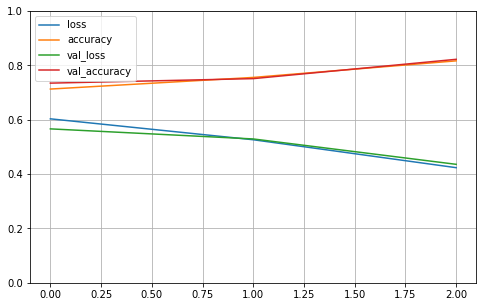

Train set ones/size 2142 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 244 / 844
Range of scores: 0.0023673591 to 0.96545804
Score threshold 0.5
Prediction set ones/size 116 / 844


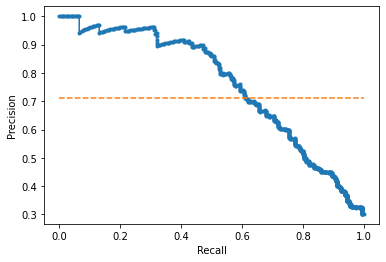

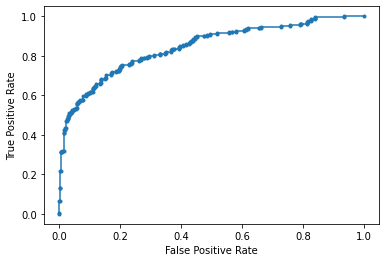

Accuracy: 82.23% Precision: 90.52% Recall: 43.03%
F1: 58.33% AUPRC: 75.94% AUROC: 84.52%
2023-02-07 15:39:28.006600
Fold 7
RCI mean derived from training set: -1.0826895800434497
RCI threshold derived from training set: 0
FIT
2023-02-07 15:39:31.508976
PREDICT
2023-02-07 15:39:42.780133


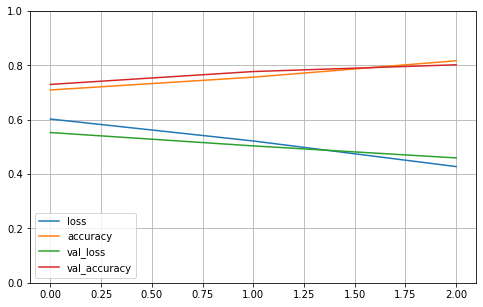

Train set ones/size 2157 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 229 / 844
Range of scores: 0.0033574477 to 0.977852
Score threshold 0.5
Prediction set ones/size 170 / 844


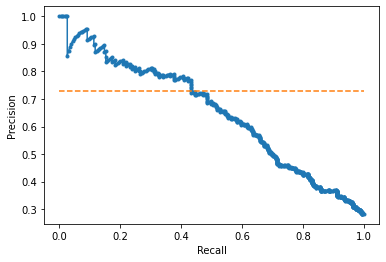

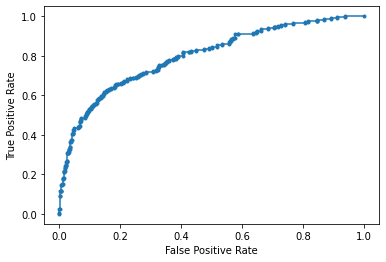

Accuracy: 80.21% Precision: 68.24% Recall: 50.66%
F1: 58.15% AUPRC: 65.20% AUROC: 79.87%
2023-02-07 15:39:43.429873
Fold 8
RCI mean derived from training set: -1.0882789068571428
RCI threshold derived from training set: 0
FIT
2023-02-07 15:39:47.337226
PREDICT
2023-02-07 15:39:55.770939


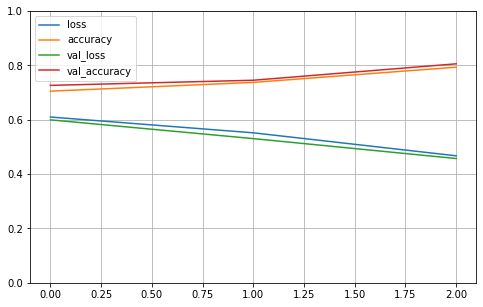

Train set ones/size 2140 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 246 / 844
Range of scores: 0.011824983 to 0.95766675
Score threshold 0.5
Prediction set ones/size 126 / 844


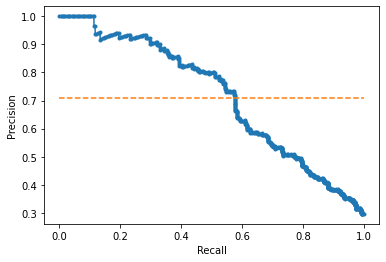

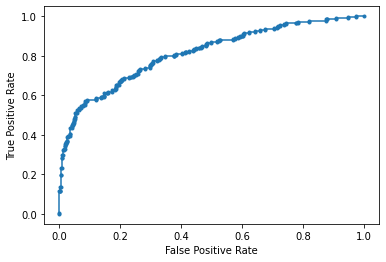

Accuracy: 80.57% Precision: 82.54% Recall: 42.28%
F1: 55.91% AUPRC: 71.57% AUROC: 81.28%
2023-02-07 15:39:56.408654
Fold 9
RCI mean derived from training set: -1.0822446985661618
RCI threshold derived from training set: 0
FIT
2023-02-07 15:40:00.061277
PREDICT
2023-02-07 15:40:08.523793


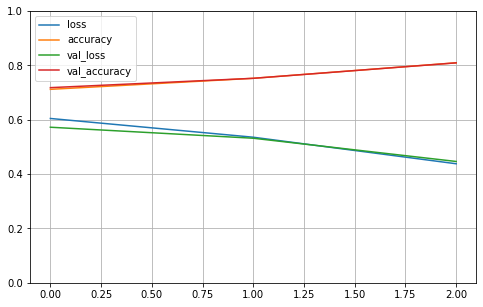

Train set ones/size 2148 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 238 / 844
Range of scores: 0.0025738925 to 0.97764564
Score threshold 0.5
Prediction set ones/size 121 / 844


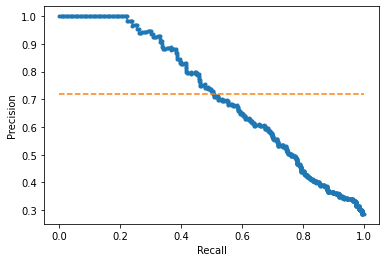

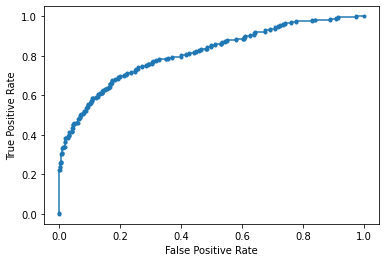

Accuracy: 80.92% Precision: 81.82% Recall: 41.60%
F1: 55.15% AUPRC: 71.83% AUROC: 81.25%
2023-02-07 15:40:09.169903
Fold 10
RCI mean derived from training set: -1.0828875017048445
RCI threshold derived from training set: 0
FIT
2023-02-07 15:40:12.681854
PREDICT
2023-02-07 15:40:21.183366


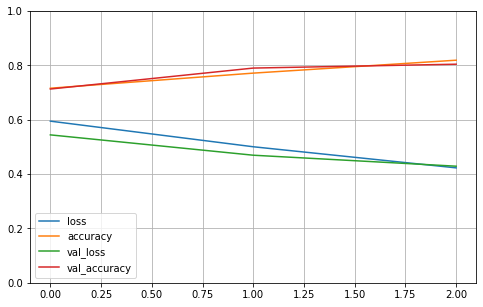

Train set ones/size 2135 / 7596
Compute valiation accuracy
Valid sizes (843, 4997) (843,)
Valid set ones/size 251 / 843
Range of scores: 0.0021683748 to 0.98877394
Score threshold 0.5
Prediction set ones/size 196 / 843


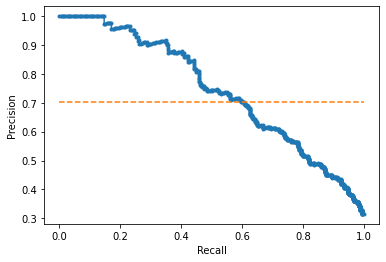

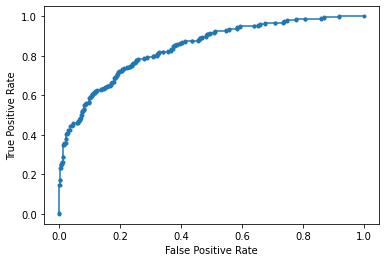

Accuracy: 80.43% Precision: 71.94% Recall: 56.18%
F1: 63.09% AUPRC: 74.38% AUROC: 84.11%
2023-02-07 15:40:21.821968

Completed cross validation 10 folds 3 epochs
 accuracy mean 80.85% +/- 1.06
 precision mean 78.31% +/- 8.97
 recall mean 47.01% +/- 8.24
 F1 mean 57.77% +/- 4.05
 AUPRC mean 72.40% +/- 3.15
 AUROC mean 82.92% +/- 2.05
Finished cell Line 3 HepG2

2023-02-07 15:40:23.203039
Start cell Line 4 HT1080
Number of RCI values loaded 936
Num RCI: 936
Load sequence...
Cross validation...
2023-02-07 15:40:34.668447
splitting
Fold 1
RCI mean derived from training set: -0.2837299268113891
RCI threshold derived from training set: 0
FIT
2023-02-07 15:40:36.515739
PREDICT
2023-02-07 15:40:47.755917


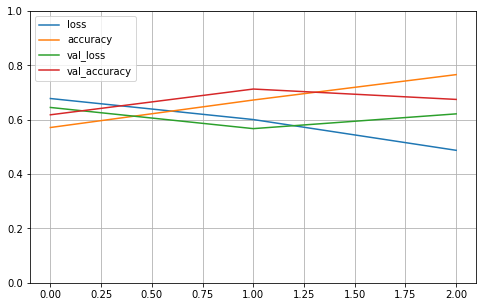

Train set ones/size 2800 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 311 / 707
Range of scores: 0.0046315137 to 0.9991714
Score threshold 0.5
Prediction set ones/size 477 / 707


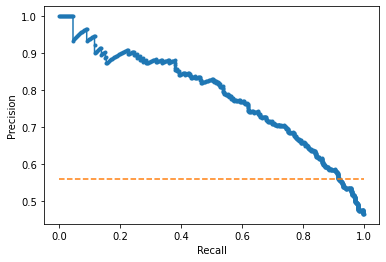

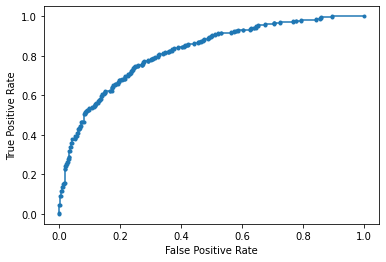

Accuracy: 67.47% Precision: 58.49% Recall: 89.71%
F1: 70.81% AUPRC: 78.45% AUROC: 82.01%
2023-02-07 15:40:48.389035
Fold 2
RCI mean derived from training set: -0.2753148000880919
RCI threshold derived from training set: 0
FIT
2023-02-07 15:40:51.562463
PREDICT
2023-02-07 15:40:58.759517


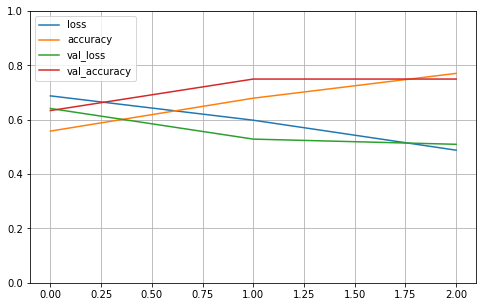

Train set ones/size 2806 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 305 / 707
Range of scores: 0.005000654 to 0.9966522
Score threshold 0.5
Prediction set ones/size 418 / 707


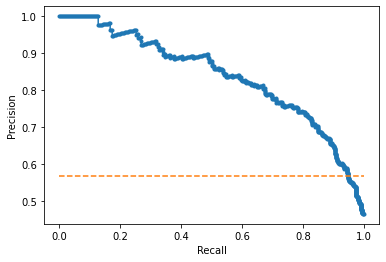

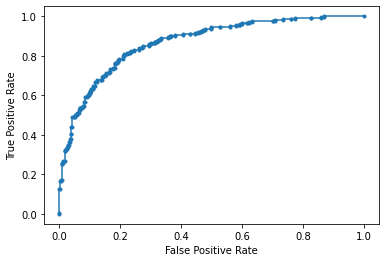

Accuracy: 74.96% Precision: 65.31% Recall: 89.51%
F1: 75.52% AUPRC: 83.85% AUROC: 86.74%
2023-02-07 15:40:59.409168
Fold 3
RCI mean derived from training set: -0.2789730485228881
RCI threshold derived from training set: 0
FIT
2023-02-07 15:41:02.509367
PREDICT
2023-02-07 15:41:13.683456


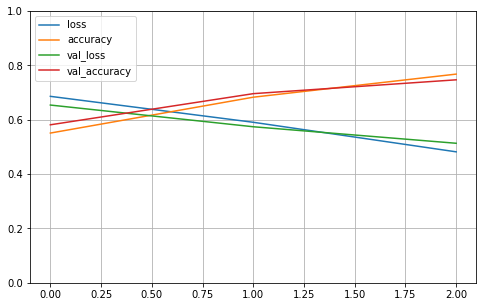

Train set ones/size 2804 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 307 / 707
Range of scores: 0.0024792855 to 0.98735714
Score threshold 0.5
Prediction set ones/size 392 / 707


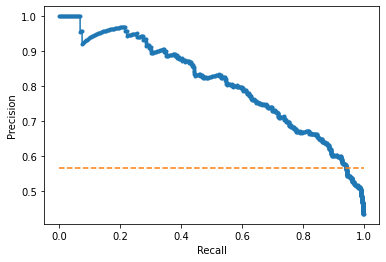

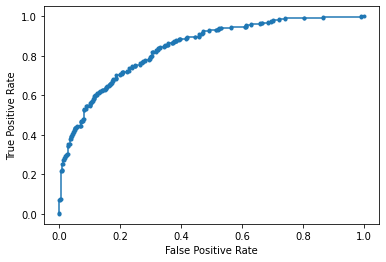

Accuracy: 74.68% Precision: 66.33% Recall: 84.69%
F1: 74.39% AUPRC: 80.90% AUROC: 84.13%
2023-02-07 15:41:14.324018
Fold 4
RCI mean derived from training set: -0.2888440364338524
RCI threshold derived from training set: 0
FIT
2023-02-07 15:41:17.419552
PREDICT
2023-02-07 15:41:28.618539


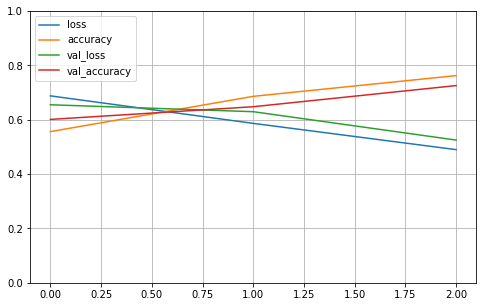

Train set ones/size 2780 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 331 / 707
Range of scores: 0.0025250257 to 0.9903654
Score threshold 0.5
Prediction set ones/size 309 / 707


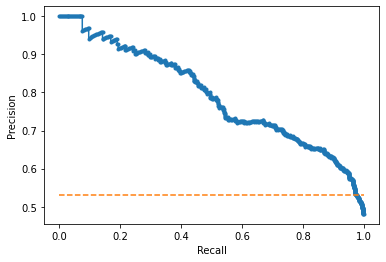

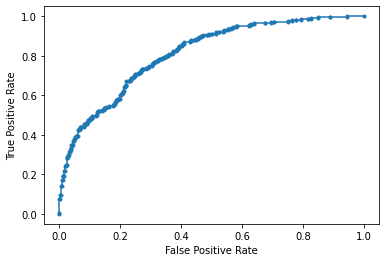

Accuracy: 72.56% Precision: 72.17% Recall: 67.37%
F1: 69.69% AUPRC: 79.30% AUROC: 81.14%
2023-02-07 15:41:29.222155
Fold 5
RCI mean derived from training set: -0.2832924759452658
RCI threshold derived from training set: 0
FIT
2023-02-07 15:41:32.373438
PREDICT
2023-02-07 15:41:39.826195


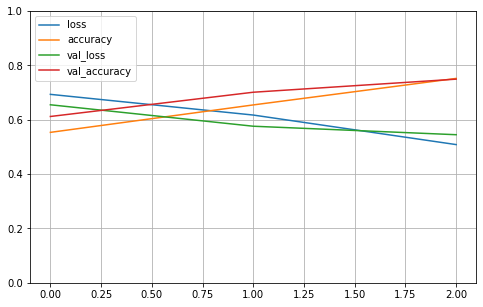

Train set ones/size 2795 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 316 / 706
Range of scores: 0.0019942361 to 0.9852798
Score threshold 0.5
Prediction set ones/size 253 / 706


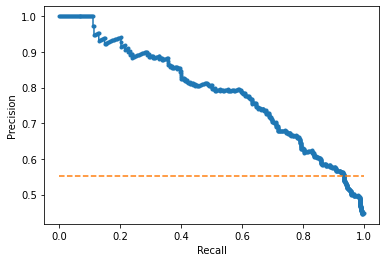

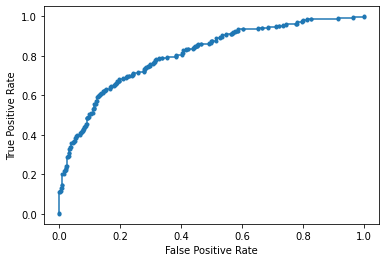

Accuracy: 74.93% Precision: 77.47% Recall: 62.03%
F1: 68.89% AUPRC: 78.68% AUROC: 80.80%
2023-02-07 15:41:40.471002
Fold 6
RCI mean derived from training set: -0.28163197472161056
RCI threshold derived from training set: 0
FIT
2023-02-07 15:41:43.626293
PREDICT
2023-02-07 15:41:54.808088


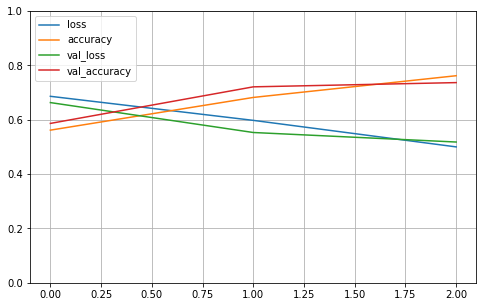

Train set ones/size 2798 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 313 / 706
Range of scores: 0.004437357 to 0.9828692
Score threshold 0.5
Prediction set ones/size 251 / 706


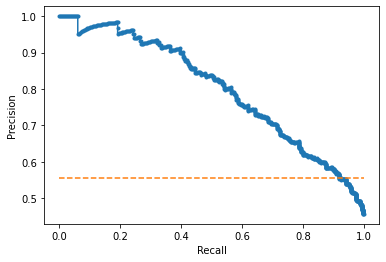

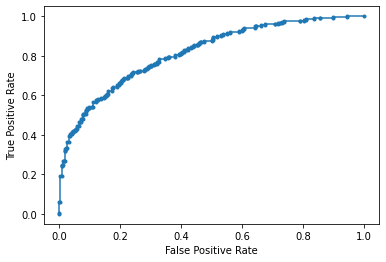

Accuracy: 73.65% Precision: 75.30% Recall: 60.38%
F1: 67.02% AUPRC: 80.11% AUROC: 81.70%
2023-02-07 15:41:55.422919
Fold 7
RCI mean derived from training set: -0.28862815410978293
RCI threshold derived from training set: 0
FIT
2023-02-07 15:41:58.569973
PREDICT
2023-02-07 15:42:05.921517


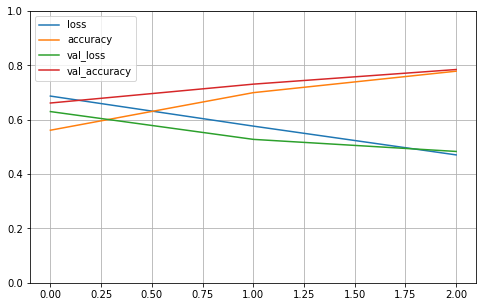

Train set ones/size 2787 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 324 / 706
Range of scores: 0.0056705987 to 0.99809617
Score threshold 0.5
Prediction set ones/size 350 / 706


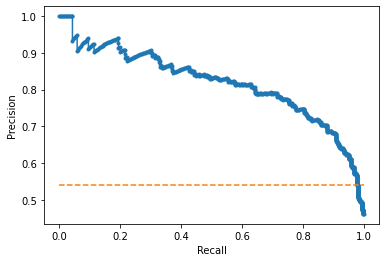

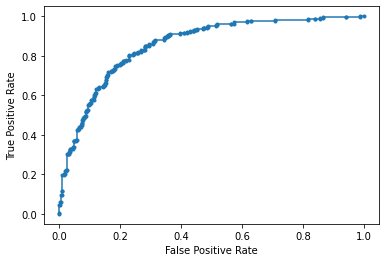

Accuracy: 78.47% Precision: 74.57% Recall: 80.56%
F1: 77.45% AUPRC: 81.92% AUROC: 85.58%
2023-02-07 15:42:06.516864
Fold 8
RCI mean derived from training set: -0.28006548551116706
RCI threshold derived from training set: 0
FIT
2023-02-07 15:42:09.637909
PREDICT
2023-02-07 15:42:16.832837


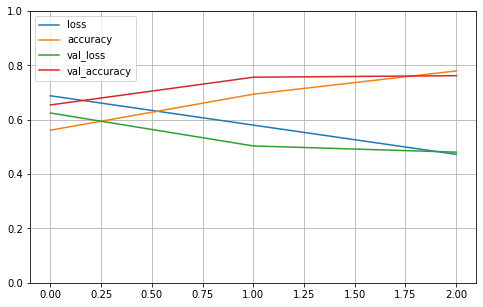

Train set ones/size 2820 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 291 / 706
Range of scores: 0.0012248778 to 0.99775404
Score threshold 0.5
Prediction set ones/size 361 / 706


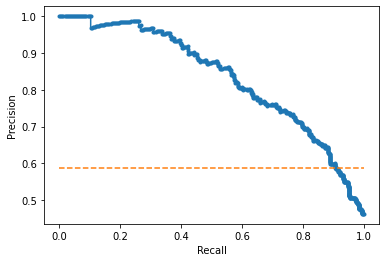

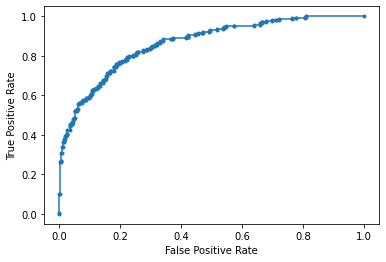

Accuracy: 76.20% Precision: 67.04% Recall: 83.16%
F1: 74.23% AUPRC: 83.50% AUROC: 86.40%
2023-02-07 15:42:17.481294
Fold 9
RCI mean derived from training set: -0.28685858487889276
RCI threshold derived from training set: 0
FIT
2023-02-07 15:42:20.616107
PREDICT
2023-02-07 15:42:31.836752


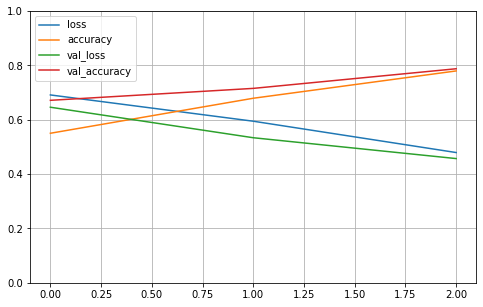

Train set ones/size 2806 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 305 / 706
Range of scores: 0.0029605702 to 0.9841388
Score threshold 0.5
Prediction set ones/size 303 / 706


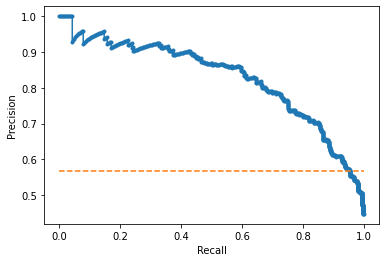

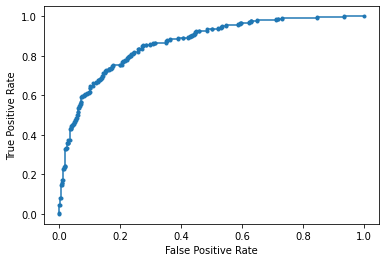

Accuracy: 78.75% Precision: 75.58% Recall: 75.08%
F1: 75.33% AUPRC: 82.91% AUROC: 86.55%
2023-02-07 15:42:32.460658
Fold 10
RCI mean derived from training set: -0.28572198597986787
RCI threshold derived from training set: 0
FIT
2023-02-07 15:42:35.591434
PREDICT
2023-02-07 15:42:46.777121


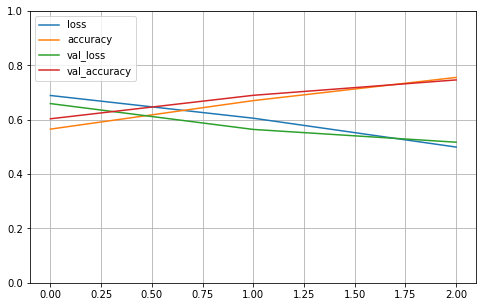

Train set ones/size 2803 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 308 / 706
Range of scores: 0.0033133817 to 0.98646486
Score threshold 0.5
Prediction set ones/size 221 / 706


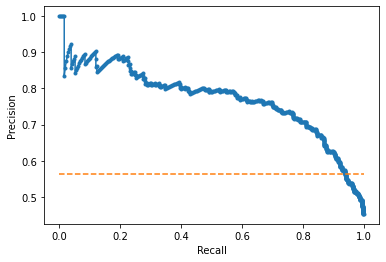

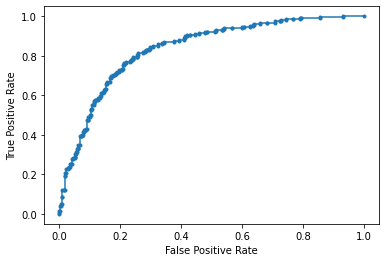

Accuracy: 74.65% Precision: 79.19% Recall: 56.82%
F1: 66.16% AUPRC: 77.27% AUROC: 83.55%
2023-02-07 15:42:47.406592

Completed cross validation 10 folds 3 epochs
 accuracy mean 74.63% +/- 3.18
 precision mean 71.14% +/- 6.57
 recall mean 74.93% +/- 12.42
 F1 mean 71.95% +/- 3.93
 AUPRC mean 80.69% +/- 2.29
 AUROC mean 83.86% +/- 2.36
Finished cell Line 4 HT1080

2023-02-07 15:42:48.760270
Start cell Line 5 HUVEC
Number of RCI values loaded 1488
Num RCI: 1488
Load sequence...
Cross validation...
2023-02-07 15:43:03.923366
splitting
Fold 1
RCI mean derived from training set: -0.9598692552699883
RCI threshold derived from training set: 0
FIT
2023-02-07 15:43:07.304061
PREDICT
2023-02-07 15:43:16.508435


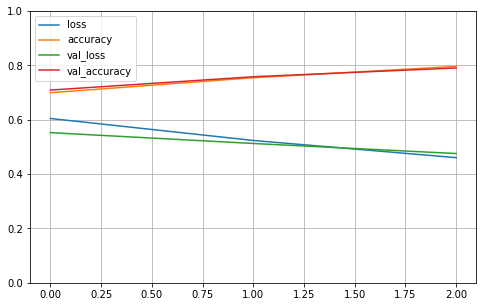

Train set ones/size 2524 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 287 / 959
Range of scores: 0.0029702685 to 0.93447256
Score threshold 0.5
Prediction set ones/size 106 / 959


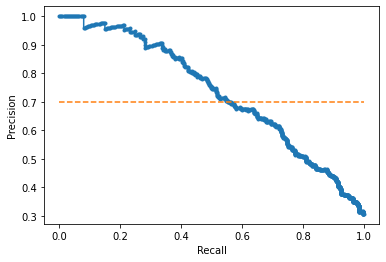

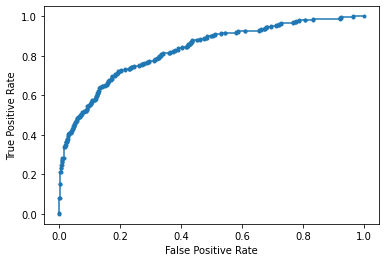

Accuracy: 79.04% Precision: 90.57% Recall: 33.45%
F1: 48.85% AUPRC: 73.31% AUROC: 82.97%
2023-02-07 15:43:17.166706
Fold 2
RCI mean derived from training set: -0.9636234434704518
RCI threshold derived from training set: 0
FIT
2023-02-07 15:43:22.414232
PREDICT
2023-02-07 15:43:33.750369


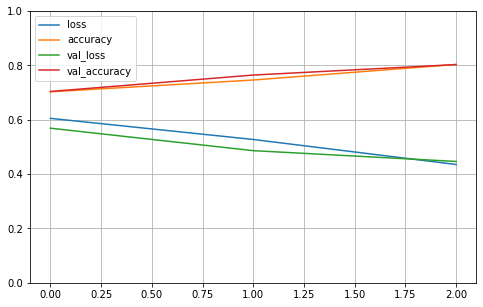

Train set ones/size 2525 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 286 / 959
Range of scores: 0.0026541397 to 0.9683025
Score threshold 0.5
Prediction set ones/size 151 / 959


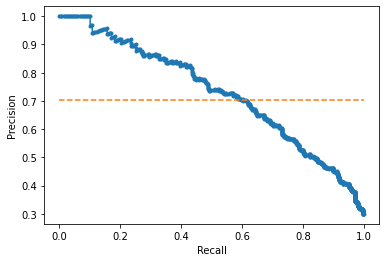

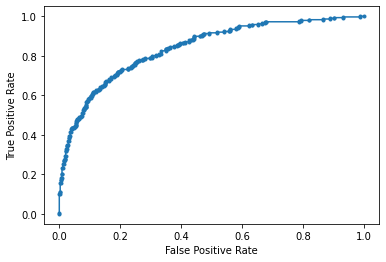

Accuracy: 80.29% Precision: 82.12% Recall: 43.36%
F1: 56.75% AUPRC: 73.03% AUROC: 83.94%
2023-02-07 15:43:34.408227
Fold 3
RCI mean derived from training set: -0.9593738715434531
RCI threshold derived from training set: 0
FIT
2023-02-07 15:43:38.199970
PREDICT
2023-02-07 15:43:47.654297


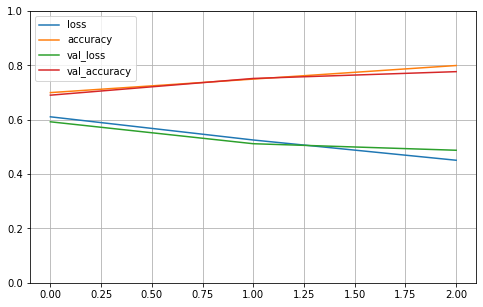

Train set ones/size 2513 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 298 / 959
Range of scores: 0.0071622594 to 0.9847317
Score threshold 0.5
Prediction set ones/size 284 / 959


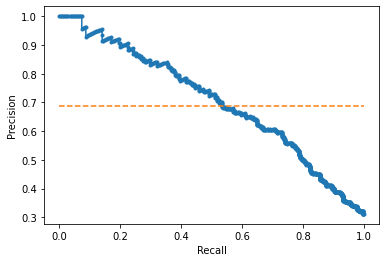

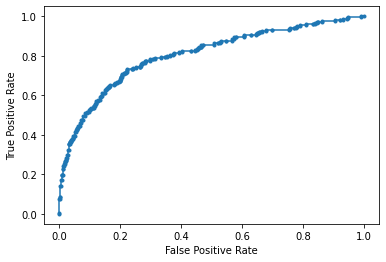

Accuracy: 77.69% Precision: 64.79% Recall: 61.74%
F1: 63.23% AUPRC: 70.43% AUROC: 80.52%
2023-02-07 15:43:48.309167
Fold 4
RCI mean derived from training set: -0.9491514312294321
RCI threshold derived from training set: 0
FIT
2023-02-07 15:43:52.142041
PREDICT
2023-02-07 15:44:01.513167


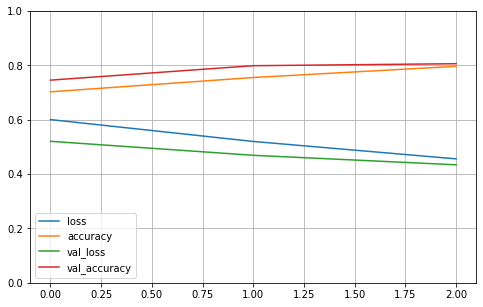

Train set ones/size 2548 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 263 / 959
Range of scores: 0.00026865874 to 0.97711253
Score threshold 0.5
Prediction set ones/size 123 / 959


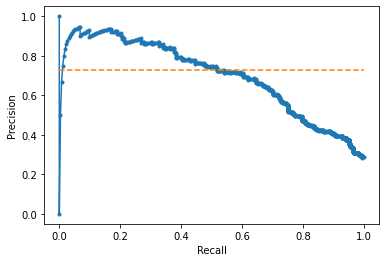

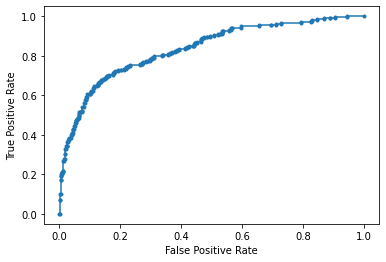

Accuracy: 80.60% Precision: 81.30% Recall: 38.02%
F1: 51.81% AUPRC: 69.76% AUROC: 83.53%
2023-02-07 15:44:02.178320
Fold 5
RCI mean derived from training set: -0.96778603597219
RCI threshold derived from training set: 0
FIT
2023-02-07 15:44:06.018645
PREDICT
2023-02-07 15:44:17.378721


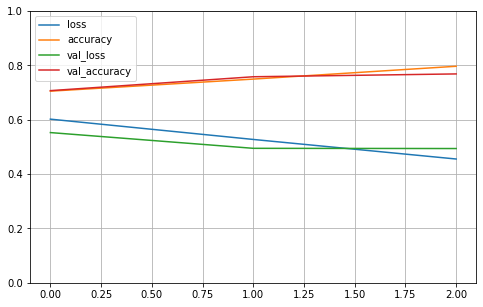

Train set ones/size 2512 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 299 / 959
Range of scores: 0.0036479342 to 0.9255476
Score threshold 0.5
Prediction set ones/size 95 / 959


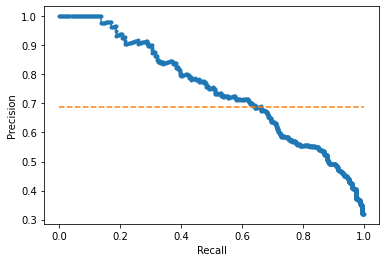

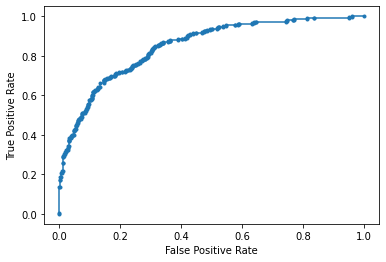

Accuracy: 76.85% Precision: 90.53% Recall: 28.76%
F1: 43.65% AUPRC: 74.76% AUROC: 84.91%
2023-02-07 15:44:18.034800
Fold 6
RCI mean derived from training set: -0.9634300983429895
RCI threshold derived from training set: 0
FIT
2023-02-07 15:44:21.873096
PREDICT
2023-02-07 15:44:33.212764


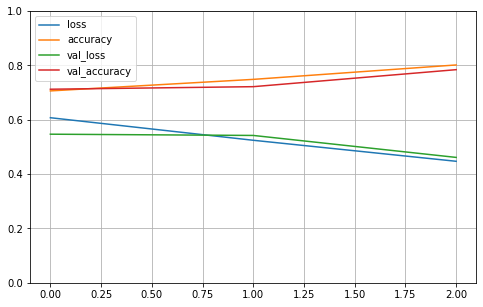

Train set ones/size 2533 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 278 / 959
Range of scores: 2.5170271e-05 to 0.92012906
Score threshold 0.5
Prediction set ones/size 105 / 959


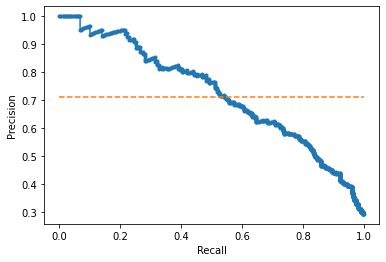

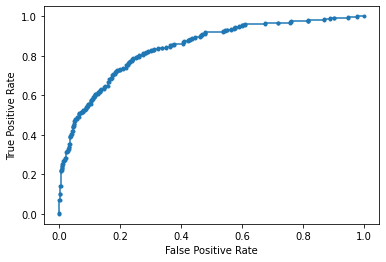

Accuracy: 78.42% Precision: 83.81% Recall: 31.65%
F1: 45.95% AUPRC: 72.49% AUROC: 84.28%
2023-02-07 15:44:33.857416
Fold 7
RCI mean derived from training set: -0.9433161291993047
RCI threshold derived from training set: 0
FIT
2023-02-07 15:44:38.268768
PREDICT
2023-02-07 15:44:49.982313


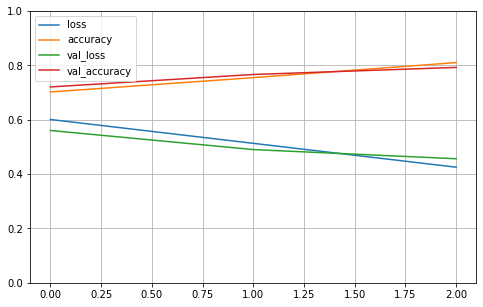

Train set ones/size 2531 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 280 / 959
Range of scores: 0.0059529026 to 0.99205667
Score threshold 0.5
Prediction set ones/size 271 / 959


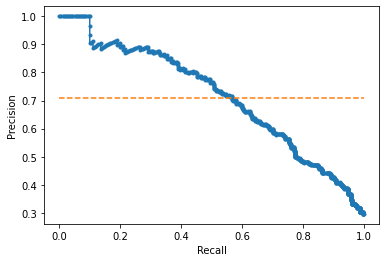

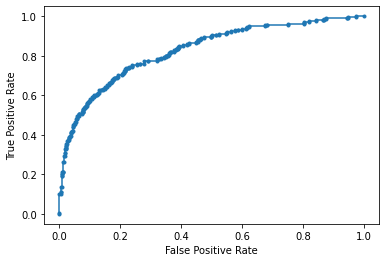

Accuracy: 79.25% Precision: 64.94% Recall: 62.86%
F1: 63.88% AUPRC: 71.48% AUROC: 82.82%
2023-02-07 15:44:50.887072
Fold 8
RCI mean derived from training set: -0.951527679225956
RCI threshold derived from training set: 0
FIT
2023-02-07 15:44:55.113060
PREDICT
2023-02-07 15:45:06.467739


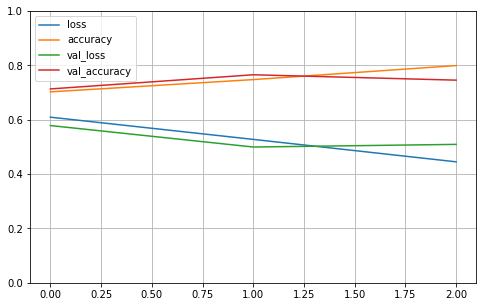

Train set ones/size 2539 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 272 / 959
Range of scores: 0.0021836783 to 0.9953316
Score threshold 0.5
Prediction set ones/size 338 / 959


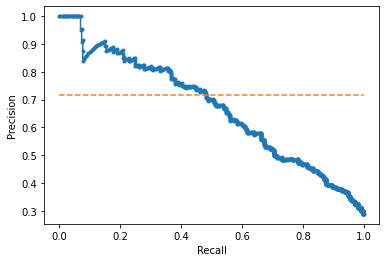

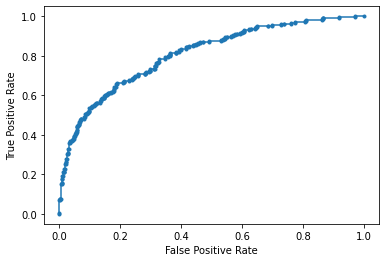

Accuracy: 74.56% Precision: 54.14% Recall: 67.28%
F1: 60.00% AUPRC: 67.01% AUROC: 80.81%
2023-02-07 15:45:07.110489
Fold 9
RCI mean derived from training set: -0.9602096008389339
RCI threshold derived from training set: 0
FIT
2023-02-07 15:45:10.905183
PREDICT
2023-02-07 15:45:20.330804


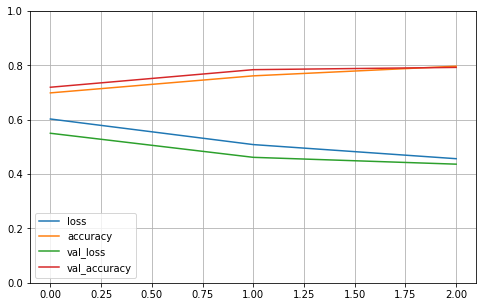

Train set ones/size 2540 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 271 / 959
Range of scores: 0.0041494993 to 0.964131
Score threshold 0.5
Prediction set ones/size 220 / 959


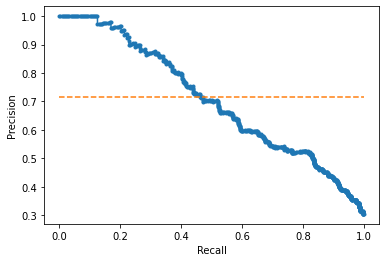

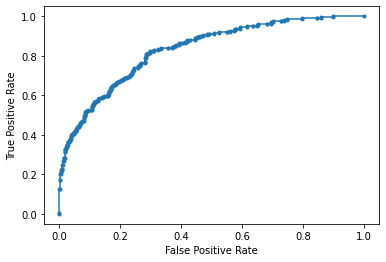

Accuracy: 79.25% Precision: 66.36% Recall: 53.87%
F1: 59.47% AUPRC: 70.71% AUROC: 83.17%
2023-02-07 15:45:20.963887
Fold 10
RCI mean derived from training set: -0.9577084034526707
RCI threshold derived from training set: 0
FIT
2023-02-07 15:45:24.803977
PREDICT
2023-02-07 15:45:36.183189


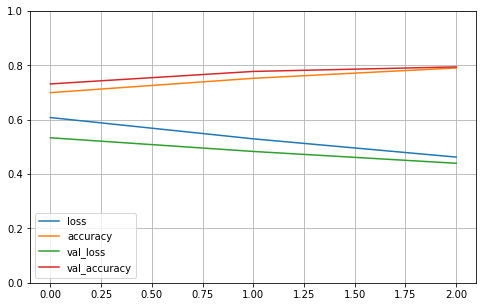

Train set ones/size 2534 / 8631
Compute valiation accuracy
Valid sizes (958, 4997) (958,)
Valid set ones/size 277 / 958
Range of scores: 0.00609387 to 0.97547525
Score threshold 0.5
Prediction set ones/size 196 / 958


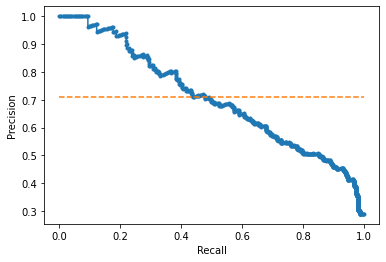

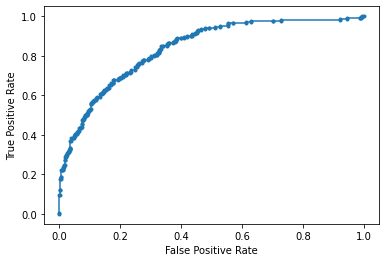

Accuracy: 79.44% Precision: 70.41% Recall: 49.82%
F1: 58.35% AUPRC: 70.71% AUROC: 83.83%
2023-02-07 15:45:36.823779

Completed cross validation 10 folds 3 epochs
 accuracy mean 78.54% +/- 1.79
 precision mean 74.90% +/- 12.42
 recall mean 47.08% +/- 14.07
 F1 mean 55.20% +/- 7.18
 AUPRC mean 71.37% +/- 2.18
 AUROC mean 83.08% +/- 1.42
Finished cell Line 5 HUVEC

2023-02-07 15:45:38.250505
Start cell Line 6 MCF.7
Number of RCI values loaded 2156
Num RCI: 2156
Load sequence...
Cross validation...
2023-02-07 15:45:55.599728
splitting
Fold 1
RCI mean derived from training set: -1.1349753646536942
RCI threshold derived from training set: 0
FIT
2023-02-07 15:46:00.129268
PREDICT
2023-02-07 15:46:11.641109


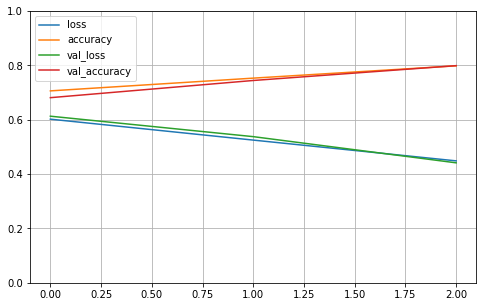

Train set ones/size 2986 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 351 / 1154
Range of scores: 0.0022990536 to 0.991178
Score threshold 0.5
Prediction set ones/size 265 / 1154


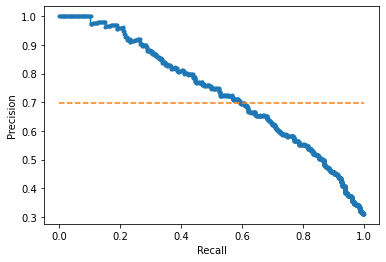

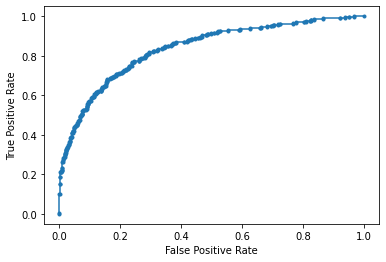

Accuracy: 79.90% Precision: 72.45% Recall: 54.70%
F1: 62.34% AUPRC: 73.63% AUROC: 83.73%
2023-02-07 15:46:12.430165
Fold 2
RCI mean derived from training set: -1.1299156250621327
RCI threshold derived from training set: 0
FIT
2023-02-07 15:46:16.746912
PREDICT
2023-02-07 15:46:28.210644


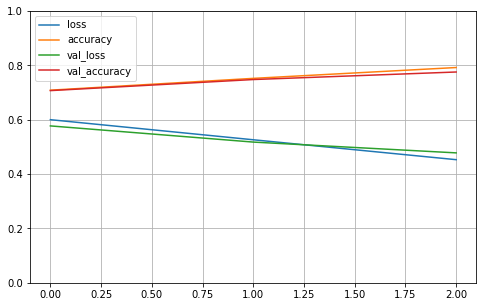

Train set ones/size 2980 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 357 / 1154
Range of scores: 0.0019287466 to 0.9825737
Score threshold 0.5
Prediction set ones/size 150 / 1154


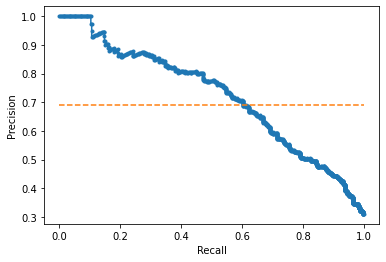

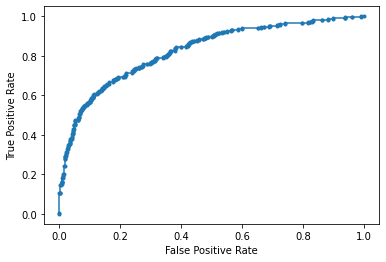

Accuracy: 77.56% Precision: 82.67% Recall: 34.73%
F1: 48.92% AUPRC: 72.17% AUROC: 82.54%
2023-02-07 15:46:29.074998
Fold 3
RCI mean derived from training set: -1.1188958279423948
RCI threshold derived from training set: 0
FIT
2023-02-07 15:46:33.483890
PREDICT
2023-02-07 15:46:44.729026


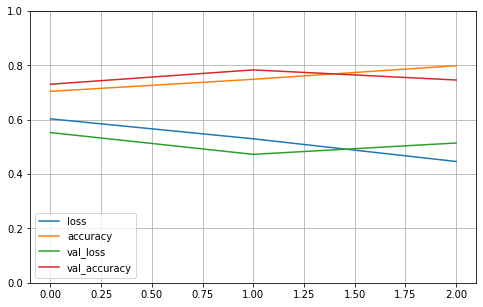

Train set ones/size 3020 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 317 / 1154
Range of scores: 0.014584045 to 0.9891139
Score threshold 0.5
Prediction set ones/size 444 / 1154


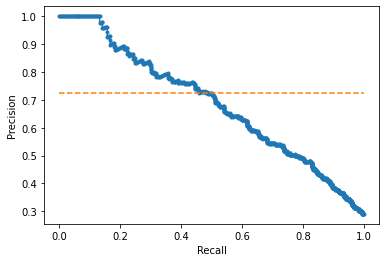

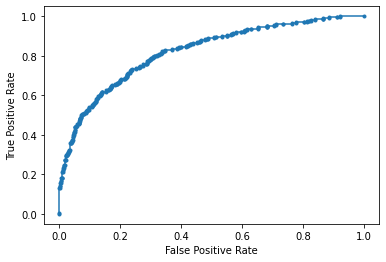

Accuracy: 74.61% Precision: 52.70% Recall: 73.82%
F1: 61.50% AUPRC: 68.70% AUROC: 82.07%
2023-02-07 15:46:45.609285
Fold 4
RCI mean derived from training set: -1.1232048012686637
RCI threshold derived from training set: 0
FIT
2023-02-07 15:46:51.233970
PREDICT
2023-02-07 15:47:02.798837


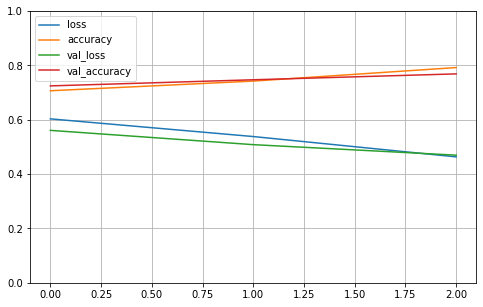

Train set ones/size 3003 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 334 / 1154
Range of scores: 0.0036149998 to 0.9859276
Score threshold 0.5
Prediction set ones/size 241 / 1154


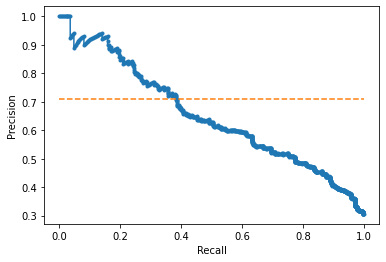

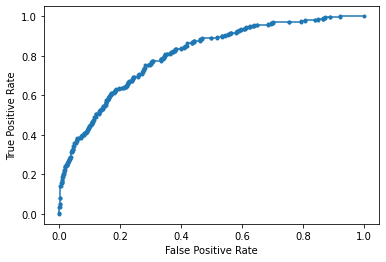

Accuracy: 76.86% Precision: 63.90% Recall: 46.11%
F1: 53.57% AUPRC: 65.30% AUROC: 80.57%
2023-02-07 15:47:03.827994
Fold 5
RCI mean derived from training set: -1.118375560225412
RCI threshold derived from training set: 0
FIT
2023-02-07 15:47:08.319362
PREDICT
2023-02-07 15:47:19.744786


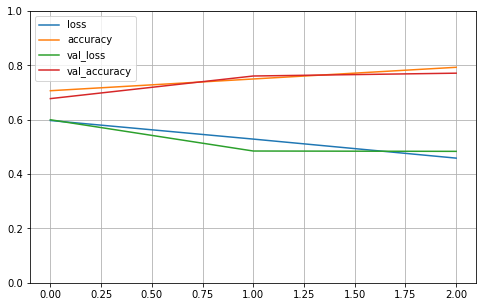

Train set ones/size 2993 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 344 / 1154
Range of scores: 0.0066767377 to 0.98072916
Score threshold 0.5
Prediction set ones/size 392 / 1154


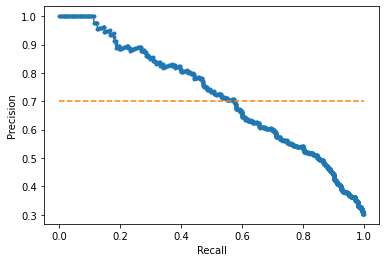

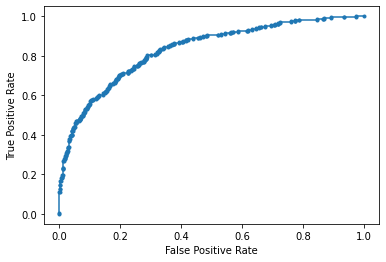

Accuracy: 77.12% Precision: 60.20% Recall: 68.60%
F1: 64.13% AUPRC: 71.93% AUROC: 83.12%
2023-02-07 15:47:20.454852
Fold 6
RCI mean derived from training set: -1.1163208856453477
RCI threshold derived from training set: 0
FIT
2023-02-07 15:47:24.777811
PREDICT
2023-02-07 15:47:35.987922


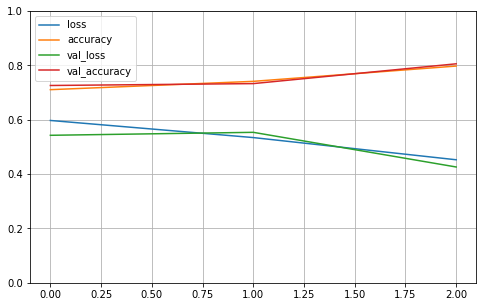

Train set ones/size 3015 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 322 / 1153
Range of scores: 0.0022629749 to 0.98877037
Score threshold 0.5
Prediction set ones/size 178 / 1153


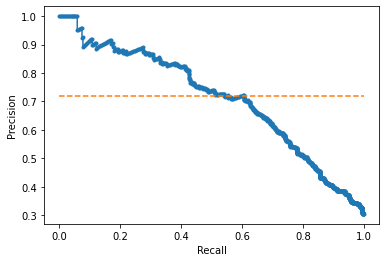

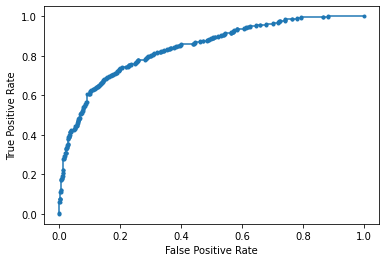

Accuracy: 80.57% Precision: 77.53% Recall: 42.86%
F1: 55.20% AUPRC: 71.15% AUROC: 83.97%
2023-02-07 15:47:36.679716
Fold 7
RCI mean derived from training set: -1.1271018489664804
RCI threshold derived from training set: 0
FIT
2023-02-07 15:47:40.970581
PREDICT
2023-02-07 15:47:52.749026


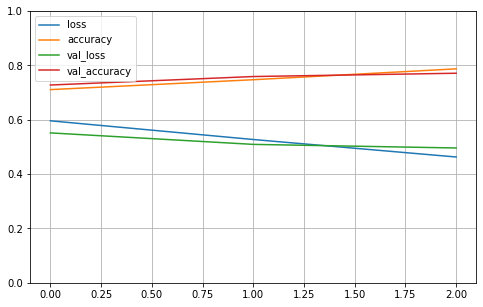

Train set ones/size 3013 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 324 / 1153
Range of scores: 0.00013427065 to 0.99540955
Score threshold 0.5
Prediction set ones/size 288 / 1153


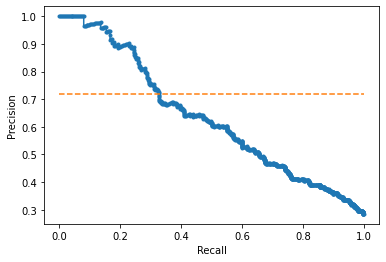

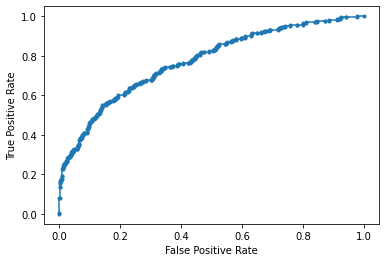

Accuracy: 77.10% Precision: 60.42% Recall: 53.70%
F1: 56.86% AUPRC: 63.55% AUROC: 77.24%
2023-02-07 15:47:53.624527
Fold 8
RCI mean derived from training set: -1.1243382103515702
RCI threshold derived from training set: 0
FIT
2023-02-07 15:47:58.941187
PREDICT
2023-02-07 15:48:10.438550


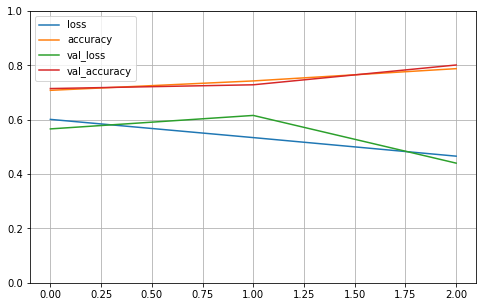

Train set ones/size 3005 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 332 / 1153
Range of scores: 0.003019238 to 0.9840566
Score threshold 0.5
Prediction set ones/size 147 / 1153


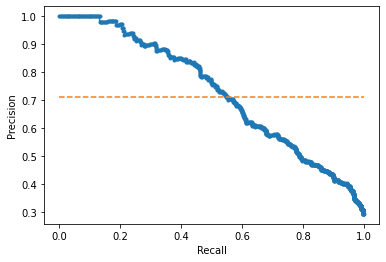

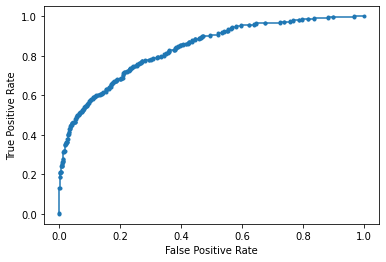

Accuracy: 80.14% Precision: 85.03% Recall: 37.65%
F1: 52.19% AUPRC: 73.00% AUROC: 83.58%
2023-02-07 15:48:11.150529
Fold 9
RCI mean derived from training set: -1.1209396478010016
RCI threshold derived from training set: 0
FIT
2023-02-07 15:48:15.482279
PREDICT
2023-02-07 15:48:26.951097


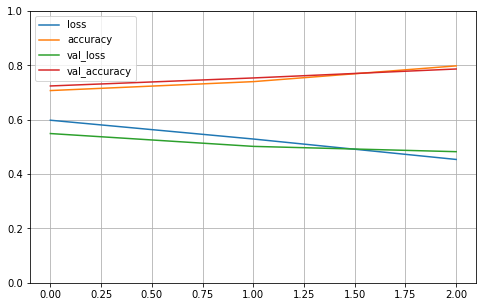

Train set ones/size 3010 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 327 / 1153
Range of scores: 0.0008049714 to 0.97277594
Score threshold 0.5
Prediction set ones/size 155 / 1153


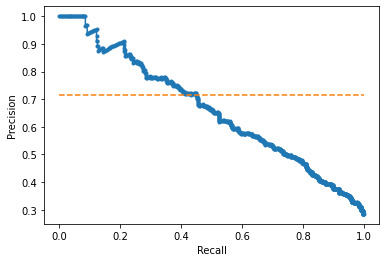

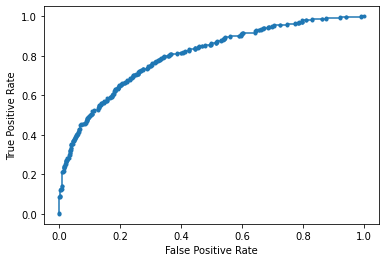

Accuracy: 78.66% Precision: 76.13% Recall: 36.09%
F1: 48.96% AUPRC: 66.36% AUROC: 80.14%
2023-02-07 15:48:27.657827
Fold 10
RCI mean derived from training set: -1.1235682388817185
RCI threshold derived from training set: 0
FIT
2023-02-07 15:48:31.955751
PREDICT
2023-02-07 15:48:43.411355


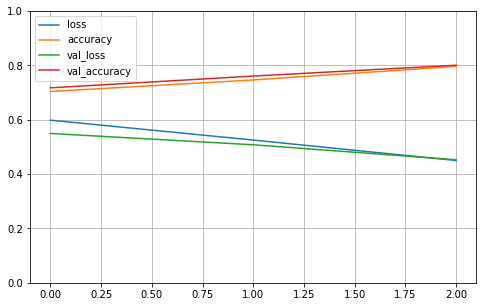

Train set ones/size 3008 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 329 / 1153
Range of scores: 0.0022917641 to 0.99634486
Score threshold 0.5
Prediction set ones/size 233 / 1153


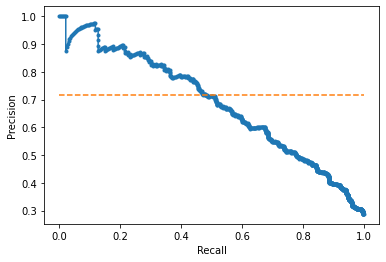

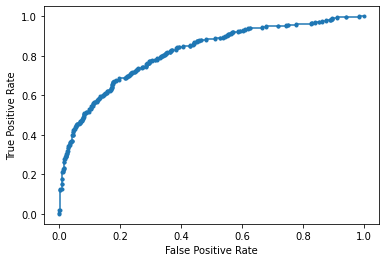

Accuracy: 80.05% Precision: 71.24% Recall: 50.46%
F1: 59.07% AUPRC: 68.61% AUROC: 81.63%
2023-02-07 15:48:44.114517

Completed cross validation 10 folds 3 epochs
 accuracy mean 78.26% +/- 1.92
 precision mean 70.23% +/- 10.60
 recall mean 49.87% +/- 13.31
 F1 mean 56.27% +/- 5.44
 AUPRC mean 69.44% +/- 3.48
 AUROC mean 81.86% +/- 2.08
Finished cell Line 6 MCF.7

2023-02-07 15:48:45.585589
Start cell Line 7 NCI.H460
Number of RCI values loaded 610
Num RCI: 610
Load sequence...
Cross validation...
2023-02-07 15:48:54.520526
splitting
Fold 1
RCI mean derived from training set: -1.3083752442899723
RCI threshold derived from training set: 0
FIT
2023-02-07 15:48:55.940964
PREDICT
2023-02-07 15:49:01.927550


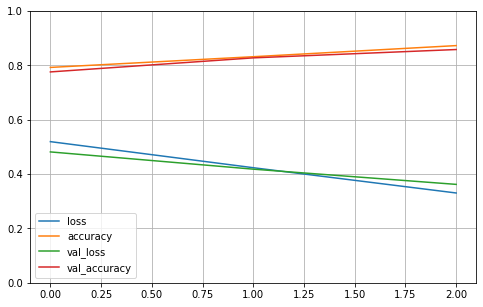

Train set ones/size 938 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 111 / 522
Range of scores: 0.0054233256 to 0.9964401
Score threshold 0.5
Prediction set ones/size 87 / 522


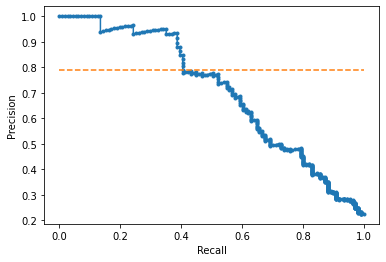

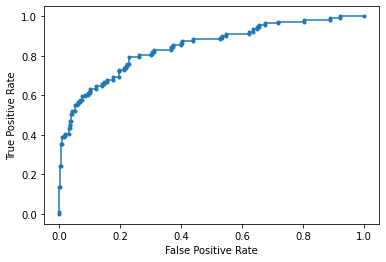

Accuracy: 85.82% Precision: 71.26% Recall: 55.86%
F1: 62.63% AUPRC: 70.48% AUROC: 84.48%
2023-02-07 15:49:02.751126
Fold 2
RCI mean derived from training set: -1.297517116314669
RCI threshold derived from training set: 0
FIT
2023-02-07 15:49:05.487807
PREDICT
2023-02-07 15:49:10.914281


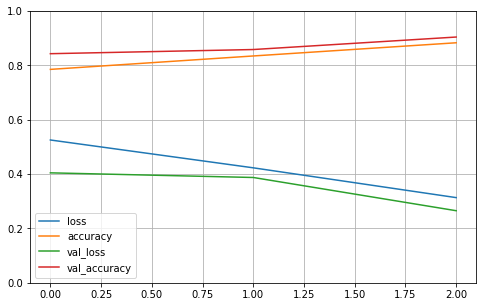

Train set ones/size 965 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 84 / 522
Range of scores: 0.000656117 to 0.9731727
Score threshold 0.5
Prediction set ones/size 60 / 522


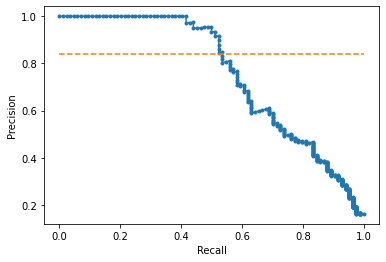

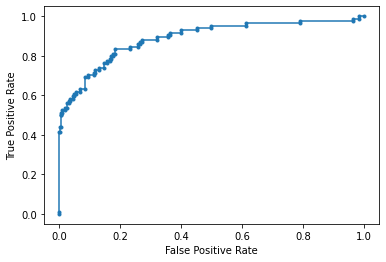

Accuracy: 90.42% Precision: 78.33% Recall: 55.95%
F1: 65.28% AUPRC: 75.53% AUROC: 88.83%
2023-02-07 15:49:11.505557
Fold 3
RCI mean derived from training set: -1.3034471971535022
RCI threshold derived from training set: 0
FIT
2023-02-07 15:49:14.835228
PREDICT
2023-02-07 15:49:21.148343


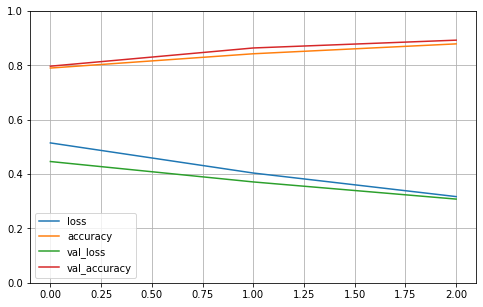

Train set ones/size 941 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 108 / 522
Range of scores: 0.006170068 to 0.98964393
Score threshold 0.5
Prediction set ones/size 80 / 522


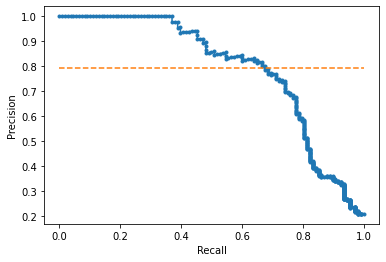

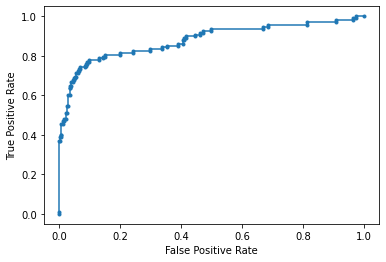

Accuracy: 89.27% Precision: 82.50% Recall: 61.11%
F1: 70.21% AUPRC: 79.30% AUROC: 87.88%
2023-02-07 15:49:21.745047
Fold 4
RCI mean derived from training set: -1.2912956771833086
RCI threshold derived from training set: 0
FIT
2023-02-07 15:49:24.379087
PREDICT
2023-02-07 15:49:30.375071


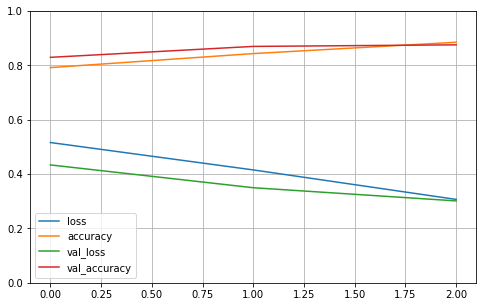

Train set ones/size 956 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 93 / 522
Range of scores: 0.0013598319 to 0.997391
Score threshold 0.5
Prediction set ones/size 84 / 522


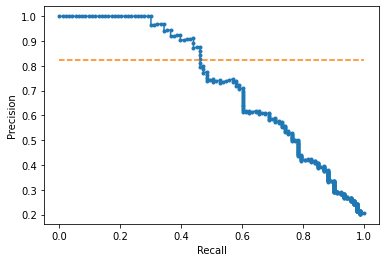

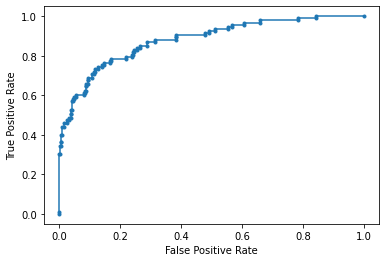

Accuracy: 87.55% Precision: 66.67% Recall: 60.22%
F1: 63.28% AUPRC: 73.18% AUROC: 87.99%
2023-02-07 15:49:30.968432
Fold 5
RCI mean derived from training set: -1.3037518440344902
RCI threshold derived from training set: 0
FIT
2023-02-07 15:49:33.613461
PREDICT
2023-02-07 15:49:39.024444


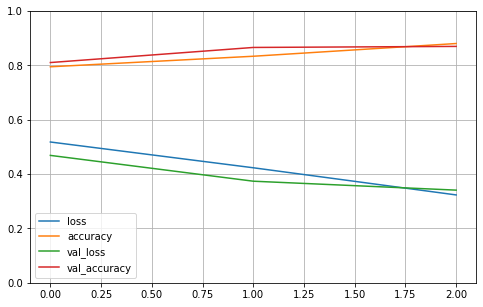

Train set ones/size 947 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 102 / 522
Range of scores: 0.00033844562 to 0.99320155
Score threshold 0.5
Prediction set ones/size 38 / 522


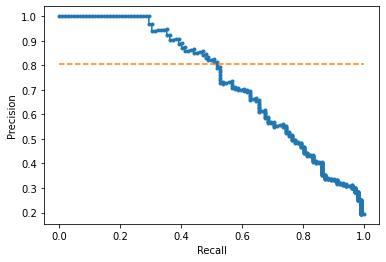

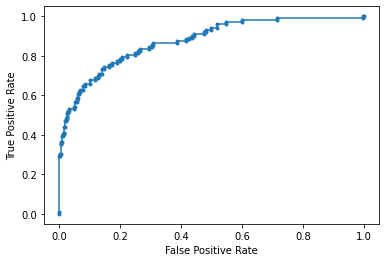

Accuracy: 86.97% Precision: 94.74% Recall: 35.29%
F1: 51.43% AUPRC: 73.74% AUROC: 87.64%
2023-02-07 15:49:39.649564
Fold 6
RCI mean derived from training set: -1.3049483705556737
RCI threshold derived from training set: 0
FIT
2023-02-07 15:49:42.960732
PREDICT
2023-02-07 15:49:48.937332


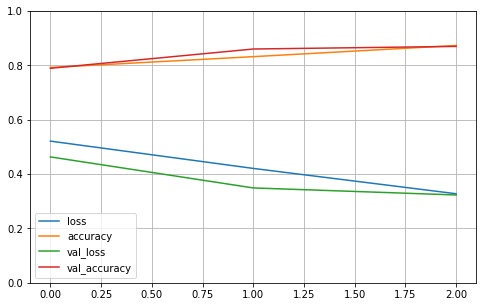

Train set ones/size 939 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 110 / 522
Range of scores: 0.0053528543 to 0.98292106
Score threshold 0.5
Prediction set ones/size 68 / 522


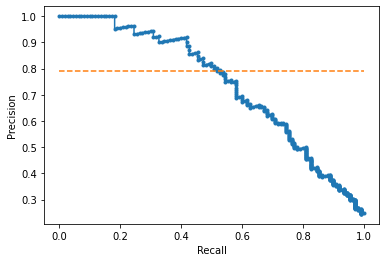

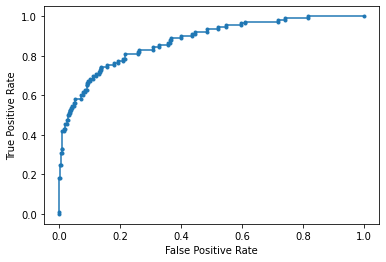

Accuracy: 86.97% Precision: 80.88% Recall: 50.00%
F1: 61.80% AUPRC: 74.00% AUROC: 87.56%
2023-02-07 15:49:49.528083
Fold 7
RCI mean derived from training set: -1.3032546083947198
RCI threshold derived from training set: 0
FIT
2023-02-07 15:49:52.155804
PREDICT
2023-02-07 15:49:58.159986


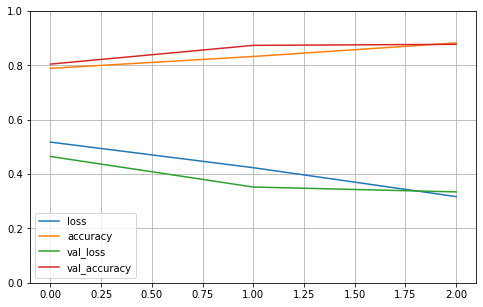

Train set ones/size 942 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 107 / 522
Range of scores: 0.0011659103 to 0.9957163
Score threshold 0.5
Prediction set ones/size 57 / 522


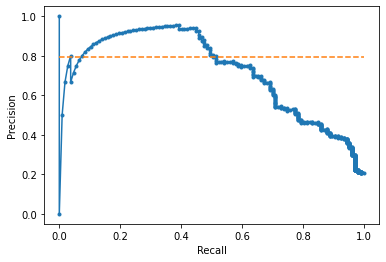

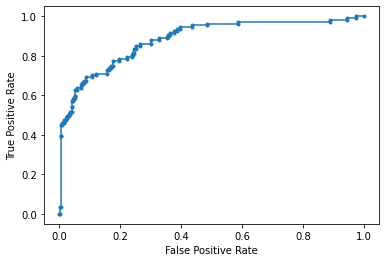

Accuracy: 87.74% Precision: 87.72% Recall: 46.73%
F1: 60.98% AUPRC: 71.31% AUROC: 88.30%
2023-02-07 15:49:58.746630
Fold 8
RCI mean derived from training set: -1.3093740925122417
RCI threshold derived from training set: 0
FIT
2023-02-07 15:50:01.383986
PREDICT
2023-02-07 15:50:06.992651


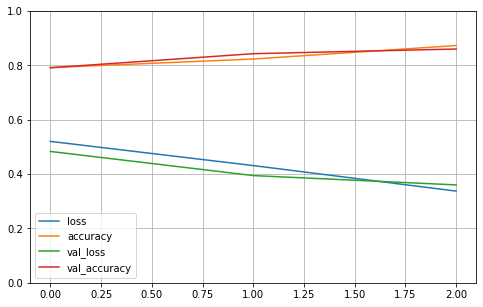

Train set ones/size 940 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 109 / 522
Range of scores: 0.0010711822 to 0.9903803
Score threshold 0.5
Prediction set ones/size 68 / 522


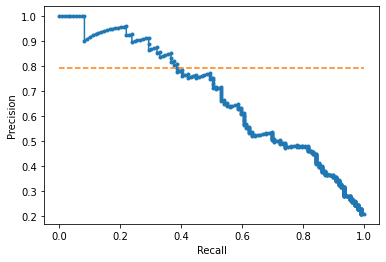

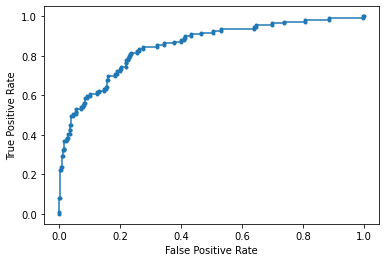

Accuracy: 86.02% Precision: 76.47% Recall: 47.71%
F1: 58.76% AUPRC: 68.27% AUROC: 85.10%
2023-02-07 15:50:07.890169
Fold 9
RCI mean derived from training set: -1.3158440667511175
RCI threshold derived from training set: 0
FIT
2023-02-07 15:50:10.621753
PREDICT
2023-02-07 15:50:16.607252


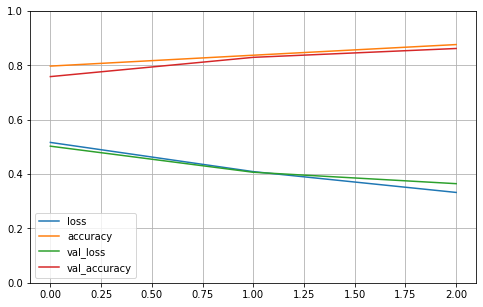

Train set ones/size 923 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 126 / 522
Range of scores: 0.002867442 to 0.99013317
Score threshold 0.5
Prediction set ones/size 62 / 522


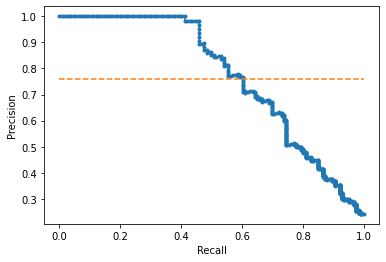

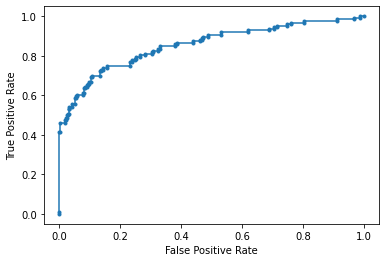

Accuracy: 86.21% Precision: 93.55% Recall: 46.03%
F1: 61.70% AUPRC: 77.22% AUROC: 85.49%
2023-02-07 15:50:17.219811
Fold 10
RCI mean derived from training set: -1.312804497835249
RCI threshold derived from training set: 0
FIT
2023-02-07 15:50:20.817618
PREDICT
2023-02-07 15:50:26.699695


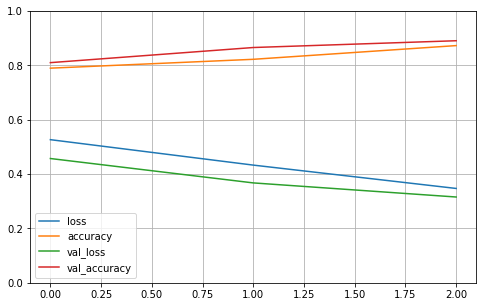

Train set ones/size 950 / 4698
Compute valiation accuracy
Valid sizes (521, 4997) (521,)
Valid set ones/size 99 / 521
Range of scores: 0.0042934134 to 0.9838005
Score threshold 0.5
Prediction set ones/size 56 / 521


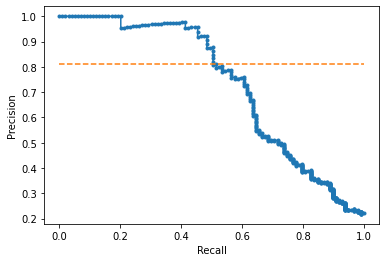

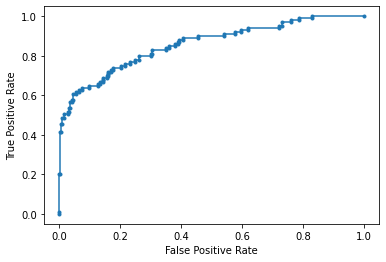

Accuracy: 89.06% Precision: 87.50% Recall: 49.49%
F1: 63.23% AUPRC: 73.11% AUROC: 85.71%
2023-02-07 15:50:27.307716

Completed cross validation 10 folds 3 epochs
 accuracy mean 87.60% +/- 1.54
 precision mean 81.96% +/- 9.16
 recall mean 50.84% +/- 7.74
 F1 mean 61.93% +/- 4.77
 AUPRC mean 73.62% +/- 3.22
 AUROC mean 86.90% +/- 1.54
Finished cell Line 7 NCI.H460

2023-02-07 15:50:28.614062
Start cell Line 8 NHEK
Number of RCI values loaded 1080
Num RCI: 1080
Load sequence...
Cross validation...
2023-02-07 15:50:41.586354
splitting
Fold 1
RCI mean derived from training set: -0.653079659387811
RCI threshold derived from training set: 0
FIT
2023-02-07 15:50:43.756825
PREDICT
2023-02-07 15:50:52.021922


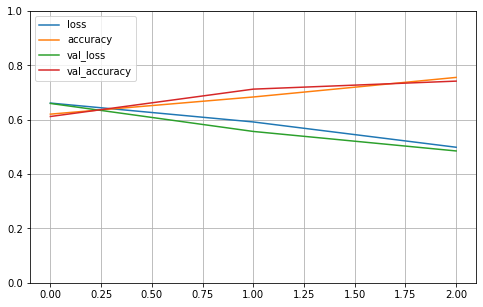

Train set ones/size 2762 / 7318
Compute valiation accuracy
Valid sizes (814, 4997) (814,)
Valid set ones/size 317 / 814
Range of scores: 0.002423414 to 0.99255025
Score threshold 0.5
Prediction set ones/size 353 / 814


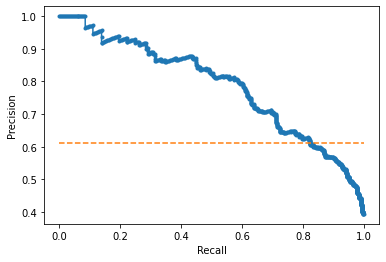

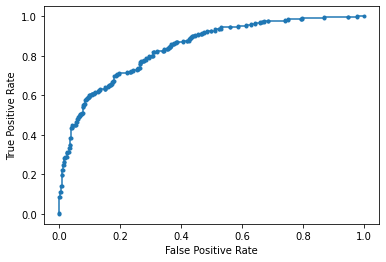

Accuracy: 74.20% Precision: 65.16% Recall: 72.56%
F1: 68.66% AUPRC: 78.68% AUROC: 84.17%
2023-02-07 15:50:52.659699
Fold 2
RCI mean derived from training set: -0.6412958734216999
RCI threshold derived from training set: 0
FIT
2023-02-07 15:50:56.102995
PREDICT
2023-02-07 15:51:07.385816


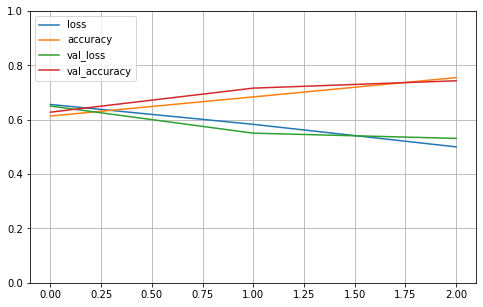

Train set ones/size 2770 / 7318
Compute valiation accuracy
Valid sizes (814, 4997) (814,)
Valid set ones/size 309 / 814
Range of scores: 0.002984964 to 0.98109263
Score threshold 0.5
Prediction set ones/size 182 / 814


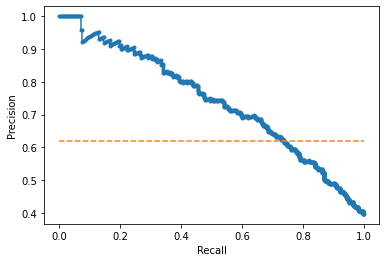

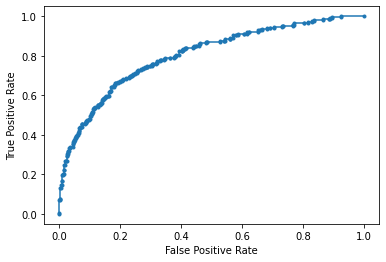

Accuracy: 74.32% Precision: 77.47% Recall: 45.63%
F1: 57.43% AUPRC: 74.03% AUROC: 80.31%
2023-02-07 15:51:08.052454
Fold 3
RCI mean derived from training set: -0.6430724309195246
RCI threshold derived from training set: 0
FIT
2023-02-07 15:51:11.470234
PREDICT
2023-02-07 15:51:22.993931


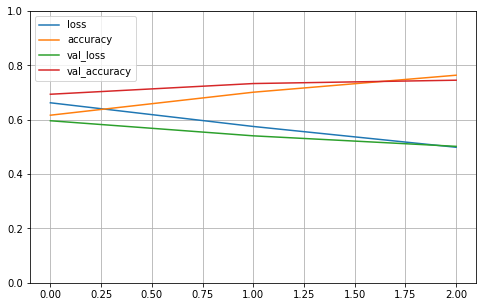

Train set ones/size 2787 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 292 / 813
Range of scores: 0.0039738757 to 0.9893635
Score threshold 0.5
Prediction set ones/size 299 / 813


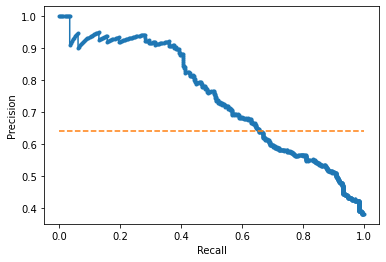

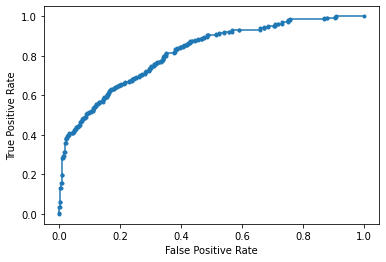

Accuracy: 74.54% Precision: 64.21% Recall: 65.75%
F1: 64.97% AUPRC: 74.47% AUROC: 81.71%
2023-02-07 15:51:23.643227
Fold 4
RCI mean derived from training set: -0.6520008468916518
RCI threshold derived from training set: 0
FIT
2023-02-07 15:51:28.663012
PREDICT
2023-02-07 15:51:36.439881


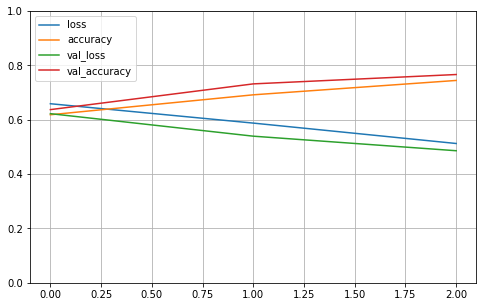

Train set ones/size 2763 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 316 / 813
Range of scores: 0.011535574 to 0.97704804
Score threshold 0.5
Prediction set ones/size 238 / 813


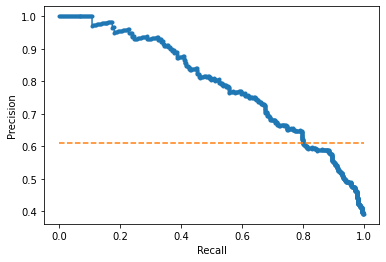

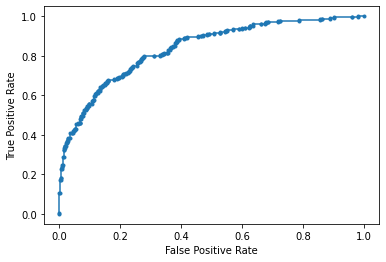

Accuracy: 76.63% Precision: 76.47% Recall: 57.59%
F1: 65.70% AUPRC: 79.07% AUROC: 83.74%
2023-02-07 15:51:37.114764
Fold 5
RCI mean derived from training set: -0.6458179012979914
RCI threshold derived from training set: 0
FIT
2023-02-07 15:51:42.078499
PREDICT
2023-02-07 15:51:53.382134


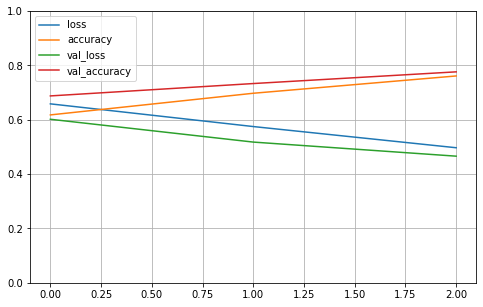

Train set ones/size 2772 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 307 / 813
Range of scores: 0.009901346 to 0.99279916
Score threshold 0.5
Prediction set ones/size 267 / 813


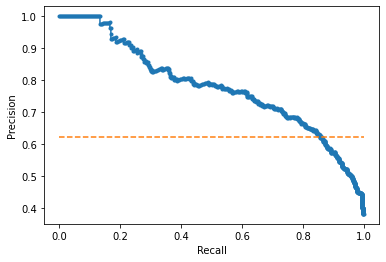

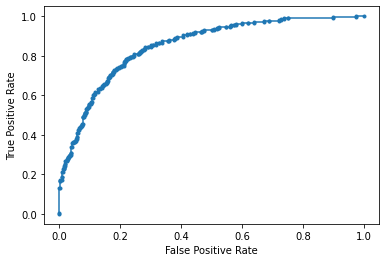

Accuracy: 77.61% Precision: 73.41% Recall: 63.84%
F1: 68.29% AUPRC: 78.05% AUROC: 85.17%
2023-02-07 15:51:54.257600
Fold 6
RCI mean derived from training set: -0.6456534287470966
RCI threshold derived from training set: 0
FIT
2023-02-07 15:51:57.779563
PREDICT
2023-02-07 15:52:05.548707


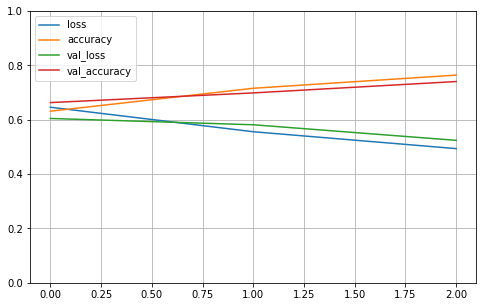

Train set ones/size 2778 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 301 / 813
Range of scores: 0.0035532722 to 0.9821316
Score threshold 0.5
Prediction set ones/size 250 / 813


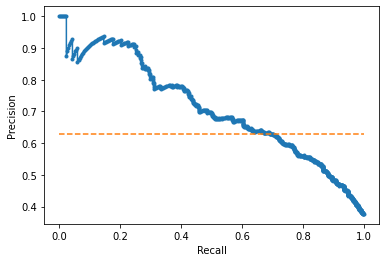

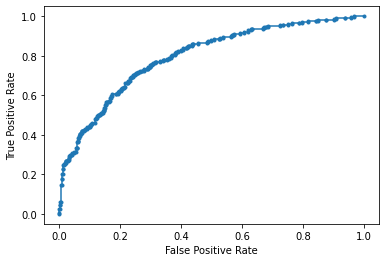

Accuracy: 74.05% Precision: 68.00% Recall: 56.48%
F1: 61.71% AUPRC: 71.09% AUROC: 79.61%
2023-02-07 15:52:06.405110
Fold 7
RCI mean derived from training set: -0.662971660841645
RCI threshold derived from training set: 0
FIT
2023-02-07 15:52:09.974045
PREDICT
2023-02-07 15:52:17.808453


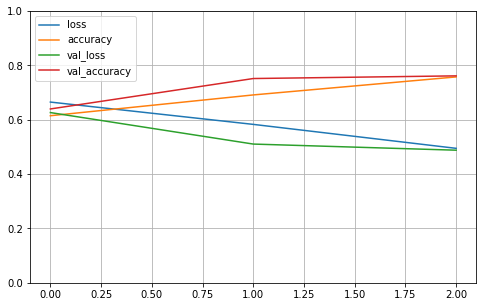

Train set ones/size 2757 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 322 / 813
Range of scores: 0.019375993 to 0.99304247
Score threshold 0.5
Prediction set ones/size 422 / 813


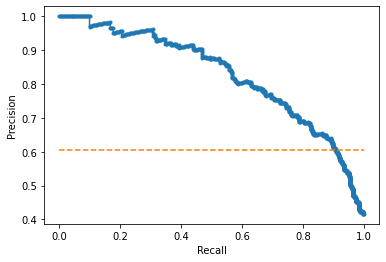

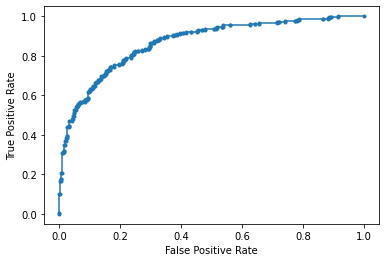

Accuracy: 76.14% Precision: 65.17% Recall: 85.40%
F1: 73.92% AUPRC: 82.83% AUROC: 86.74%
2023-02-07 15:52:18.642287
Fold 8
RCI mean derived from training set: -0.6438629646946304
RCI threshold derived from training set: 0
FIT
2023-02-07 15:52:22.445390
PREDICT
2023-02-07 15:52:30.259218


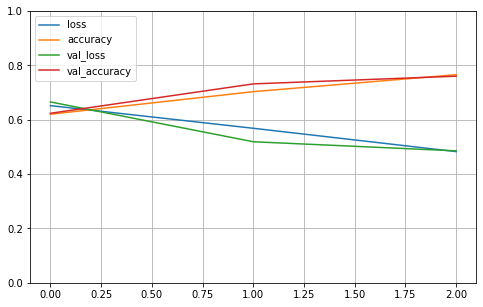

Train set ones/size 2772 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 307 / 813
Range of scores: 0.009426289 to 0.98252827
Score threshold 0.5
Prediction set ones/size 270 / 813


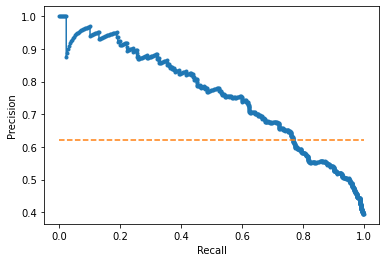

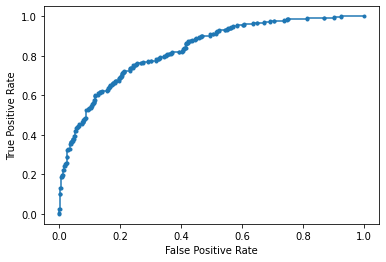

Accuracy: 76.01% Precision: 70.74% Recall: 62.21%
F1: 66.20% AUPRC: 75.85% AUROC: 82.95%
2023-02-07 15:52:31.025370
Fold 9
RCI mean derived from training set: -0.6443524139226671
RCI threshold derived from training set: 0
FIT
2023-02-07 15:52:35.038285
PREDICT
2023-02-07 15:52:46.322142


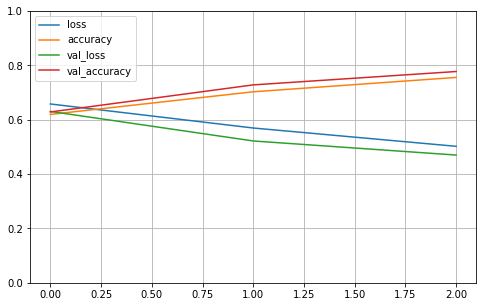

Train set ones/size 2784 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 295 / 813
Range of scores: 0.006450792 to 0.99155563
Score threshold 0.5
Prediction set ones/size 304 / 813


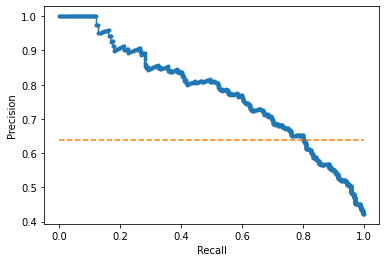

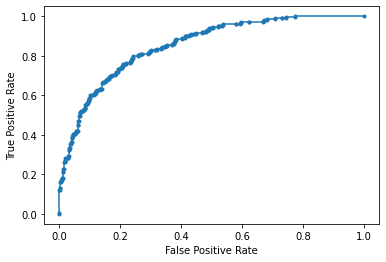

Accuracy: 77.74% Precision: 68.75% Recall: 70.85%
F1: 69.78% AUPRC: 77.59% AUROC: 85.35%
2023-02-07 15:52:47.002401
Fold 10
RCI mean derived from training set: -0.6487705280639432
RCI threshold derived from training set: 0
FIT
2023-02-07 15:52:50.412525
PREDICT
2023-02-07 15:52:58.488983


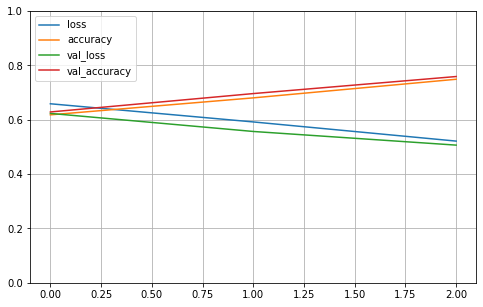

Train set ones/size 2766 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 313 / 813
Range of scores: 0.011965004 to 0.9716125
Score threshold 0.5
Prediction set ones/size 249 / 813


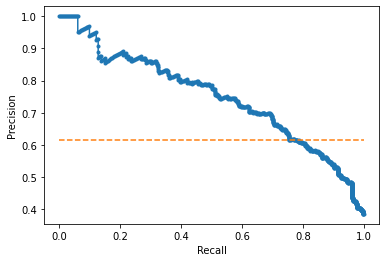

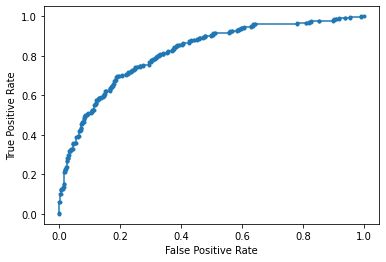

Accuracy: 75.89% Precision: 73.49% Recall: 58.47%
F1: 65.12% AUPRC: 74.93% AUROC: 81.92%
2023-02-07 15:52:59.195440

Completed cross validation 10 folds 3 epochs
 accuracy mean 75.71% +/- 1.38
 precision mean 70.29% +/- 4.80
 recall mean 63.88% +/- 10.80
 F1 mean 66.18% +/- 4.51
 AUPRC mean 76.66% +/- 3.29
 AUROC mean 83.17% +/- 2.30
Finished cell Line 8 NHEK

2023-02-07 15:53:00.577257
Start cell Line 9 SK.MEL.5
Number of RCI values loaded 534
Num RCI: 534
Load sequence...
Cross validation...
2023-02-07 15:53:07.462610
splitting
Fold 1
RCI mean derived from training set: -1.6097299827669693
RCI threshold derived from training set: 0
FIT
2023-02-07 15:53:08.871924
PREDICT
2023-02-07 15:53:14.846737


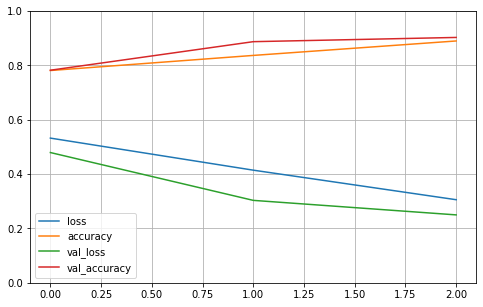

Train set ones/size 968 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 113 / 514
Range of scores: 0.00081393844 to 0.9903464
Score threshold 0.5
Prediction set ones/size 75 / 514


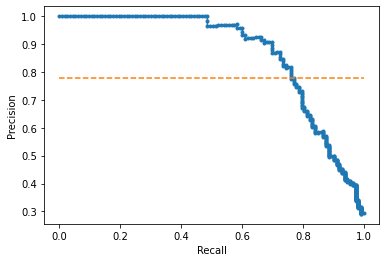

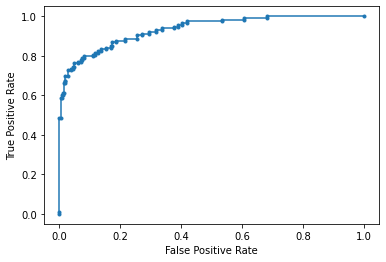

Accuracy: 90.27% Precision: 92.00% Recall: 61.06%
F1: 73.40% AUPRC: 86.78% AUROC: 93.36%
2023-02-07 15:53:15.445091
Fold 2
RCI mean derived from training set: -1.6072797641763945
RCI threshold derived from training set: 0
FIT
2023-02-07 15:53:18.070001
PREDICT
2023-02-07 15:53:23.562676


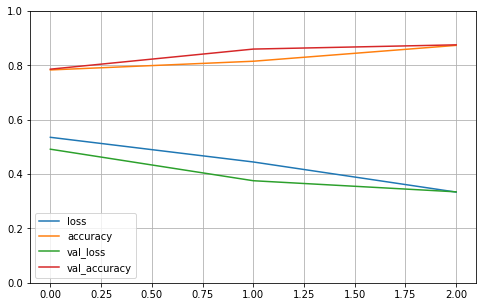

Train set ones/size 971 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 110 / 514
Range of scores: 0.0006877496 to 0.9892721
Score threshold 0.5
Prediction set ones/size 60 / 514


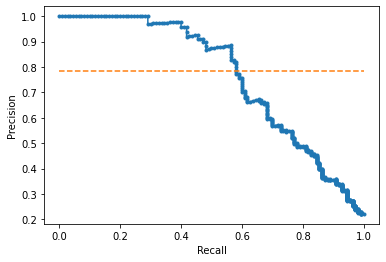

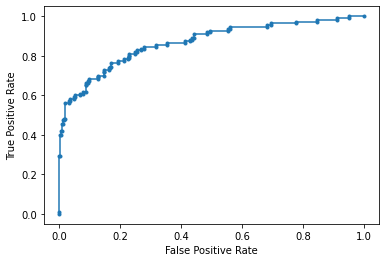

Accuracy: 87.55% Precision: 88.33% Recall: 48.18%
F1: 62.35% AUPRC: 76.31% AUROC: 86.78%
2023-02-07 15:53:24.411711
Fold 3
RCI mean derived from training set: -1.6086752521141374
RCI threshold derived from training set: 0
FIT
2023-02-07 15:53:27.143011
PREDICT
2023-02-07 15:53:33.113757


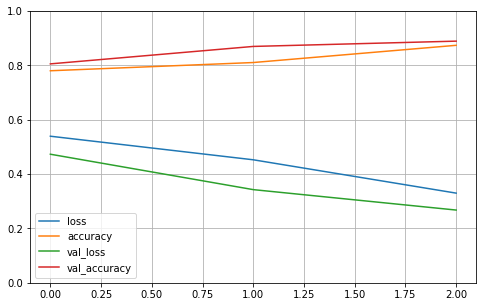

Train set ones/size 981 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 100 / 514
Range of scores: 0.0006174581 to 0.9833198
Score threshold 0.5
Prediction set ones/size 47 / 514


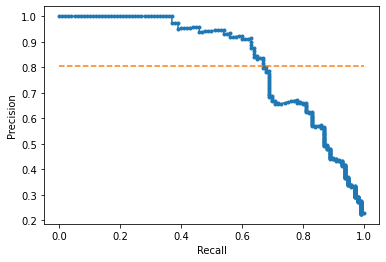

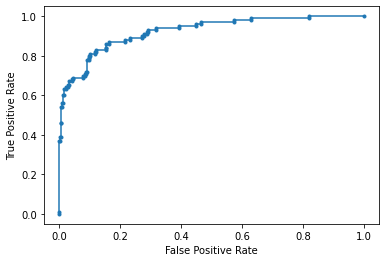

Accuracy: 88.91% Precision: 95.74% Recall: 45.00%
F1: 61.22% AUPRC: 82.90% AUROC: 92.40%
2023-02-07 15:53:33.720110
Fold 4
RCI mean derived from training set: -1.6067064599610894
RCI threshold derived from training set: 0
FIT
2023-02-07 15:53:37.234828
PREDICT
2023-02-07 15:53:42.754862


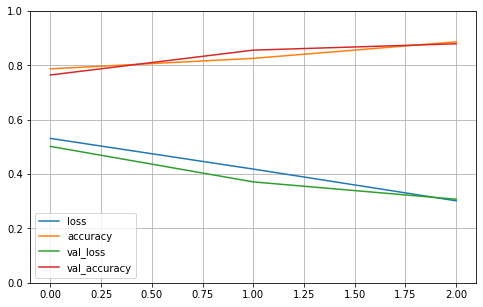

Train set ones/size 962 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 119 / 514
Range of scores: 0.00030373287 to 0.9944549
Score threshold 0.5
Prediction set ones/size 95 / 514


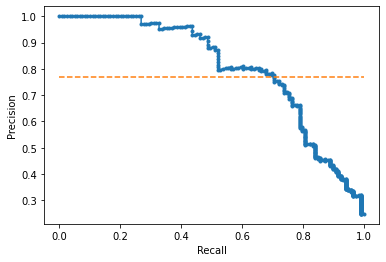

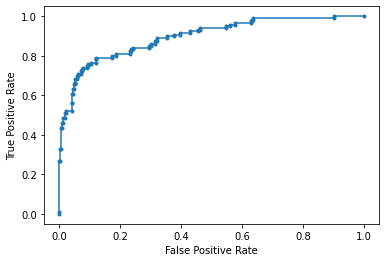

Accuracy: 87.94% Precision: 80.00% Recall: 63.87%
F1: 71.03% AUPRC: 80.26% AUROC: 89.63%
2023-02-07 15:53:43.352361
Fold 5
RCI mean derived from training set: -1.6148654526329445
RCI threshold derived from training set: 0
FIT
2023-02-07 15:53:45.975003
PREDICT
2023-02-07 15:53:51.686346


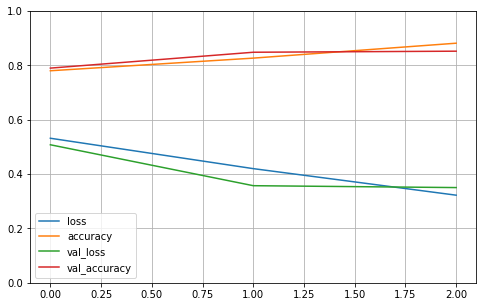

Train set ones/size 971 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 110 / 514
Range of scores: 0.00019853826 to 0.97234994
Score threshold 0.5
Prediction set ones/size 38 / 514


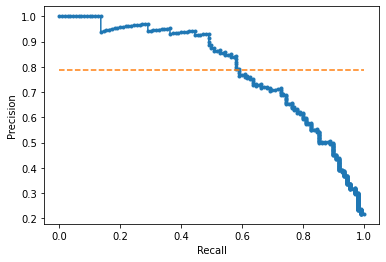

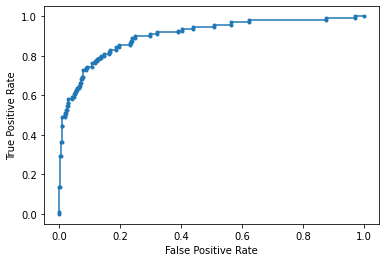

Accuracy: 85.21% Precision: 94.74% Recall: 32.73%
F1: 48.65% AUPRC: 79.18% AUROC: 90.37%
2023-02-07 15:53:52.313675
Fold 6
RCI mean derived from training set: -1.6097505674102894
RCI threshold derived from training set: 0
FIT
2023-02-07 15:53:54.951706
PREDICT
2023-02-07 15:54:00.933901


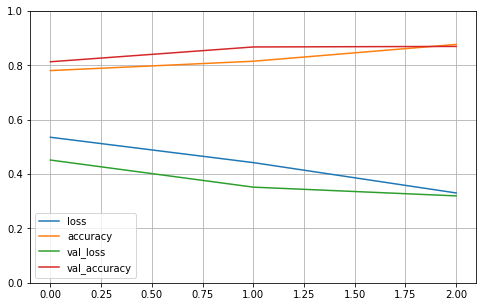

Train set ones/size 985 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 96 / 514
Range of scores: 0.0010307461 to 0.99242955
Score threshold 0.5
Prediction set ones/size 99 / 514


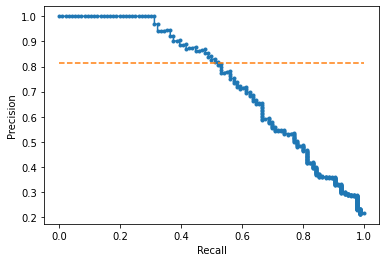

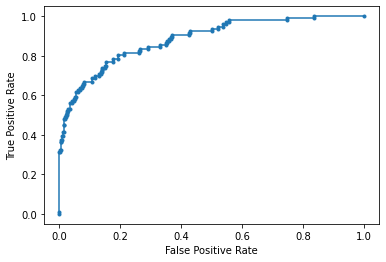

Accuracy: 86.96% Precision: 64.65% Recall: 66.67%
F1: 65.64% AUPRC: 74.34% AUROC: 88.35%
2023-02-07 15:54:01.538982
Fold 7
RCI mean derived from training set: -1.625522115170774
RCI threshold derived from training set: 0
FIT
2023-02-07 15:54:04.933142
PREDICT
2023-02-07 15:54:10.909376


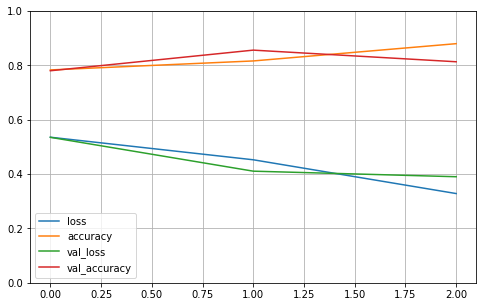

Train set ones/size 964 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 117 / 514
Range of scores: 0.0063417065 to 0.99829656
Score threshold 0.5
Prediction set ones/size 179 / 514


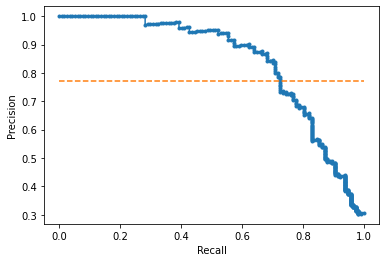

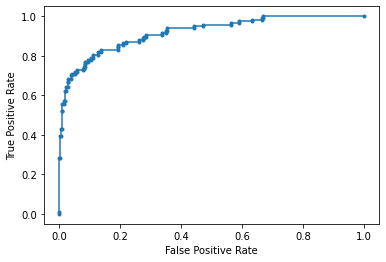

Accuracy: 81.32% Precision: 55.87% Recall: 85.47%
F1: 67.57% AUPRC: 84.05% AUROC: 91.87%
2023-02-07 15:54:11.632587
Fold 8
RCI mean derived from training set: -1.6139277325940338
RCI threshold derived from training set: 0
FIT
2023-02-07 15:54:14.234012
PREDICT
2023-02-07 15:54:20.517749


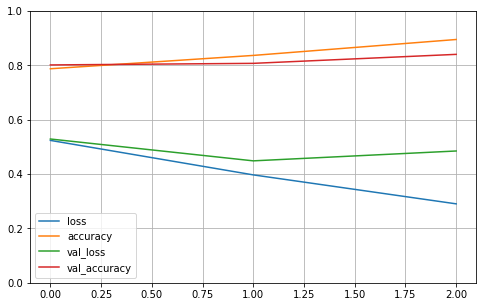

Train set ones/size 965 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 116 / 514
Range of scores: 5.2255014e-05 to 0.98196524
Score threshold 0.5
Prediction set ones/size 42 / 514


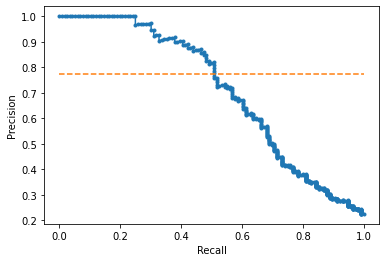

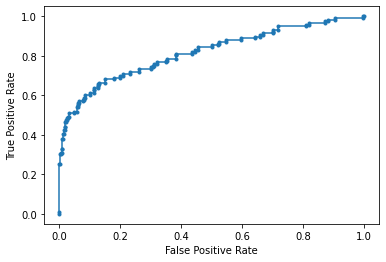

Accuracy: 84.05% Precision: 90.48% Recall: 32.76%
F1: 48.10% AUPRC: 70.84% AUROC: 81.64%
2023-02-07 15:54:21.145593
Fold 9
RCI mean derived from training set: -1.6240643330393427
RCI threshold derived from training set: 0
FIT
2023-02-07 15:54:23.766532
PREDICT
2023-02-07 15:54:29.761203


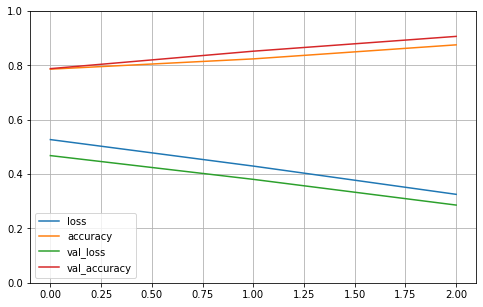

Train set ones/size 972 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 109 / 514
Range of scores: 0.00065905164 to 0.9943376
Score threshold 0.5
Prediction set ones/size 75 / 514


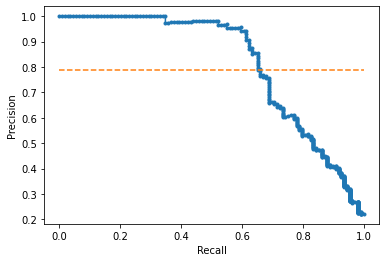

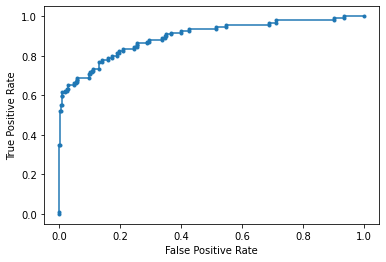

Accuracy: 90.66% Precision: 90.67% Recall: 62.39%
F1: 73.91% AUPRC: 81.51% AUROC: 89.61%
2023-02-07 15:54:30.643955
Fold 10
RCI mean derived from training set: -1.5917950430134025
RCI threshold derived from training set: 0
FIT
2023-02-07 15:54:33.419463
PREDICT
2023-02-07 15:54:39.409011


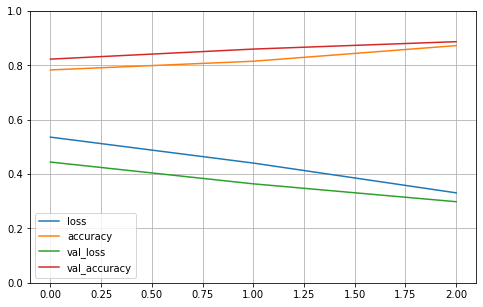

Train set ones/size 990 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 91 / 514
Range of scores: 0.0015483703 to 0.97974074
Score threshold 0.5
Prediction set ones/size 55 / 514


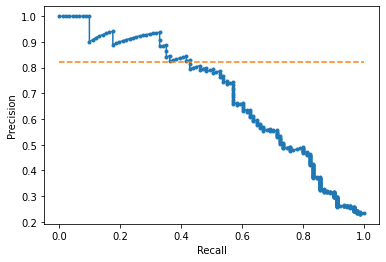

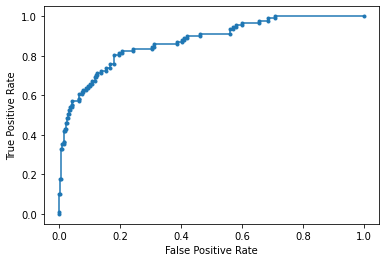

Accuracy: 88.72% Precision: 80.00% Recall: 48.35%
F1: 60.27% AUPRC: 69.79% AUROC: 87.42%
2023-02-07 15:54:40.081661

Completed cross validation 10 folds 3 epochs
 accuracy mean 87.16% +/- 2.90
 precision mean 83.25% +/- 13.39
 recall mean 54.65% +/- 16.38
 F1 mean 63.22% +/- 9.18
 AUPRC mean 78.60% +/- 5.66
 AUROC mean 89.14% +/- 3.39
Finished cell Line 9 SK.MEL.5

2023-02-07 15:54:41.412634
Start cell Line 10 SK.N.DZ
Number of RCI values loaded 603
Num RCI: 603
Load sequence...
Cross validation...
2023-02-07 15:54:50.667553
splitting
Fold 1
RCI mean derived from training set: -0.6281296777050442
RCI threshold derived from training set: 0
FIT
2023-02-07 15:54:52.221269
PREDICT
2023-02-07 15:55:03.409946


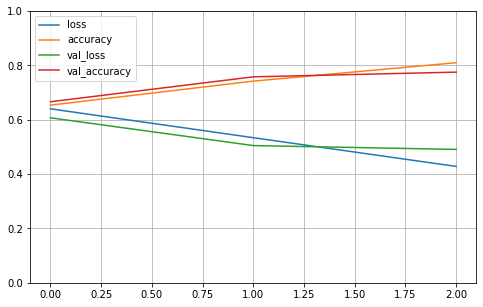

Train set ones/size 1772 / 5194
Compute valiation accuracy
Valid sizes (578, 4997) (578,)
Valid set ones/size 211 / 578
Range of scores: 0.00124793 to 0.98269814
Score threshold 0.5
Prediction set ones/size 101 / 578


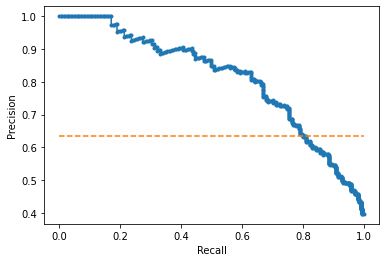

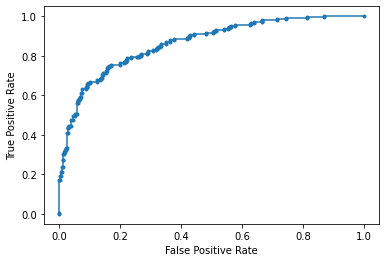

Accuracy: 77.51% Precision: 90.10% Recall: 43.13%
F1: 58.33% AUPRC: 81.14% AUROC: 86.46%
2023-02-07 15:55:04.033856
Fold 2
RCI mean derived from training set: -0.6153963924797844
RCI threshold derived from training set: 0
FIT
2023-02-07 15:55:06.798960
PREDICT
2023-02-07 15:55:18.128377


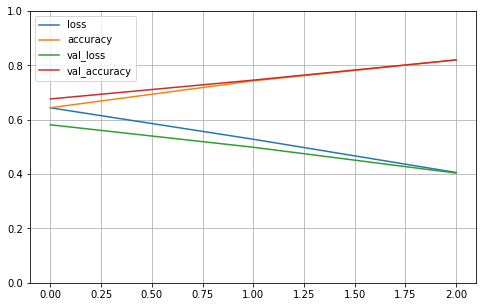

Train set ones/size 1791 / 5194
Compute valiation accuracy
Valid sizes (578, 4997) (578,)
Valid set ones/size 192 / 578
Range of scores: 0.0005989736 to 0.9863772
Score threshold 0.5
Prediction set ones/size 126 / 578


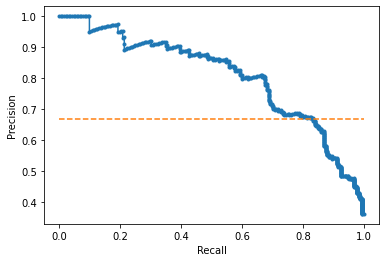

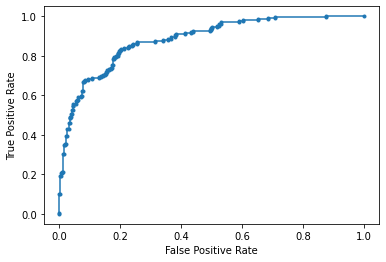

Accuracy: 82.01% Precision: 84.92% Recall: 55.73%
F1: 67.30% AUPRC: 80.81% AUROC: 88.31%
2023-02-07 15:55:18.792732
Fold 3
RCI mean derived from training set: -0.6143647613782484
RCI threshold derived from training set: 0
FIT
2023-02-07 15:55:22.408334
PREDICT
2023-02-07 15:55:28.524708


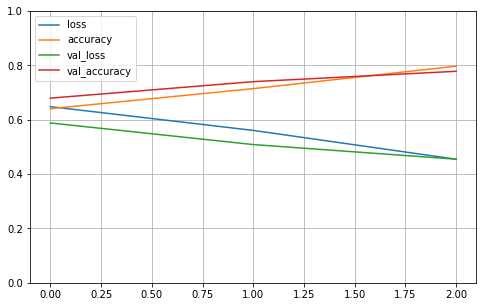

Train set ones/size 1800 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 183 / 577
Range of scores: 0.0036542623 to 0.99049056
Score threshold 0.5
Prediction set ones/size 223 / 577


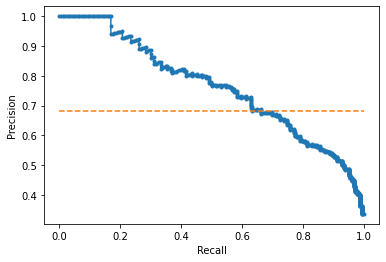

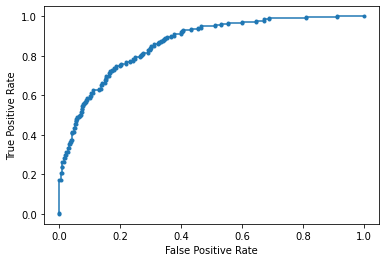

Accuracy: 77.82% Precision: 62.33% Recall: 75.96%
F1: 68.47% AUPRC: 76.32% AUROC: 86.32%
2023-02-07 15:55:29.202282
Fold 4
RCI mean derived from training set: -0.6185031523464869
RCI threshold derived from training set: 0
FIT
2023-02-07 15:55:31.988356
PREDICT
2023-02-07 15:55:38.102443


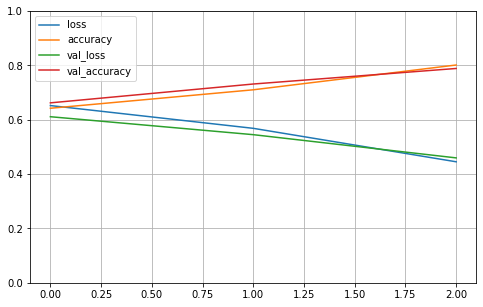

Train set ones/size 1784 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 199 / 577
Range of scores: 0.0008477176 to 0.9529869
Score threshold 0.5
Prediction set ones/size 107 / 577


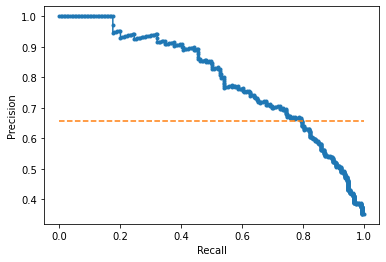

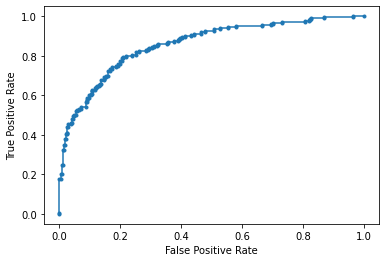

Accuracy: 78.86% Precision: 85.98% Recall: 46.23%
F1: 60.13% AUPRC: 79.46% AUROC: 85.79%
2023-02-07 15:55:38.770958
Fold 5
RCI mean derived from training set: -0.6135521460789221
RCI threshold derived from training set: 0
FIT
2023-02-07 15:55:41.534766
PREDICT
2023-02-07 15:55:47.492827


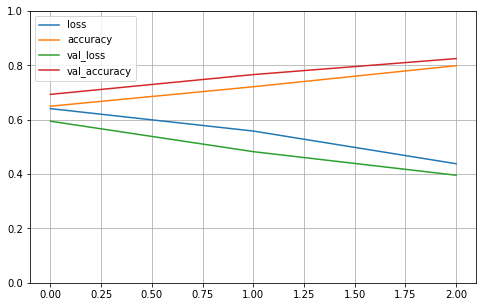

Train set ones/size 1801 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 182 / 577
Range of scores: 0.0032213356 to 0.9885433
Score threshold 0.5
Prediction set ones/size 145 / 577


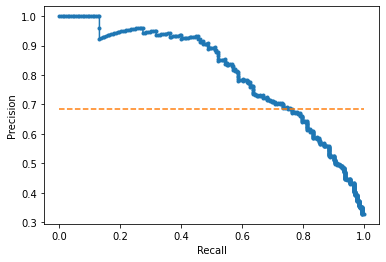

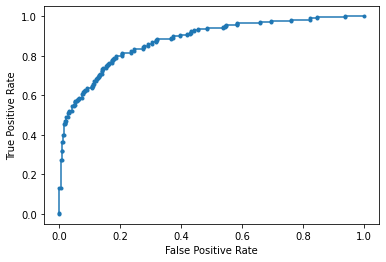

Accuracy: 82.50% Precision: 77.93% Recall: 62.09%
F1: 69.11% AUPRC: 80.58% AUROC: 87.79%
2023-02-07 15:55:48.340319
Fold 6
RCI mean derived from training set: -0.6120151131145332
RCI threshold derived from training set: 0
FIT
2023-02-07 15:55:51.330693
PREDICT
2023-02-07 15:55:57.369346


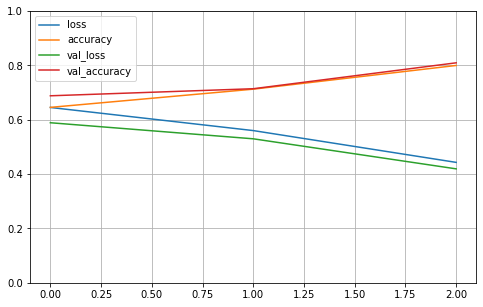

Train set ones/size 1796 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 187 / 577
Range of scores: 0.00089757284 to 0.98096347
Score threshold 0.5
Prediction set ones/size 179 / 577


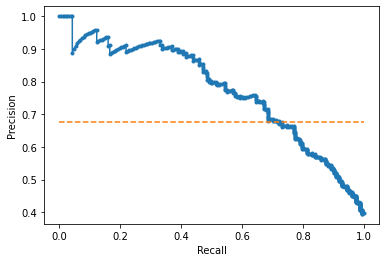

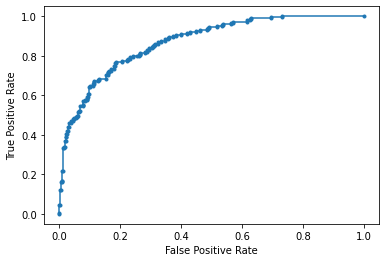

Accuracy: 80.94% Precision: 71.51% Recall: 68.45%
F1: 69.95% AUPRC: 77.52% AUROC: 87.02%
2023-02-07 15:55:57.990482
Fold 7
RCI mean derived from training set: -0.6226585323926853
RCI threshold derived from training set: 0
FIT
2023-02-07 15:56:01.506712
PREDICT
2023-02-07 15:56:07.843518


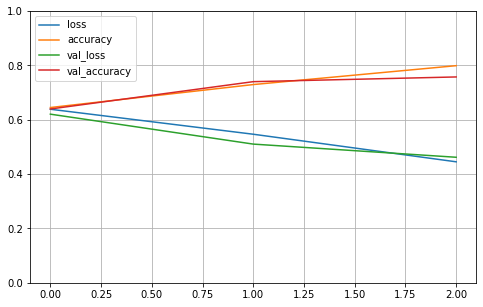

Train set ones/size 1776 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 207 / 577
Range of scores: 0.0073228646 to 0.9875536
Score threshold 0.5
Prediction set ones/size 237 / 577


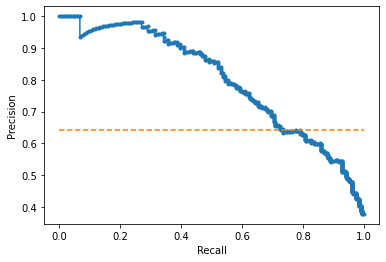

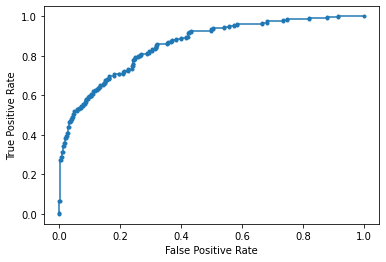

Accuracy: 75.74% Precision: 64.14% Recall: 73.43%
F1: 68.47% AUPRC: 79.85% AUROC: 85.69%
2023-02-07 15:56:08.456104
Fold 8
RCI mean derived from training set: -0.6264152809682387
RCI threshold derived from training set: 0
FIT
2023-02-07 15:56:11.249343
PREDICT
2023-02-07 15:56:17.581569


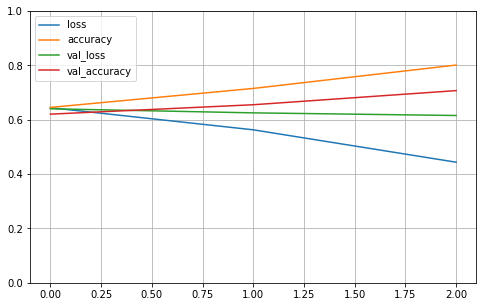

Train set ones/size 1759 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 224 / 577
Range of scores: 0.00025939406 to 0.9652357
Score threshold 0.5
Prediction set ones/size 67 / 577


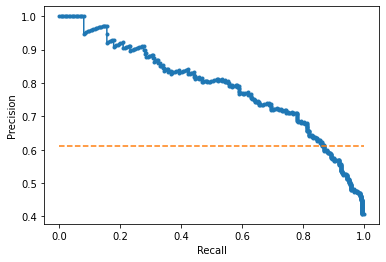

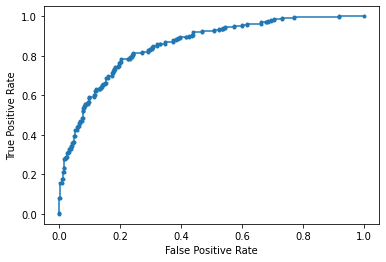

Accuracy: 70.71% Precision: 91.04% Recall: 27.23%
F1: 41.92% AUPRC: 78.97% AUROC: 85.28%
2023-02-07 15:56:18.272925
Fold 9
RCI mean derived from training set: -0.6273904246448507
RCI threshold derived from training set: 0
FIT
2023-02-07 15:56:21.071702
PREDICT
2023-02-07 15:56:27.039812


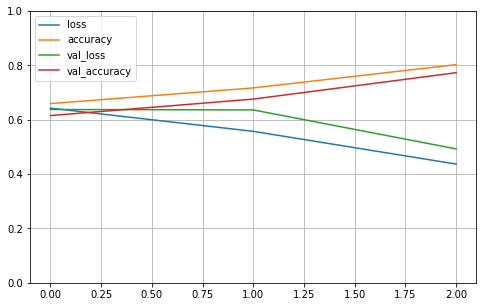

Train set ones/size 1756 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 227 / 577
Range of scores: 0.0020395592 to 0.95778865
Score threshold 0.5
Prediction set ones/size 128 / 577


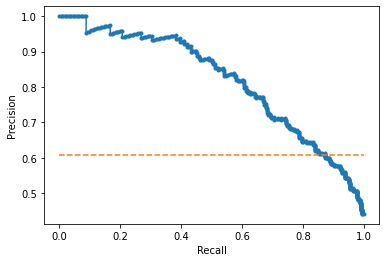

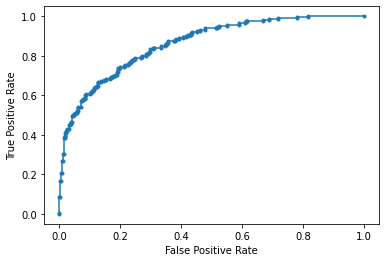

Accuracy: 77.30% Precision: 87.50% Recall: 49.34%
F1: 63.10% AUPRC: 81.89% AUROC: 86.23%
2023-02-07 15:56:27.892794
Fold 10
RCI mean derived from training set: -0.6130283155322426
RCI threshold derived from training set: 0
FIT
2023-02-07 15:56:30.858471
PREDICT
2023-02-07 15:56:36.734554


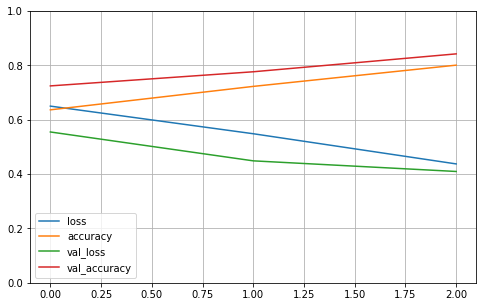

Train set ones/size 1812 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 171 / 577
Range of scores: 0.001005403 to 0.978909
Score threshold 0.5
Prediction set ones/size 190 / 577


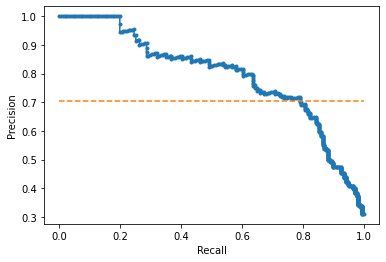

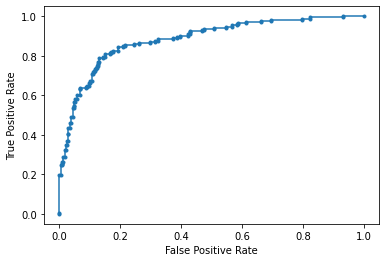

Accuracy: 84.23% Precision: 71.05% Recall: 78.95%
F1: 74.79% AUPRC: 79.50% AUROC: 88.38%
2023-02-07 15:56:37.353654

Completed cross validation 10 folds 3 epochs
 accuracy mean 78.76% +/- 3.91
 precision mean 78.65% +/- 10.76
 recall mean 58.05% +/- 16.71
 F1 mean 64.16% +/- 9.21
 AUPRC mean 79.60% +/- 1.69
 AUROC mean 86.73% +/- 1.10
Finished cell Line 10 SK.N.DZ

2023-02-07 15:56:38.686250
Start cell Line 11 SK.N.SH
Number of RCI values loaded 1647
Num RCI: 1647
Load sequence...
Cross validation...
2023-02-07 15:56:56.130448
splitting
Fold 1
RCI mean derived from training set: -0.9625358854186823
RCI threshold derived from training set: 0
FIT
2023-02-07 15:56:59.026516
PREDICT
2023-02-07 15:57:08.900256


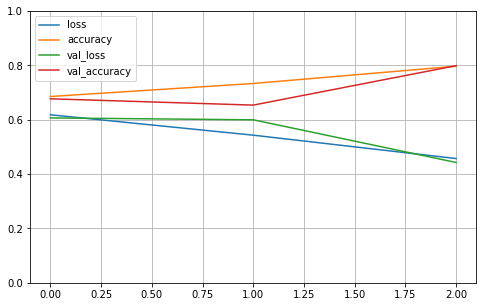

Train set ones/size 2846 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 339 / 1034
Range of scores: 0.003327268 to 0.99010766
Score threshold 0.5
Prediction set ones/size 235 / 1034


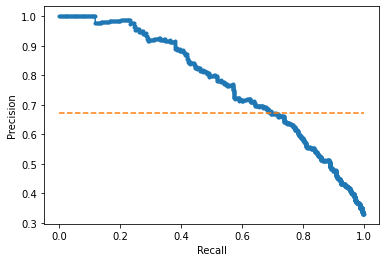

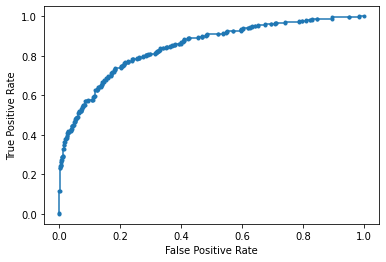

Accuracy: 79.88% Precision: 77.87% Recall: 53.98%
F1: 63.76% AUPRC: 77.35% AUROC: 84.54%
2023-02-07 15:57:09.747431
Fold 2
RCI mean derived from training set: -0.9590621364119102
RCI threshold derived from training set: 0
FIT
2023-02-07 15:57:13.842314
PREDICT
2023-02-07 15:57:25.299260


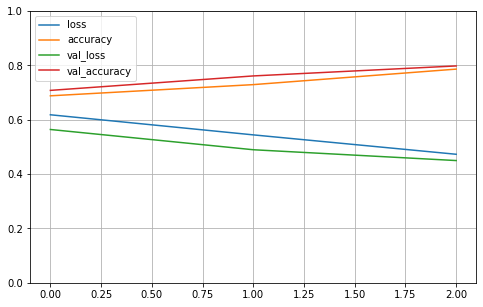

Train set ones/size 2870 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 315 / 1034
Range of scores: 0.004072742 to 0.9823177
Score threshold 0.5
Prediction set ones/size 216 / 1034


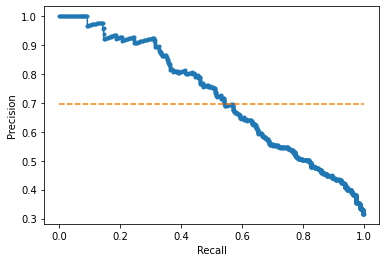

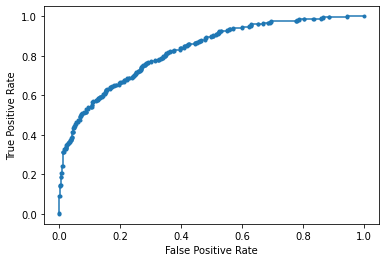

Accuracy: 79.79% Precision: 74.54% Recall: 51.11%
F1: 60.64% AUPRC: 72.15% AUROC: 82.59%
2023-02-07 15:57:25.998695
Fold 3
RCI mean derived from training set: -0.9621559835676664
RCI threshold derived from training set: 0
FIT
2023-02-07 15:57:30.052941
PREDICT
2023-02-07 15:57:41.443768


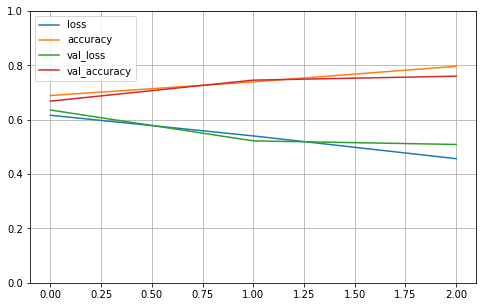

Train set ones/size 2839 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 346 / 1034
Range of scores: 0.001530912 to 0.997071
Score threshold 0.5
Prediction set ones/size 186 / 1034


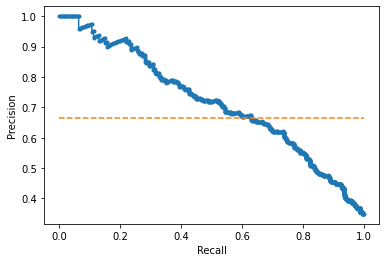

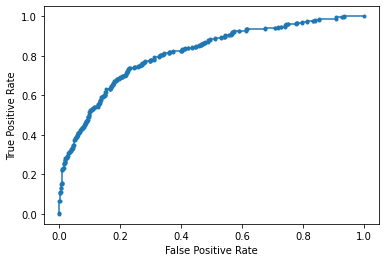

Accuracy: 76.02% Precision: 76.34% Recall: 41.04%
F1: 53.38% AUPRC: 71.75% AUROC: 81.33%
2023-02-07 15:57:42.139965
Fold 4
RCI mean derived from training set: -0.958191079807589
RCI threshold derived from training set: 0
FIT
2023-02-07 15:57:46.243313
PREDICT
2023-02-07 15:57:56.366351


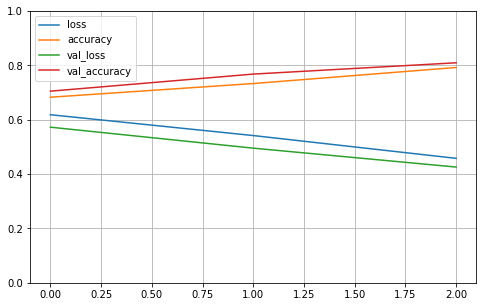

Train set ones/size 2877 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 308 / 1034
Range of scores: 0.003425042 to 0.9926611
Score threshold 0.5
Prediction set ones/size 189 / 1034


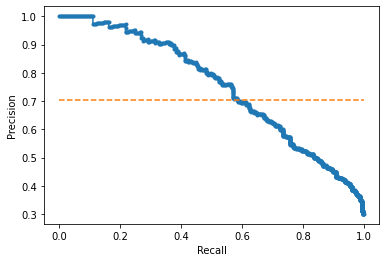

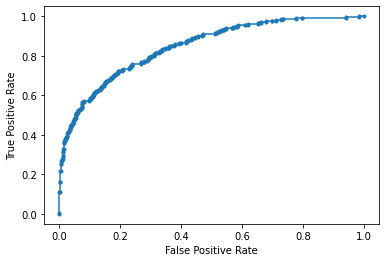

Accuracy: 80.95% Precision: 79.37% Recall: 48.70%
F1: 60.36% AUPRC: 75.08% AUROC: 84.68%
2023-02-07 15:57:57.046475
Fold 5
RCI mean derived from training set: -0.9628417059926905
RCI threshold derived from training set: 0
FIT
2023-02-07 15:58:02.106508
PREDICT
2023-02-07 15:58:13.670640


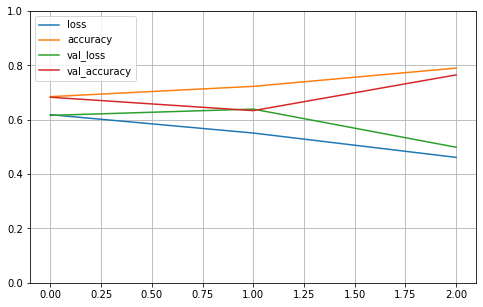

Train set ones/size 2858 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 327 / 1034
Range of scores: 0.0010203822 to 0.9801917
Score threshold 0.5
Prediction set ones/size 120 / 1034


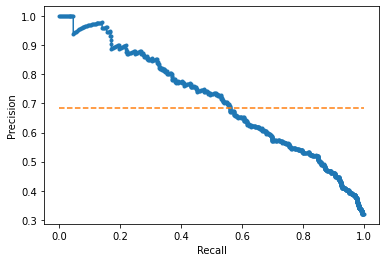

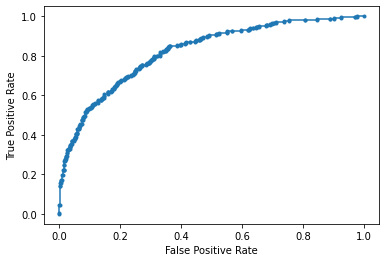

Accuracy: 76.50% Precision: 85.00% Recall: 31.19%
F1: 45.64% AUPRC: 71.29% AUROC: 82.17%
2023-02-07 15:58:14.570632
Fold 6
RCI mean derived from training set: -0.9595112937514781
RCI threshold derived from training set: 0
FIT
2023-02-07 15:58:18.740195
PREDICT
2023-02-07 15:58:30.150438


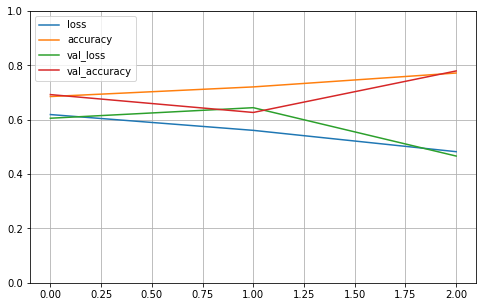

Train set ones/size 2867 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 318 / 1034
Range of scores: 0.003225333 to 0.98159
Score threshold 0.5
Prediction set ones/size 306 / 1034


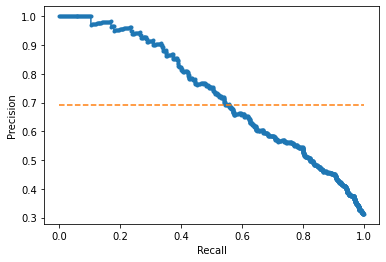

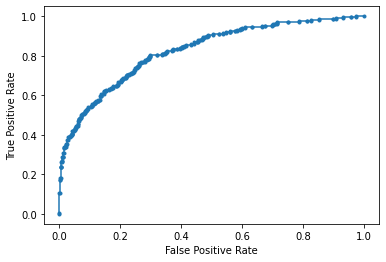

Accuracy: 77.95% Precision: 64.71% Recall: 62.26%
F1: 63.46% AUPRC: 73.05% AUROC: 82.59%
2023-02-07 15:58:30.993697
Fold 7
RCI mean derived from training set: -0.9601035896538751
RCI threshold derived from training set: 0
FIT
2023-02-07 15:58:35.030756
PREDICT
2023-02-07 15:58:45.196200


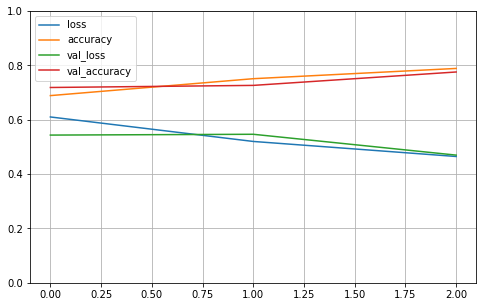

Train set ones/size 2877 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 308 / 1034
Range of scores: 0.0014053998 to 0.9683535
Score threshold 0.5
Prediction set ones/size 144 / 1034


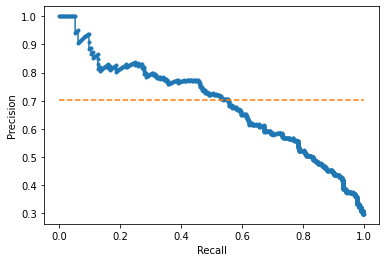

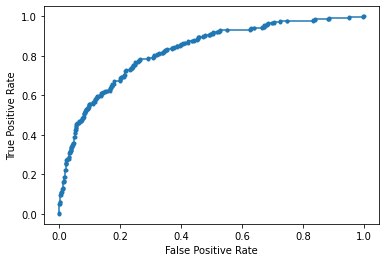

Accuracy: 77.56% Precision: 76.39% Recall: 35.71%
F1: 48.67% AUPRC: 68.81% AUROC: 82.65%
2023-02-07 15:58:45.877613
Fold 8
RCI mean derived from training set: -0.9442116707889081
RCI threshold derived from training set: 0
FIT
2023-02-07 15:58:49.951921
PREDICT
2023-02-07 15:59:01.355571


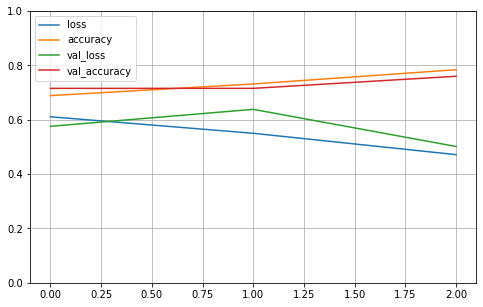

Train set ones/size 2880 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 305 / 1033
Range of scores: 0.00058108364 to 0.984992
Score threshold 0.5
Prediction set ones/size 287 / 1033


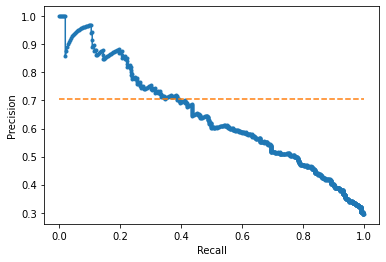

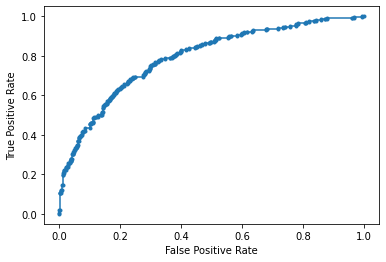

Accuracy: 75.99% Precision: 59.93% Recall: 56.39%
F1: 58.11% AUPRC: 64.51% AUROC: 79.18%
2023-02-07 15:59:02.041584
Fold 9
RCI mean derived from training set: -0.9603716917605332
RCI threshold derived from training set: 0
FIT
2023-02-07 15:59:06.694058
PREDICT
2023-02-07 15:59:18.446411


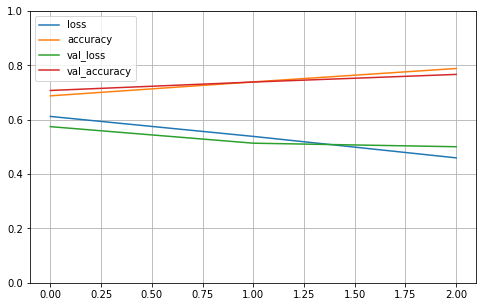

Train set ones/size 2852 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 333 / 1033
Range of scores: 0.0027877474 to 0.96934265
Score threshold 0.5
Prediction set ones/size 140 / 1033


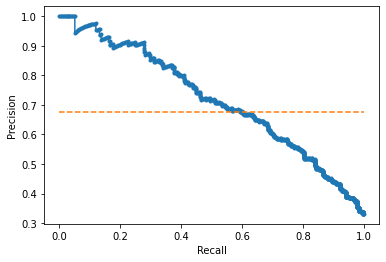

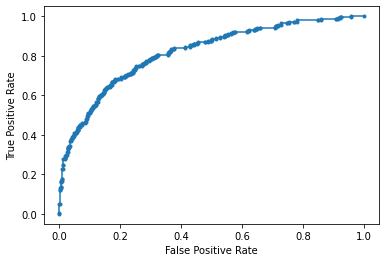

Accuracy: 76.67% Precision: 82.86% Recall: 34.83%
F1: 49.05% AUPRC: 71.89% AUROC: 81.78%
2023-02-07 15:59:19.491041
Fold 10
RCI mean derived from training set: -0.9432120966089854
RCI threshold derived from training set: 0
FIT
2023-02-07 15:59:23.782034
PREDICT
2023-02-07 15:59:33.703810


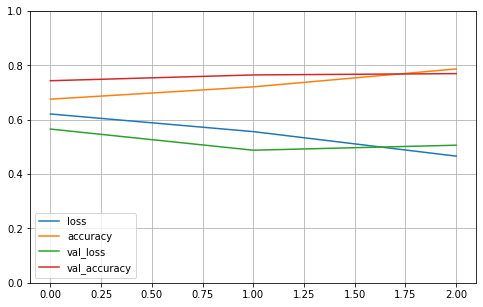

Train set ones/size 2899 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 286 / 1033
Range of scores: 0.0010697291 to 0.9777323
Score threshold 0.5
Prediction set ones/size 66 / 1033


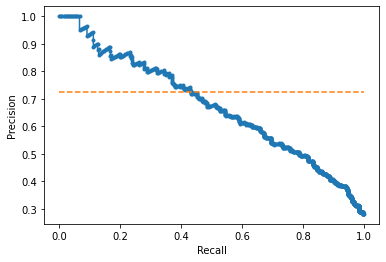

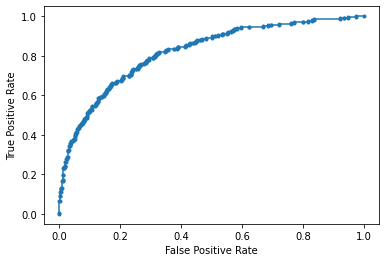

Accuracy: 76.96% Precision: 86.36% Recall: 19.93%
F1: 32.39% AUPRC: 67.40% AUROC: 82.02%
2023-02-07 15:59:34.727812

Completed cross validation 10 folds 3 epochs
 accuracy mean 77.83% +/- 1.78
 precision mean 76.34% +/- 8.42
 recall mean 43.52% +/- 13.17
 F1 mean 53.55% +/- 9.86
 AUPRC mean 71.33% +/- 3.69
 AUROC mean 82.35% +/- 1.56
Finished cell Line 11 SK.N.SH

2023-02-07 15:59:36.184412
Start cell Line 12 GM12878
Number of RCI values loaded 1698
Num RCI: 1698
Load sequence...
Cross validation...
2023-02-07 15:59:51.283551
splitting
Fold 1
RCI mean derived from training set: -0.7917608026152975
RCI threshold derived from training set: 0
FIT
2023-02-07 15:59:53.842547
PREDICT
2023-02-07 16:00:03.481726


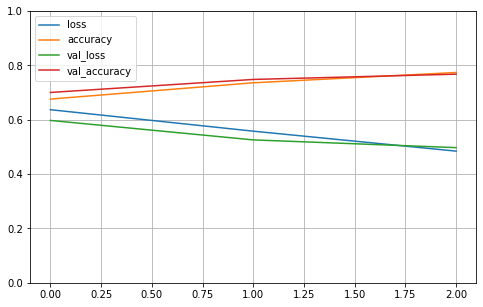

Train set ones/size 2814 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 326 / 981
Range of scores: 0.0029688934 to 0.9883309
Score threshold 0.5
Prediction set ones/size 132 / 981


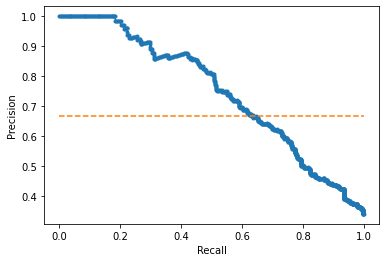

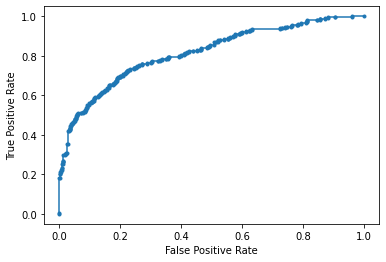

Accuracy: 76.76% Precision: 87.12% Recall: 35.28%
F1: 50.22% AUPRC: 74.81% AUROC: 81.55%
2023-02-07 16:00:04.196901
Fold 2
RCI mean derived from training set: -0.7848096078186968
RCI threshold derived from training set: 0
FIT
2023-02-07 16:00:08.064834
PREDICT
2023-02-07 16:00:17.672629


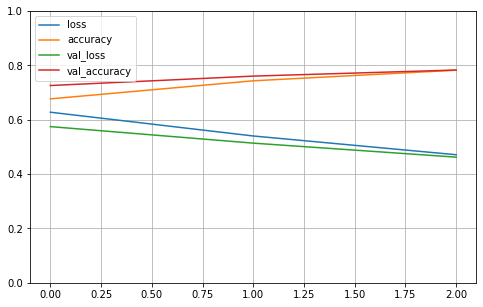

Train set ones/size 2824 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 316 / 981
Range of scores: 0.006475103 to 0.9893566
Score threshold 0.5
Prediction set ones/size 273 / 981


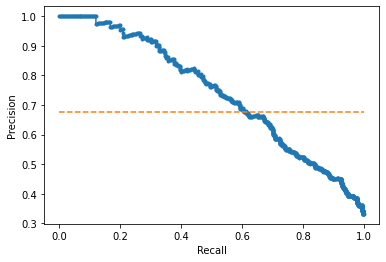

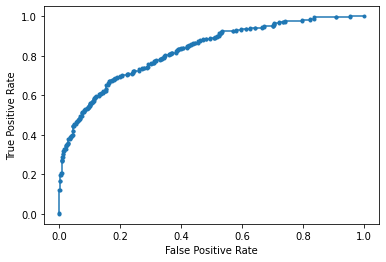

Accuracy: 78.29% Precision: 68.86% Recall: 59.49%
F1: 63.84% AUPRC: 74.20% AUROC: 82.59%
2023-02-07 16:00:18.389177
Fold 3
RCI mean derived from training set: -0.7932426588759207
RCI threshold derived from training set: 0
FIT
2023-02-07 16:00:22.265961
PREDICT
2023-02-07 16:00:31.954380


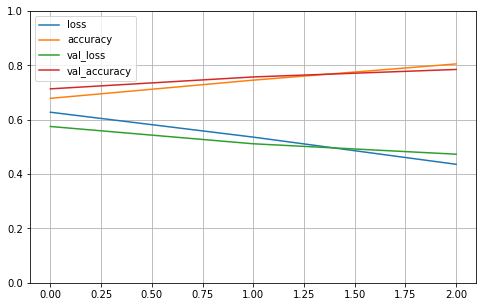

Train set ones/size 2811 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 329 / 981
Range of scores: 0.0011590857 to 0.9934788
Score threshold 0.5
Prediction set ones/size 202 / 981


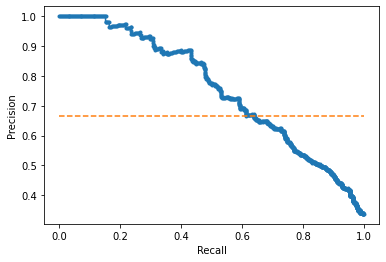

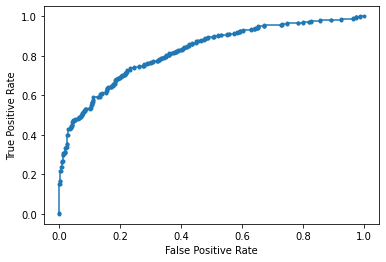

Accuracy: 78.49% Precision: 79.21% Recall: 48.63%
F1: 60.26% AUPRC: 75.49% AUROC: 82.32%
2023-02-07 16:00:32.656040
Fold 4
RCI mean derived from training set: -0.7787853194719547
RCI threshold derived from training set: 0
FIT
2023-02-07 16:00:36.519891
PREDICT
2023-02-07 16:00:46.025071


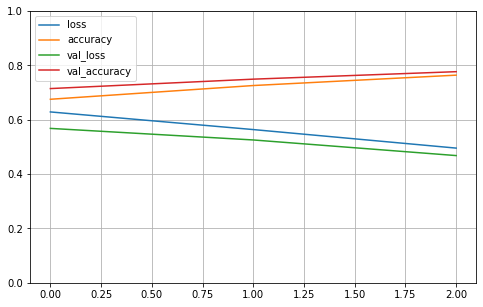

Train set ones/size 2834 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 306 / 981
Range of scores: 0.016132146 to 0.98807645
Score threshold 0.5
Prediction set ones/size 171 / 981


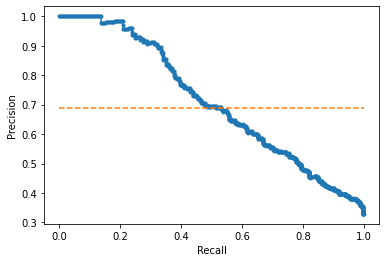

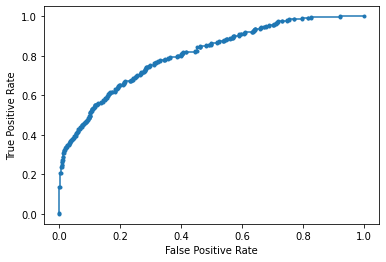

Accuracy: 77.68% Precision: 75.44% Recall: 42.16%
F1: 54.09% AUPRC: 71.17% AUROC: 80.70%
2023-02-07 16:00:46.717277
Fold 5
RCI mean derived from training set: -0.7845497024022663
RCI threshold derived from training set: 0
FIT
2023-02-07 16:00:50.616389
PREDICT
2023-02-07 16:01:00.257715


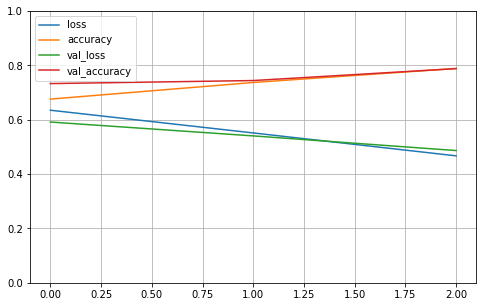

Train set ones/size 2828 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 312 / 981
Range of scores: 0.0036635746 to 0.9910025
Score threshold 0.5
Prediction set ones/size 136 / 981


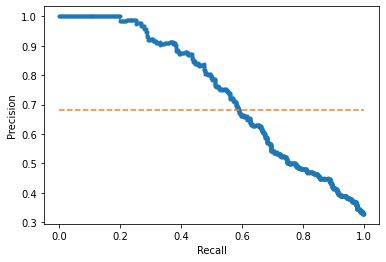

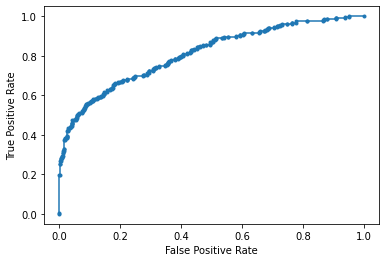

Accuracy: 78.80% Precision: 88.24% Recall: 38.46%
F1: 53.57% AUPRC: 74.19% AUROC: 81.05%
2023-02-07 16:01:00.935524
Fold 6
RCI mean derived from training set: -0.791977157883286
RCI threshold derived from training set: 0
FIT
2023-02-07 16:01:05.550917
PREDICT
2023-02-07 16:01:14.953387


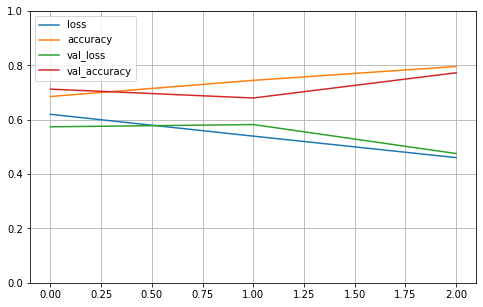

Train set ones/size 2812 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 328 / 981
Range of scores: 0.005782392 to 0.99572587
Score threshold 0.5
Prediction set ones/size 227 / 981


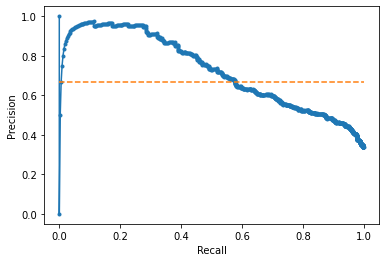

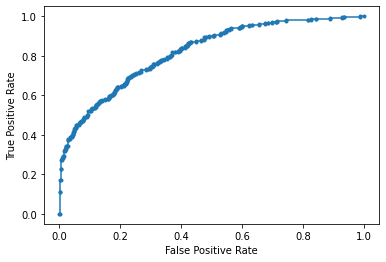

Accuracy: 77.27% Precision: 73.13% Recall: 50.61%
F1: 59.82% AUPRC: 72.47% AUROC: 81.83%
2023-02-07 16:01:15.663923
Fold 7
RCI mean derived from training set: -0.7820942513777476
RCI threshold derived from training set: 0
FIT
2023-02-07 16:01:21.164333
PREDICT
2023-02-07 16:01:32.539525


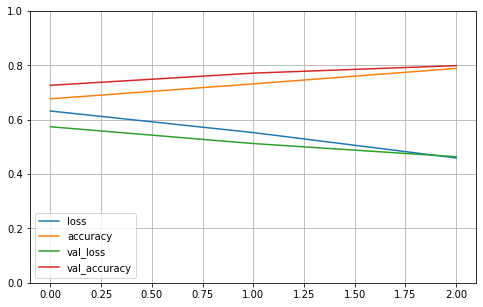

Train set ones/size 2833 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 307 / 980
Range of scores: 0.007713766 to 0.9943626
Score threshold 0.5
Prediction set ones/size 248 / 980


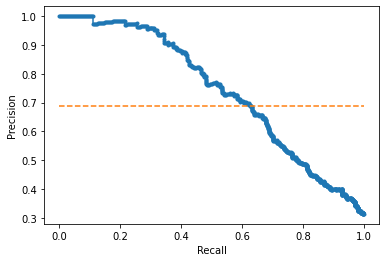

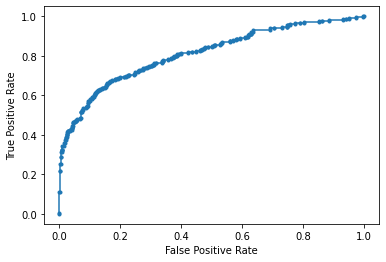

Accuracy: 79.90% Precision: 72.18% Recall: 58.31%
F1: 64.50% AUPRC: 74.20% AUROC: 81.14%
2023-02-07 16:01:33.426377
Fold 8
RCI mean derived from training set: -0.7733633923476094
RCI threshold derived from training set: 0
FIT
2023-02-07 16:01:37.319668
PREDICT
2023-02-07 16:01:48.694353


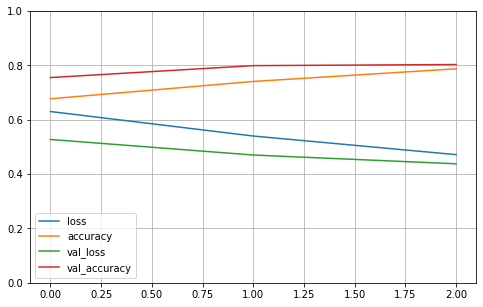

Train set ones/size 2869 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 271 / 980
Range of scores: 0.0069425553 to 0.9928156
Score threshold 0.5
Prediction set ones/size 242 / 980


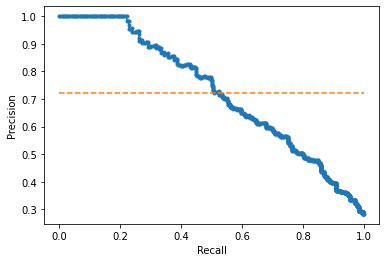

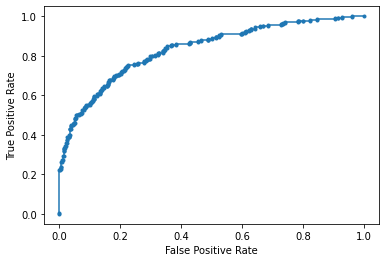

Accuracy: 80.31% Precision: 66.12% Recall: 59.04%
F1: 62.38% AUPRC: 72.62% AUROC: 83.31%
2023-02-07 16:01:49.546111
Fold 9
RCI mean derived from training set: -0.7889935849399501
RCI threshold derived from training set: 0
FIT
2023-02-07 16:01:53.435040
PREDICT
2023-02-07 16:02:03.039377


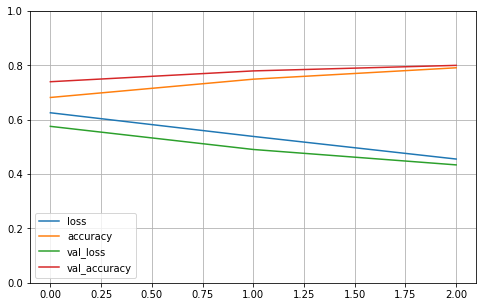

Train set ones/size 2815 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 325 / 980
Range of scores: 0.0043578423 to 0.9877352
Score threshold 0.5
Prediction set ones/size 249 / 980


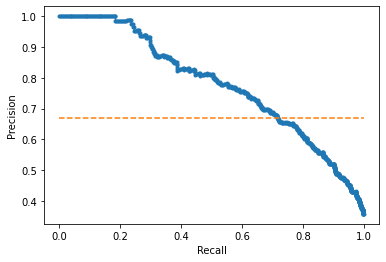

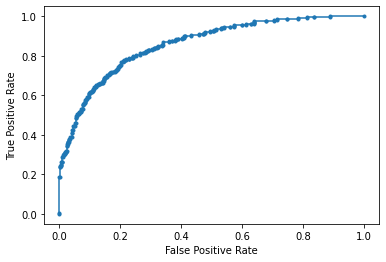

Accuracy: 80.00% Precision: 75.90% Recall: 58.15%
F1: 65.85% AUPRC: 77.96% AUROC: 85.82%
2023-02-07 16:02:03.729767
Fold 10
RCI mean derived from training set: -0.7912181729707681
RCI threshold derived from training set: 0
FIT
2023-02-07 16:02:07.664563
PREDICT
2023-02-07 16:02:19.103694


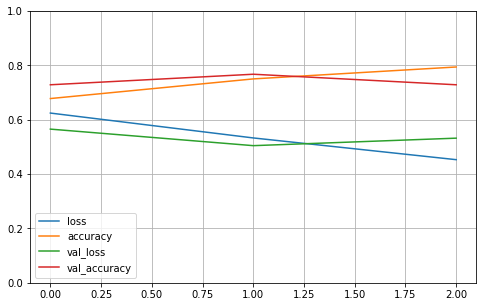

Train set ones/size 2820 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 320 / 980
Range of scores: 0.021164596 to 0.9978497
Score threshold 0.5
Prediction set ones/size 426 / 980


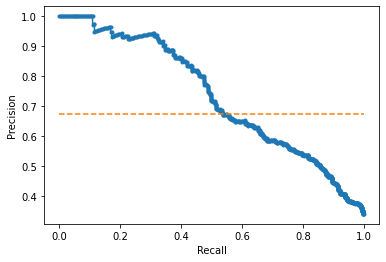

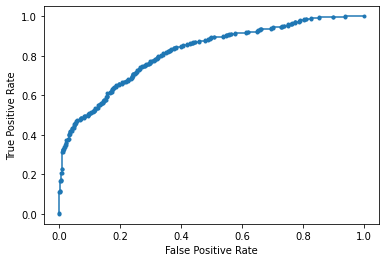

Accuracy: 72.86% Precision: 56.34% Recall: 75.00%
F1: 64.34% AUPRC: 73.48% AUROC: 81.75%
2023-02-07 16:02:19.963209

Completed cross validation 10 folds 3 epochs
 accuracy mean 78.03% +/- 2.17
 precision mean 74.25% +/- 9.50
 recall mean 52.51% +/- 11.94
 F1 mean 59.89% +/- 5.43
 AUPRC mean 74.06% +/- 1.86
 AUROC mean 82.21% +/- 1.49
Finished cell Line 12 GM12878

2023-02-07 16:02:21.394762
Start cell Line 13 K562
Number of RCI values loaded 958
Num RCI: 958
Load sequence...
Cross validation...
2023-02-07 16:02:32.094846
splitting
Fold 1
RCI mean derived from training set: -0.6713087291342756
RCI threshold derived from training set: 0
FIT
2023-02-07 16:02:34.013364
PREDICT
2023-02-07 16:02:41.268673


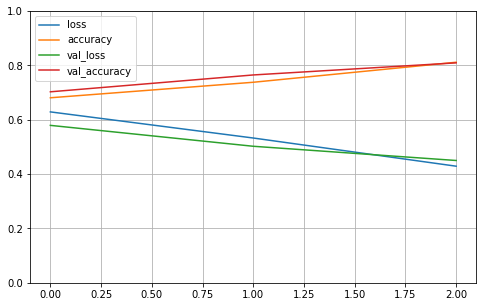

Train set ones/size 1756 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 187 / 629
Range of scores: 3.7514612e-05 to 0.99061626
Score threshold 0.5
Prediction set ones/size 169 / 629


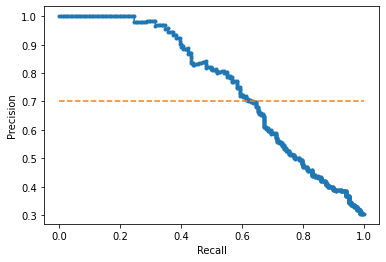

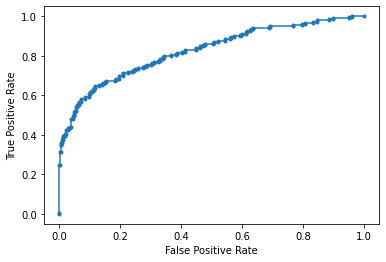

Accuracy: 80.92% Precision: 69.82% Recall: 63.10%
F1: 66.29% AUPRC: 75.64% AUROC: 82.51%
2023-02-07 16:02:41.979596
Fold 2
RCI mean derived from training set: -0.6737843573215548
RCI threshold derived from training set: 0
FIT
2023-02-07 16:02:45.022920
PREDICT
2023-02-07 16:02:51.810666


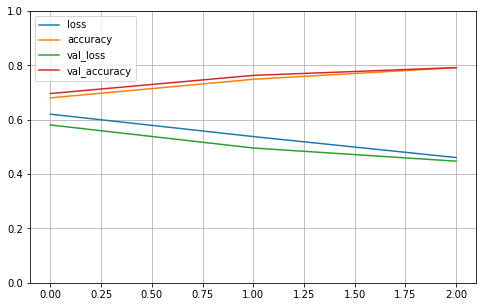

Train set ones/size 1753 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 190 / 629
Range of scores: 0.0071903123 to 0.96218973
Score threshold 0.5
Prediction set ones/size 97 / 629


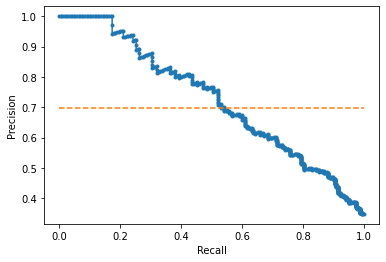

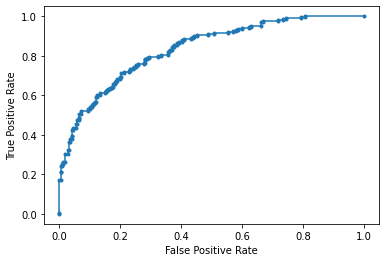

Accuracy: 79.17% Precision: 80.41% Recall: 41.05%
F1: 54.36% AUPRC: 72.65% AUROC: 83.47%
2023-02-07 16:02:52.780250
Fold 3
RCI mean derived from training set: -0.6784838250318022
RCI threshold derived from training set: 0
FIT
2023-02-07 16:02:55.925829
PREDICT
2023-02-07 16:03:07.238218


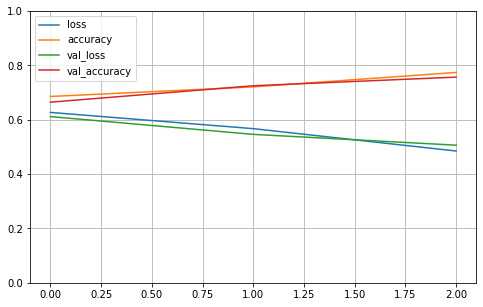

Train set ones/size 1731 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 212 / 629
Range of scores: 0.0104274815 to 0.9855752
Score threshold 0.5
Prediction set ones/size 237 / 629


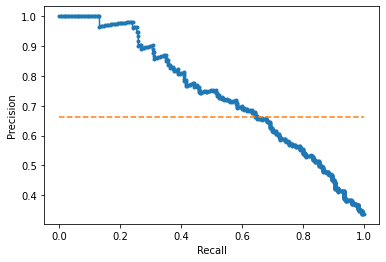

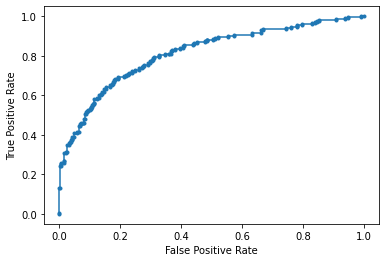

Accuracy: 75.68% Precision: 62.45% Recall: 69.81%
F1: 65.92% AUPRC: 73.97% AUROC: 81.33%
2023-02-07 16:03:07.931558
Fold 4
RCI mean derived from training set: -0.6876066247208481
RCI threshold derived from training set: 0
FIT
2023-02-07 16:03:11.074336
PREDICT
2023-02-07 16:03:22.350076


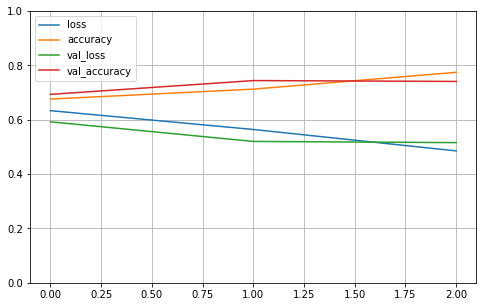

Train set ones/size 1750 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 193 / 629
Range of scores: 0.012050055 to 0.9865001
Score threshold 0.5
Prediction set ones/size 238 / 629


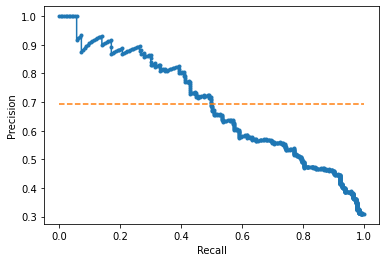

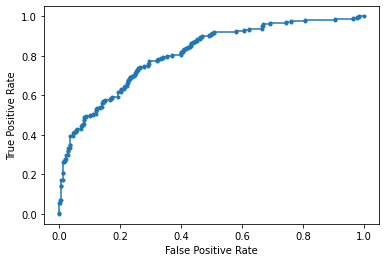

Accuracy: 74.09% Precision: 56.30% Recall: 69.43%
F1: 62.18% AUPRC: 68.93% AUROC: 80.99%
2023-02-07 16:03:23.081520
Fold 5
RCI mean derived from training set: -0.6696898698833923
RCI threshold derived from training set: 0
FIT
2023-02-07 16:03:26.255821
PREDICT
2023-02-07 16:03:37.555824


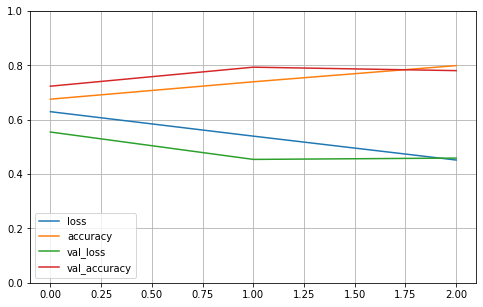

Train set ones/size 1762 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 181 / 629
Range of scores: 0.0062157637 to 0.98421127
Score threshold 0.5
Prediction set ones/size 215 / 629


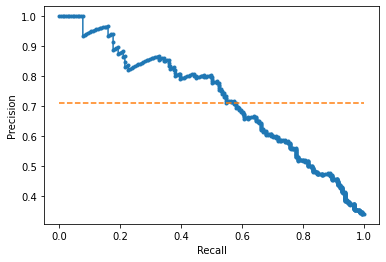

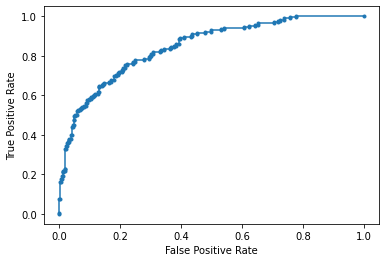

Accuracy: 78.06% Precision: 60.00% Recall: 71.27%
F1: 65.15% AUPRC: 72.32% AUROC: 84.67%
2023-02-07 16:03:38.322116
Fold 6
RCI mean derived from training set: -0.6754036411201414
RCI threshold derived from training set: 0
FIT
2023-02-07 16:03:41.593078
PREDICT
2023-02-07 16:03:53.250361


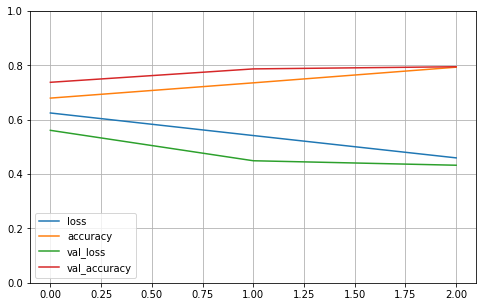

Train set ones/size 1757 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 186 / 629
Range of scores: 0.005422148 to 0.9899635
Score threshold 0.5
Prediction set ones/size 209 / 629


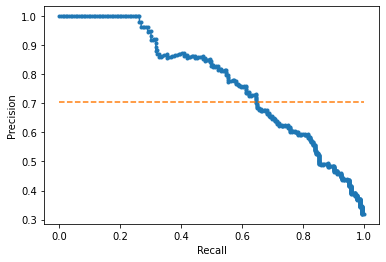

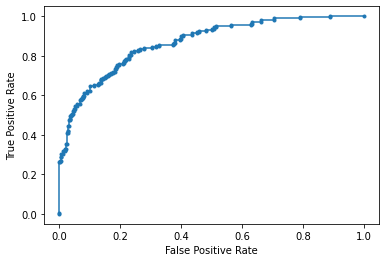

Accuracy: 79.49% Precision: 63.64% Recall: 71.51%
F1: 67.34% AUPRC: 77.81% AUROC: 86.72%
2023-02-07 16:03:54.000018
Fold 7
RCI mean derived from training set: -0.6775167190000001
RCI threshold derived from training set: 0
FIT
2023-02-07 16:03:58.361124
PREDICT
2023-02-07 16:04:05.173661


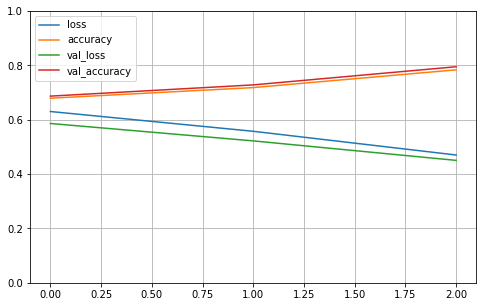

Train set ones/size 1746 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 197 / 629
Range of scores: 0.013662636 to 0.9755402
Score threshold 0.5
Prediction set ones/size 164 / 629


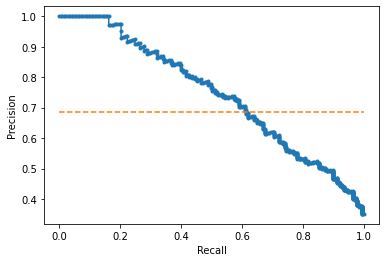

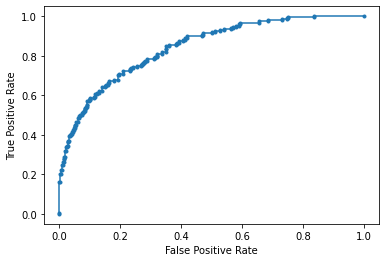

Accuracy: 79.49% Precision: 70.73% Recall: 58.88%
F1: 64.27% AUPRC: 74.47% AUROC: 84.20%
2023-02-07 16:04:05.947131
Fold 8
RCI mean derived from training set: -0.6808395354416962
RCI threshold derived from training set: 0
FIT
2023-02-07 16:04:09.199172
PREDICT
2023-02-07 16:04:16.644632


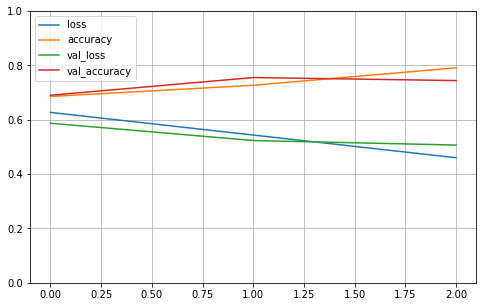

Train set ones/size 1742 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 201 / 629
Range of scores: 0.013644317 to 0.986761
Score threshold 0.5
Prediction set ones/size 260 / 629


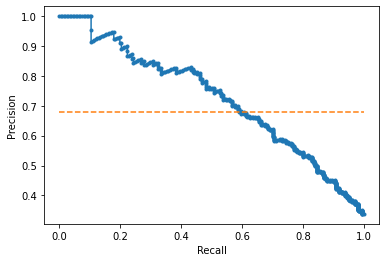

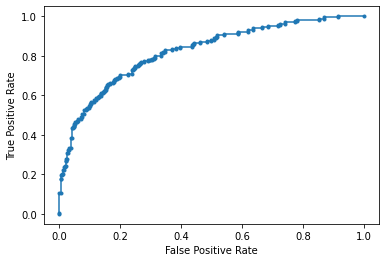

Accuracy: 74.40% Precision: 57.69% Recall: 74.63%
F1: 65.08% AUPRC: 72.47% AUROC: 82.32%
2023-02-07 16:04:17.418870
Fold 9
RCI mean derived from training set: -0.6768322222844524
RCI threshold derived from training set: 0
FIT
2023-02-07 16:04:20.684883
PREDICT
2023-02-07 16:04:27.854501


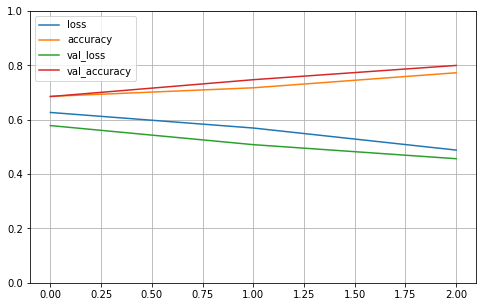

Train set ones/size 1744 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 199 / 629
Range of scores: 0.00732893 to 0.96732783
Score threshold 0.5
Prediction set ones/size 117 / 629


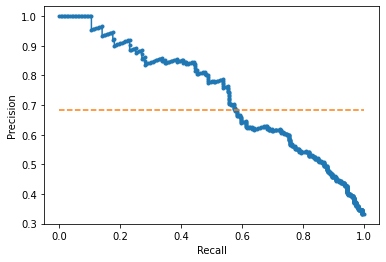

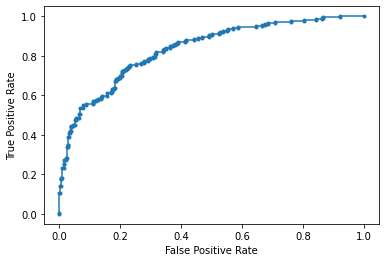

Accuracy: 79.97% Precision: 81.20% Recall: 47.74%
F1: 60.13% AUPRC: 73.56% AUROC: 83.36%
2023-02-07 16:04:28.600909
Fold 10
RCI mean derived from training set: -0.6857367733633634
RCI threshold derived from training set: 0
FIT
2023-02-07 16:04:31.873824
PREDICT
2023-02-07 16:04:38.687393


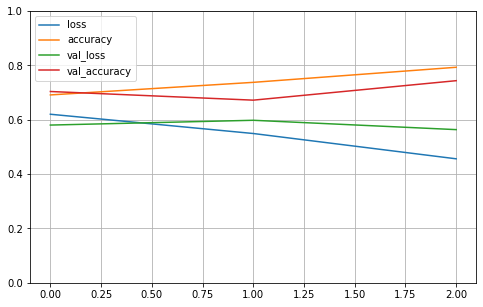

Train set ones/size 1746 / 5661
Compute valiation accuracy
Valid sizes (628, 4997) (628,)
Valid set ones/size 197 / 628
Range of scores: 0.004604001 to 0.9324141
Score threshold 0.5
Prediction set ones/size 52 / 628


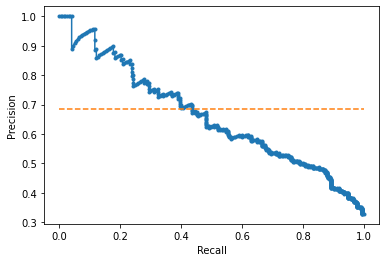

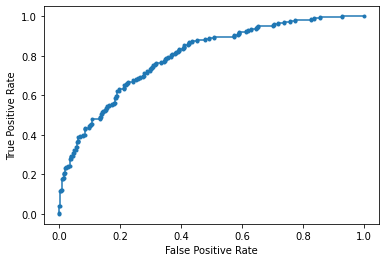

Accuracy: 74.36% Precision: 84.62% Recall: 22.34%
F1: 35.34% AUPRC: 66.14% AUROC: 79.62%
2023-02-07 16:04:39.652046

Completed cross validation 10 folds 3 epochs
 accuracy mean 77.56% +/- 2.65
 precision mean 68.69% +/- 10.37
 recall mean 58.98% +/- 16.95
 F1 mean 60.61% +/- 9.66
 AUPRC mean 72.80% +/- 3.29
 AUROC mean 82.92% +/- 2.04
Finished cell Line 13 K562

2023-02-07 16:04:41.201677
Start cell Line 14 IMR.90
Number of RCI values loaded 390
Num RCI: 390
Load sequence...
Cross validation...
2023-02-07 16:04:45.171564
splitting
Fold 1
RCI mean derived from training set: -0.7940587397297298
RCI threshold derived from training set: 0
FIT
2023-02-07 16:04:46.009189
PREDICT
2023-02-07 16:04:49.471910


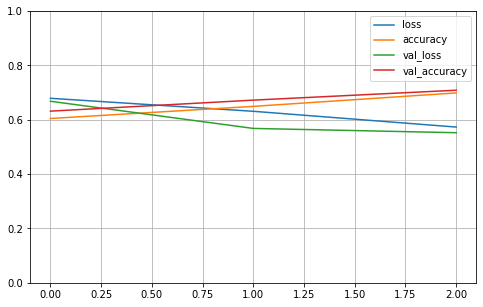

Train set ones/size 840 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 83 / 247
Range of scores: 0.027918585 to 0.8112909
Score threshold 0.5
Prediction set ones/size 33 / 247


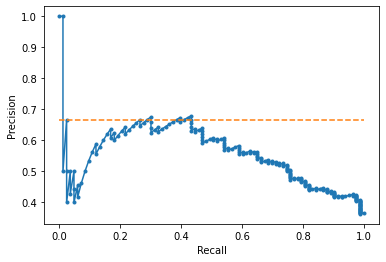

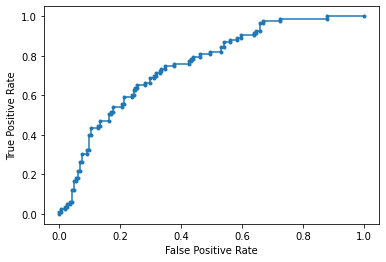

Accuracy: 70.85% Precision: 66.67% Recall: 26.51%
F1: 37.93% AUPRC: 55.64% AUROC: 75.46%
2023-02-07 16:04:50.205720
Fold 2
RCI mean derived from training set: -0.792873576036036
RCI threshold derived from training set: 0
FIT
2023-02-07 16:04:52.829869
PREDICT
2023-02-07 16:04:56.367468


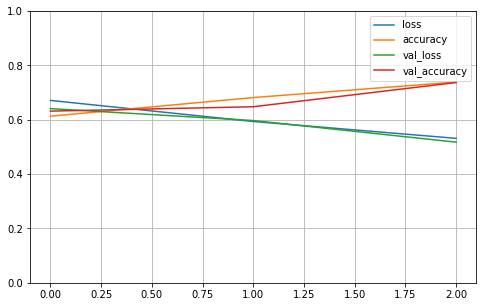

Train set ones/size 830 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 93 / 247
Range of scores: 0.008371308 to 0.918823
Score threshold 0.5
Prediction set ones/size 72 / 247


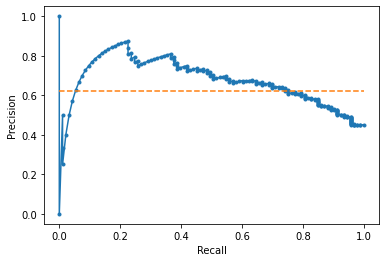

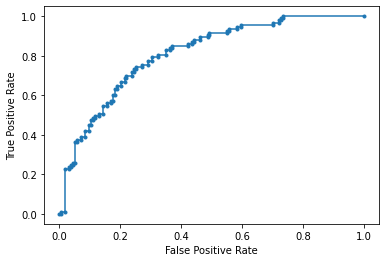

Accuracy: 73.68% Precision: 69.44% Recall: 53.76%
F1: 60.61% AUPRC: 66.98% AUROC: 81.07%
2023-02-07 16:04:57.039899
Fold 3
RCI mean derived from training set: -0.8008805327927928
RCI threshold derived from training set: 0
FIT
2023-02-07 16:04:59.104847
PREDICT
2023-02-07 16:05:02.493501


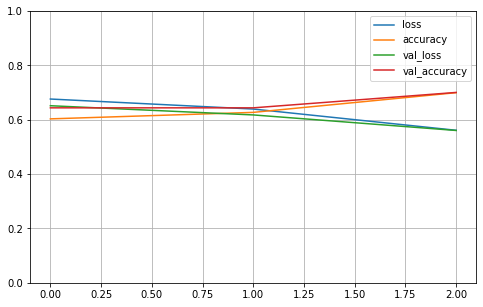

Train set ones/size 834 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 89 / 247
Range of scores: 0.024885975 to 0.92014706
Score threshold 0.5
Prediction set ones/size 97 / 247


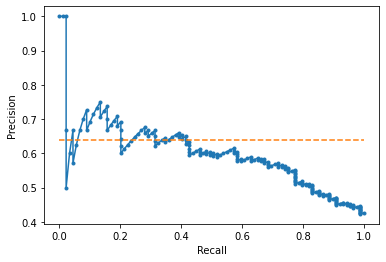

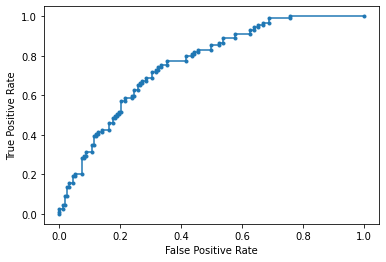

Accuracy: 70.04% Precision: 57.73% Recall: 62.92%
F1: 60.22% AUPRC: 59.92% AUROC: 76.13%
2023-02-07 16:05:03.180149
Fold 4
RCI mean derived from training set: -0.8059054895045044
RCI threshold derived from training set: 0
FIT
2023-02-07 16:05:05.821411
PREDICT
2023-02-07 16:05:09.526656


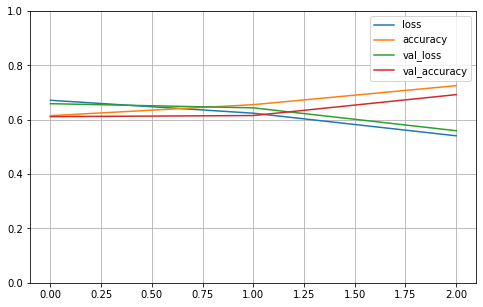

Train set ones/size 825 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 98 / 247
Range of scores: 0.014954305 to 0.79525846
Score threshold 0.5
Prediction set ones/size 52 / 247


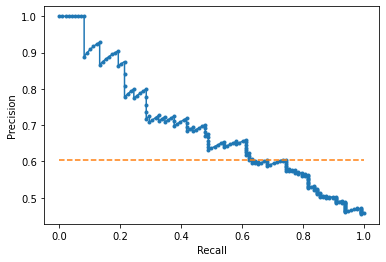

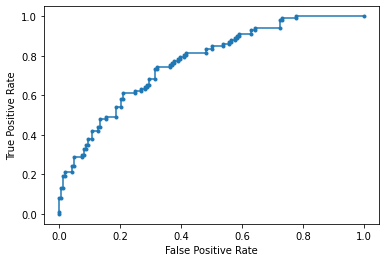

Accuracy: 69.23% Precision: 71.15% Recall: 37.76%
F1: 49.33% AUPRC: 69.05% AUROC: 76.77%
2023-02-07 16:05:10.211414
Fold 5
RCI mean derived from training set: -0.786263587027027
RCI threshold derived from training set: 0
FIT
2023-02-07 16:05:12.244246
PREDICT
2023-02-07 16:05:15.425647


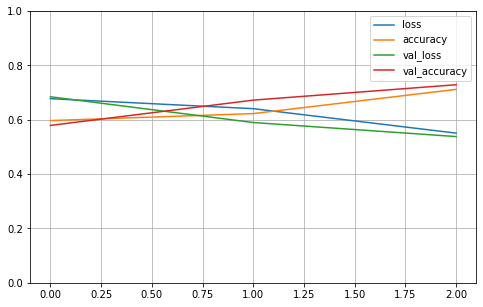

Train set ones/size 832 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 91 / 247
Range of scores: 0.0010464167 to 0.873891
Score threshold 0.5
Prediction set ones/size 44 / 247


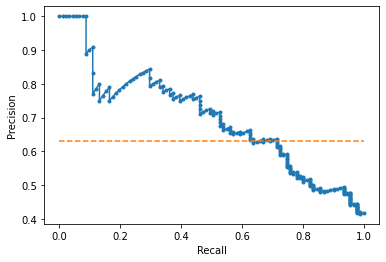

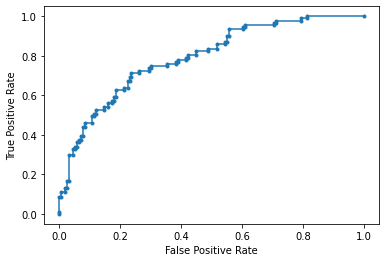

Accuracy: 72.87% Precision: 77.27% Recall: 37.36%
F1: 50.37% AUPRC: 69.55% AUROC: 79.21%
2023-02-07 16:05:16.064225
Fold 6
RCI mean derived from training set: -0.8023878546846847
RCI threshold derived from training set: 0
FIT
2023-02-07 16:05:18.270884
PREDICT
2023-02-07 16:05:21.985506


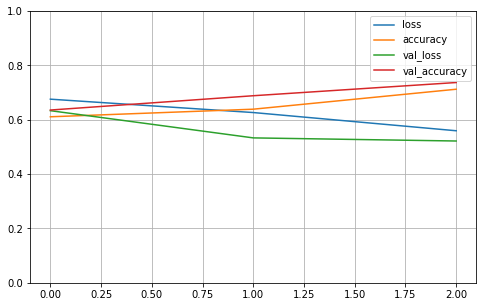

Train set ones/size 833 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 90 / 247
Range of scores: 0.030255867 to 0.9644773
Score threshold 0.5
Prediction set ones/size 119 / 247


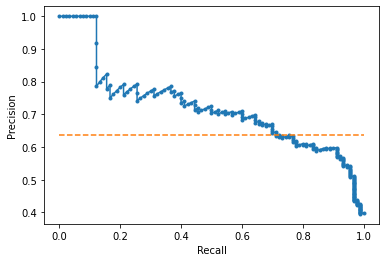

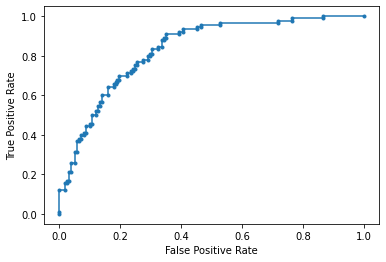

Accuracy: 73.68% Precision: 60.50% Recall: 80.00%
F1: 68.90% AUPRC: 72.17% AUROC: 83.37%
2023-02-07 16:05:22.694288
Fold 7
RCI mean derived from training set: -0.8069793445045045
RCI threshold derived from training set: 0
FIT
2023-02-07 16:05:24.713613
PREDICT
2023-02-07 16:05:27.923441


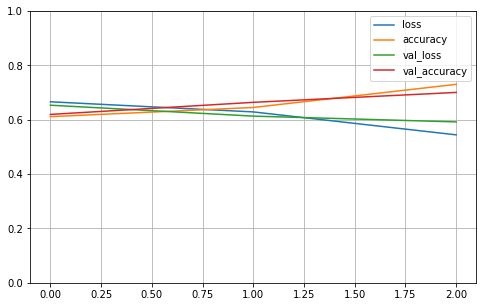

Train set ones/size 829 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 94 / 247
Range of scores: 0.025270052 to 0.90865946
Score threshold 0.5
Prediction set ones/size 52 / 247


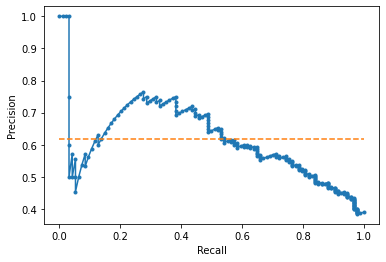

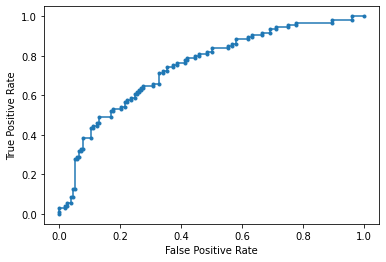

Accuracy: 70.04% Precision: 69.23% Recall: 38.30%
F1: 49.32% AUPRC: 61.49% AUROC: 74.57%
2023-02-07 16:05:28.650494
Fold 8
RCI mean derived from training set: -0.8009138882485366
RCI threshold derived from training set: 0
FIT
2023-02-07 16:05:30.716790
PREDICT
2023-02-07 16:05:36.794325


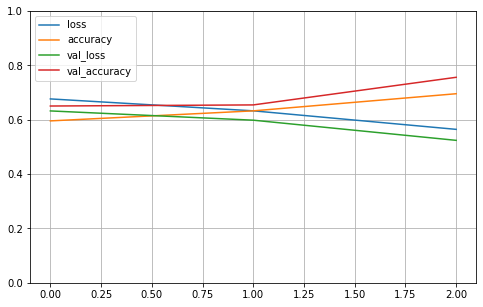

Train set ones/size 838 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 85 / 246
Range of scores: 0.00971198 to 0.9636953
Score threshold 0.5
Prediction set ones/size 93 / 246


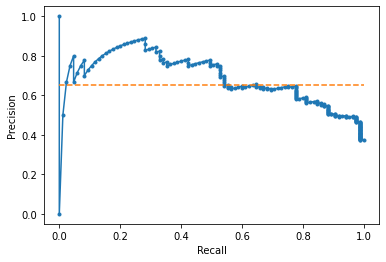

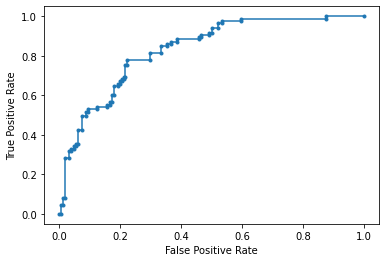

Accuracy: 75.61% Precision: 63.44% Recall: 69.41%
F1: 66.29% AUPRC: 68.54% AUROC: 83.28%
2023-02-07 16:05:37.512472
Fold 9
RCI mean derived from training set: -0.8323262177397568
RCI threshold derived from training set: 0
FIT
2023-02-07 16:05:39.584093
PREDICT
2023-02-07 16:05:42.804476


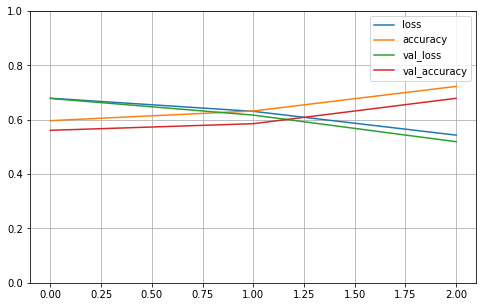

Train set ones/size 820 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 103 / 246
Range of scores: 0.003790964 to 0.91666996
Score threshold 0.5
Prediction set ones/size 44 / 246


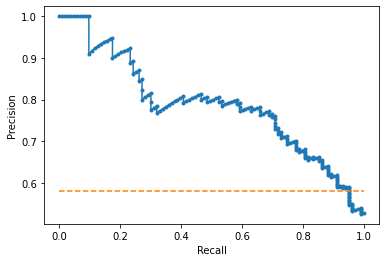

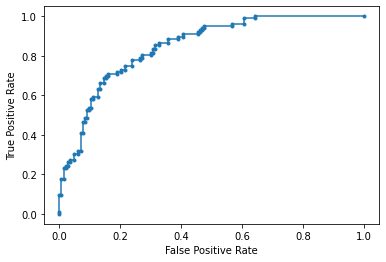

Accuracy: 67.89% Precision: 77.27% Recall: 33.01%
F1: 46.26% AUPRC: 78.70% AUROC: 84.88%
2023-02-07 16:05:43.422717
Fold 10
RCI mean derived from training set: -0.8036815406573616
RCI threshold derived from training set: 0
FIT
2023-02-07 16:05:45.811300
PREDICT
2023-02-07 16:05:49.437300


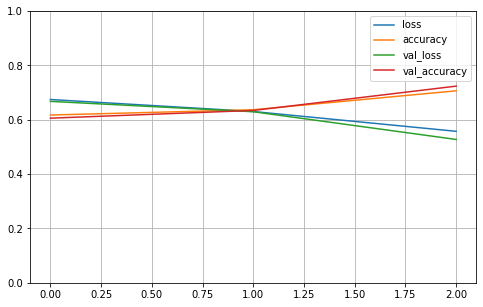

Train set ones/size 826 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 97 / 246
Range of scores: 0.011814734 to 0.90722716
Score threshold 0.5
Prediction set ones/size 75 / 246


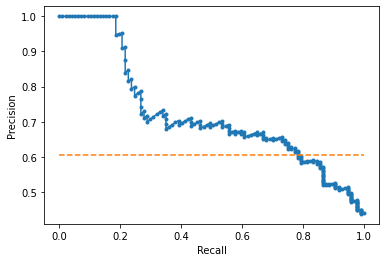

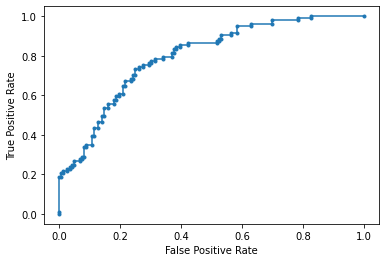

Accuracy: 72.36% Precision: 69.33% Recall: 53.61%
F1: 60.47% AUPRC: 72.19% AUROC: 79.74%
2023-02-07 16:05:50.095237

Completed cross validation 10 folds 3 epochs
 accuracy mean 71.63% +/- 2.40
 precision mean 68.21% +/- 6.42
 recall mean 49.26% +/- 17.49
 F1 mean 54.97% +/- 9.79
 AUPRC mean 67.42% +/- 6.76
 AUROC mean 79.45% +/- 3.66
Finished cell Line 14 IMR.90

2023-02-07 16:05:51.378434


In [10]:
for CELL_LINE in range(15):
    print(datetime.now())
    print('Start cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE
    gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE)
    print('Num RCI:', len(gene_to_rci.keys()))
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_FILE
    allids,allseq = loader.load_sequence(filepath)
    loader = None  # drop K-mer cache to save RAM

    print("Cross validation...")
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cvdo.set_sequences(allids,allseq)
    cvdo.set_rci_map(gene_to_rci)
    cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc = cvdo.do_cross_validation()   
    cvdo = None
    print("Completed cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
    print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy,ddof=1)))
    print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision,ddof=1)))
    print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall,ddof=1)))
    print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1,ddof=1)))
    print(" AUPRC mean %.2f%% +/- %.2f" % (np.mean(cv_auprc), np.std(cv_auprc,ddof=1)))
    print(" AUROC mean %.2f%% +/- %.2f" % (np.mean(cv_auroc), np.std(cv_auroc,ddof=1)))
    print('Finished cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    print()
print(datetime.now())